In [77]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn.functional as F
import cv2
import os

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
np.load.__defaults__=(None, True, True, 'ASCII')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [78]:
# We will use this variable in conditional_generation
Nmax = 129

In [79]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [80]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(400, 128)  # 6*6 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

    def forward(self, image_paths):
        all_zs = torch.empty(0, 128)
        # Max pooling over a (2, 2) window
        for i, data in enumerate(image_paths):
            img = mpimg.imread(data)
            gray = rgb2gray(img)
            x = torch.from_numpy(gray)
            # change (28,28) to (1,1,28,28)
            x = torch.unsqueeze(x,0)
            x = torch.unsqueeze(x,0)
            #print(f"dimension of x {x.shape}")
            x = F.max_pool2d(F.relu(self.conv1(x.float())), (2, 2))
            # If the size is a square you can only specify a single number
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = x.view(-1, self.num_flat_features(x))
            
            #print(x.shape) #1 x 400
            x = self.fc1(x)
            #print(all_zs.shape)
            all_zs = torch.cat([all_zs, x], dim=0)
            #all_zs.cat(x)
        return all_zs

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [81]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        # bidirectional lstm:
        self.lstm = nn.LSTM(5, hp.enc_hidden_size, \
            dropout=hp.dropout, bidirectional=True)
        # create mu and sigma from lstm's last output:
        self.fc_mu = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        self.fc_sigma = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        # active dropout:
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # then must init with zeros
            if use_cuda:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
            else:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size)
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size)
            hidden_cell = (hidden, cell)
        _, (hidden,cell) = self.lstm(inputs.float(), hidden_cell)
        # hidden is (2, batch_size, hidden_size), we want (batch_size, 2*hidden_size):
        hidden_forward, hidden_backward = torch.split(hidden,1,0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)],1)
        # mu and sigma:
        mu = self.fc_mu(hidden_cat)
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat/2.)
        # N ~ N(0,1)
        z_size = mu.size()
                                   
        if use_cuda:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size)).cuda()
        else:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size))
        z = mu + sigma*N
        # mu and sigma_hat are needed for LKL loss
        return z, mu, sigma_hat #[100,128]

In [82]:
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        # to init hidden and cell from z:
        self.fc_hc = nn.Linear(hp.Nz, 2*hp.dec_hidden_size)
        # unidirectional lstm:
        self.lstm = nn.LSTM(hp.Nz+5, hp.dec_hidden_size, dropout=hp.dropout)
        # create proba distribution parameters from hiddens:
        self.fc_params = nn.Linear(hp.dec_hidden_size,6*hp.M+3)

    def forward(self, inputs, z, hidden_cell=None):
        if hidden_cell is None:
            # then we must init from z
            hidden,cell = torch.split(F.tanh(self.fc_hc(z)),hp.dec_hidden_size,1)
            hidden_cell = (hidden.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous())
        outputs,(hidden,cell) = self.lstm(inputs, hidden_cell)
        # in training we feed the lstm with the whole input in one shot
        # and use all outputs contained in 'outputs', while in generate
        # mode we just feed with the last generated sample:
        if self.training:
            y = self.fc_params(outputs.view(-1, hp.dec_hidden_size))
        else:
            y = self.fc_params(hidden.view(-1, hp.dec_hidden_size))
        # separate pen and mixture params:
        params = torch.split(y,6,1)
        params_mixture = torch.stack(params[:-1]) # trajectory
        params_pen = params[-1] # pen up/down
        # identify mixture params:
        pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy = torch.split(params_mixture,1,2)
        # preprocess params::
        if self.training:
            len_out = Nmax+1
        else:
            len_out = 1
                                   
        pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_x = torch.exp(sigma_x.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_y = torch.exp(sigma_y.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        rho_xy = torch.tanh(rho_xy.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        mu_x = mu_x.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        mu_y = mu_y.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        q = F.softmax(params_pen).view(len_out,-1,3)
        return pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy,q,hidden,cell

In [83]:
def lr_decay(optimizer):
    """Decay learning rate by a factor of lr_decay"""
    for param_group in optimizer.param_groups:
        if param_group['lr']>hp.min_lr:
            param_group['lr'] *= hp.lr_decay
    return optimizer

In [84]:
# resize real images
def preprocess_image(dir_in, dir_out):
    for img in os.listdir(dir_in):         
        img_name = os.path.splitext(img)[0]    # remove extension
        image = Image.open(os.path.join(dir_in, img))
        new_image = image.resize((28, 28))
        new_image.save(f"{dir_out}/{img_name}.png")
        
# resize sketch images
def preprocess_sketch(dir_in, dir_out):
    for sketch in os.listdir(dir_in):         
        sketch_name = os.path.splitext(sketch)[0]    # remove extension
        s_image = Image.open(os.path.join(dir_in, sketch))
        new_image = s_image.resize((28, 28))
        new_image.save(f"{dir_out}/{sketch_name}.png")

In [85]:
def sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy, greedy=False):
    # inputs must be floats
    if greedy:
         return mu_x,mu_y
    mean = [mu_x, mu_y]
    sigma_x *= np.sqrt(hp.temperature)
    sigma_y *= np.sqrt(hp.temperature)
    cov = [[sigma_x * sigma_x, rho_xy * sigma_x * sigma_y],\
        [rho_xy * sigma_x * sigma_y, sigma_y * sigma_y]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]    
        
def make_image(sequence):
    """plot drawing with separated strokes"""
    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    for s in strokes:
        plt.plot(s[:,0],-s[:,1])
    #print("Outputting sketch")
    #name = str(epoch)+name+'.jpg'
    #plt.savefig(F"./outputs_complete/{name}")
    plt.show()

In [86]:
class NewModel():
    def __init__(self):
        self.s2s_encoder = ImageEncoder().to(device)
        self.p2s_encoder = ImageEncoder().to(device)
        self.decoder = DecoderRNN().to(device)
        self.p2s_encoder_optimizer = optim.Adam(self.p2s_encoder.parameters(), hp.lr)
        self.eta_step = hp.eta_min
        self.img_dir = '../Datasets/sketchy_cat/cat_p_train_resized'
        self.sketch_dir = '../Datasets/sketchy_cat/cat_s_train_resized'
        self.img_paths = []
        self.sketch_paths = []
            
    # For each img, there are multiple sketches. 
    # e.g. n02121620.png -> n02121620-i.png (i = 1,2,3,...)
    
    # Add paired paths to img_paths and sketch_paths arrays.  
    def process_data(self):
        for img in os.listdir(self.img_dir):         
            img_name = os.path.splitext(img)[0]    # remove extension
            i = 1
            while(os.path.exists(f"{self.sketch_dir}/{img_name}-{i}.png")):
                self.img_paths.append(os.path.join(self.img_dir, img))
                sketch = f"{img_name}-{i}.png"
                self.sketch_paths.append(os.path.join(self.sketch_dir, sketch))
                i += 1                                
    
    # load pre-trained models for training p2s_encoder
    def load_for_training(self, s2s_encoder, decoder):
        s2s_encoder = torch.load(s2s_encoder)
        decoder = torch.load(decoder)
        self.s2s_encoder.load_state_dict(s2s_encoder)
        self.decoder.load_state_dict(decoder)
        
    # load the final encoder and decoder for testing the p2s model
    def load(self, encoder, decoder):
        p2s_encoder = torch.load(encoder)
        decoder = torch.load(decoder)
        self.p2s_encoder.load_state_dict(p2s_encoder)
        self.decoder.load_state_dict(decoder)        
            
    def train(self, epoch):
        self.p2s_encoder.train()
        self.decoder.train()
        z_target = self.s2s_encoder(self.sketch_paths)
        z_pred = self.p2s_encoder(self.img_paths)
        
        self.p2s_encoder_optimizer.zero_grad()
        self.eta_step = 1-(1-hp.eta_min)*hp.R
        
        loss = self.encoder_loss(z_pred, z_target)
        loss.backward()
        
        nn.utils.clip_grad_norm(self.p2s_encoder.parameters(), hp.grad_clip)
        
        self.p2s_encoder_optimizer.step()
        
        if epoch%1==0:
            print(f"The number of epochs is: {epoch} and loss is {loss}")
            self.p2s_encoder_optimizer = lr_decay(self.p2s_encoder_optimizer)
        if epoch%100==0:
            self.save(epoch)
        
    def encoder_loss(self, pred_z, target_z):
        criterion = nn.MSELoss()
        return criterion(pred_z, target_z)
    
    def save(self, epoch):
        random_number = np.random.rand()
        enc_model_name = 'img_encoder_%3f_%d.pt' % (random_number, epoch)
        enc_path = F"../p2s_models/{enc_model_name}"
        torch.save(self.p2s_encoder.state_dict(), enc_path)
        
    def conditional_generation(self, z):
        #batch,lengths = make_batch(1)
        # should remove dropouts:
        self.p2s_encoder.train(False)
        self.decoder.train(False)
        # encode:
        #z, _, _ = self.encoder(batch, 1)
        if use_cuda:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1).cuda())
        else:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1))
        s = sos
        seq_x = []
        seq_y = []
        seq_z = []
        hidden_cell = None
        for i in range(Nmax):
            input = torch.cat([s,z.unsqueeze(0)],2)
            # decode:
            self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
                self.rho_xy, self.q, hidden, cell = \
                    self.decoder(input, z, hidden_cell)
            hidden_cell = (hidden, cell)
            # sample from parameters:
            s, dx, dy, pen_down, eos = self.sample_next_state()
            #------
            seq_x.append(dx)
            seq_y.append(dy)
            seq_z.append(pen_down)
            if eos:
                print(i)
                break
        # visualize result:
        x_sample = np.cumsum(seq_x, 0)
        y_sample = np.cumsum(seq_y, 0)
        z_sample = np.array(seq_z)
        sequence = np.stack([x_sample,y_sample,z_sample]).T
        make_image(sequence)      
        
    def sample_next_state(self):
        def adjust_temp(pi_pdf):
            pi_pdf = np.log(pi_pdf)/hp.temperature
            pi_pdf -= pi_pdf.max()
            pi_pdf = np.exp(pi_pdf)
            pi_pdf /= pi_pdf.sum()
            return pi_pdf

        # get mixture indice:
        pi = self.pi.data[0,0,:].cpu().numpy()
        pi = adjust_temp(pi)
        pi_idx = np.random.choice(hp.M, p=pi)
        # get pen state:
        q = self.q.data[0,0,:].cpu().numpy()
        q = adjust_temp(q)
        q_idx = np.random.choice(3, p=q)
        # get mixture params:
        mu_x = self.mu_x.data[0,0,pi_idx]
        mu_y = self.mu_y.data[0,0,pi_idx]
        sigma_x = self.sigma_x.data[0,0,pi_idx]
        sigma_y = self.sigma_y.data[0,0,pi_idx]
        rho_xy = self.rho_xy.data[0,0,pi_idx]
        x,y = sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy,greedy=False)
        next_state = torch.zeros(5)
        next_state[0] = x
        next_state[1] = y
        next_state[q_idx+2] = 1
        if use_cuda:
            return Variable(next_state.cuda()).view(1,1,-1),x,y,q_idx==1,q_idx==2
        else:
            return Variable(next_state).view(1,1,-1),x,y,q_idx==1,q_idx==2

In [87]:
# process and train data
preprocess_image('../Datasets/sketchy_cat/cat_p_train', '../Datasets/sketchy_cat/cat_p_train_resized')
preprocess_sketch('../Datasets/sketchy_cat/cat_s_train', '../Datasets/sketchy_cat/cat_s_train_resized')
preprocess_image('../Datasets/sketchy_cat/cat_p_test', '../Datasets/sketchy_cat/cat_p_test_resized')
preprocess_sketch('../Datasets/sketchy_cat/cat_s_test', '../Datasets/sketchy_cat/cat_s_test_resized')

model = NewModel()
model.load_for_training('../Models_Complete/sketchRNN_encoder_0.575094_10900.pt', '../Models_Complete/sketchRNN_decoder_0.575094_10900.pt')
model.process_data()
for epoch in range(50001):
    model.train(epoch)

The number of epochs is: 0 and loss is 0.017189575359225273
The number of epochs is: 1 and loss is 0.011140578426420689
The number of epochs is: 2 and loss is 0.007458980195224285
The number of epochs is: 3 and loss is 0.005211482290178537
The number of epochs is: 4 and loss is 0.00385608384385705
The number of epochs is: 5 and loss is 0.003105736570432782
The number of epochs is: 6 and loss is 0.002749165752902627
The number of epochs is: 7 and loss is 0.0025019855238497257
The number of epochs is: 8 and loss is 0.00220409594476223
The number of epochs is: 9 and loss is 0.0018863960867747664
The number of epochs is: 10 and loss is 0.0016205956926569343
The number of epochs is: 11 and loss is 0.0014398320345208049
The number of epochs is: 12 and loss is 0.0013306501787155867
The number of epochs is: 13 and loss is 0.001259269891306758
The number of epochs is: 14 and loss is 0.0011975126108154655
The number of epochs is: 15 and loss is 0.0011304785730317235
The number of epochs is: 16 a

The number of epochs is: 132 and loss is 0.0002682394115254283
The number of epochs is: 133 and loss is 0.0002676023868843913
The number of epochs is: 134 and loss is 0.0002669729001354426
The number of epochs is: 135 and loss is 0.0002663518534973264
The number of epochs is: 136 and loss is 0.00026573933428153396
The number of epochs is: 137 and loss is 0.0002651353715918958
The number of epochs is: 138 and loss is 0.00026453754981048405
The number of epochs is: 139 and loss is 0.0002639460435602814
The number of epochs is: 140 and loss is 0.0002633591939229518
The number of epochs is: 141 and loss is 0.0002627792418934405
The number of epochs is: 142 and loss is 0.0002622054307721555
The number of epochs is: 143 and loss is 0.00026163726579397917
The number of epochs is: 144 and loss is 0.0002610750962048769
The number of epochs is: 145 and loss is 0.00026051909662783146
The number of epochs is: 146 and loss is 0.0002599689760245383
The number of epochs is: 147 and loss is 0.00025942

The number of epochs is: 262 and loss is 0.0002206729113822803
The number of epochs is: 263 and loss is 0.00022046030790079385
The number of epochs is: 264 and loss is 0.00022025589714758098
The number of epochs is: 265 and loss is 0.00022004400670994073
The number of epochs is: 266 and loss is 0.0002198351576225832
The number of epochs is: 267 and loss is 0.0002196310815634206
The number of epochs is: 268 and loss is 0.00021942603052593768
The number of epochs is: 269 and loss is 0.0002192191604990512
The number of epochs is: 270 and loss is 0.00021901879517827183
The number of epochs is: 271 and loss is 0.00021881834254600108
The number of epochs is: 272 and loss is 0.00021861605637241155
The number of epochs is: 273 and loss is 0.00021841598208993673
The number of epochs is: 274 and loss is 0.00021822197595611215
The number of epochs is: 275 and loss is 0.00021802668925374746
The number of epochs is: 276 and loss is 0.0002178266440751031
The number of epochs is: 277 and loss is 0.00

The number of epochs is: 391 and loss is 0.00020196540572214872
The number of epochs is: 392 and loss is 0.00020186878100503236
The number of epochs is: 393 and loss is 0.00020177300029899925
The number of epochs is: 394 and loss is 0.00020167742331977934
The number of epochs is: 395 and loss is 0.00020158254483249038
The number of epochs is: 396 and loss is 0.000201488466700539
The number of epochs is: 397 and loss is 0.000201395625481382
The number of epochs is: 398 and loss is 0.00020130244956817478
The number of epochs is: 399 and loss is 0.0002012090408243239
The number of epochs is: 400 and loss is 0.0002011175238294527
The number of epochs is: 401 and loss is 0.00020102717098779976
The number of epochs is: 402 and loss is 0.000200934344320558
The number of epochs is: 403 and loss is 0.0002008436422329396
The number of epochs is: 404 and loss is 0.00020075483189430088
The number of epochs is: 405 and loss is 0.00020066379511263222
The number of epochs is: 406 and loss is 0.000200

The number of epochs is: 520 and loss is 0.00019271190103609115
The number of epochs is: 521 and loss is 0.0001926612894749269
The number of epochs is: 522 and loss is 0.00019261120178271085
The number of epochs is: 523 and loss is 0.00019256114319432527
The number of epochs is: 524 and loss is 0.00019251146295573562
The number of epochs is: 525 and loss is 0.000192462102859281
The number of epochs is: 526 and loss is 0.00019241287373006344
The number of epochs is: 527 and loss is 0.00019236403750255704
The number of epochs is: 528 and loss is 0.00019231556507293135
The number of epochs is: 529 and loss is 0.00019226713629905134
The number of epochs is: 530 and loss is 0.00019221896945964545
The number of epochs is: 531 and loss is 0.00019217269436921924
The number of epochs is: 532 and loss is 0.00019212441111449152
The number of epochs is: 533 and loss is 0.00019207678269594908
The number of epochs is: 534 and loss is 0.0001920275972224772
The number of epochs is: 535 and loss is 0.0

The number of epochs is: 649 and loss is 0.00018775812350213528
The number of epochs is: 650 and loss is 0.00018772977637127042
The number of epochs is: 651 and loss is 0.00018770158931147307
The number of epochs is: 652 and loss is 0.00018767568690236658
The number of epochs is: 653 and loss is 0.0001876494789030403
The number of epochs is: 654 and loss is 0.0001876252208603546
The number of epochs is: 655 and loss is 0.00018760301463771611
The number of epochs is: 656 and loss is 0.00018758277292363346
The number of epochs is: 657 and loss is 0.00018756225472316146
The number of epochs is: 658 and loss is 0.00018759520025923848
The number of epochs is: 659 and loss is 0.00018761580577120185
The number of epochs is: 660 and loss is 0.00018770535825751722
The number of epochs is: 661 and loss is 0.0001876292226370424
The number of epochs is: 662 and loss is 0.00018757663201540709
The number of epochs is: 663 and loss is 0.00018741168605629355
The number of epochs is: 664 and loss is 0.

The number of epochs is: 778 and loss is 0.0001847852545324713
The number of epochs is: 779 and loss is 0.000184776377864182
The number of epochs is: 780 and loss is 0.00018475964316166937
The number of epochs is: 781 and loss is 0.00018475028628017753
The number of epochs is: 782 and loss is 0.000184724573045969
The number of epochs is: 783 and loss is 0.0001847063103923574
The number of epochs is: 784 and loss is 0.00018467735208105296
The number of epochs is: 785 and loss is 0.00018465393804945052
The number of epochs is: 786 and loss is 0.00018463934247847646
The number of epochs is: 787 and loss is 0.00018462732259649783
The number of epochs is: 788 and loss is 0.00018462305888533592
The number of epochs is: 789 and loss is 0.00018460357387084514
The number of epochs is: 790 and loss is 0.00018458423437550664
The number of epochs is: 791 and loss is 0.00018455057579558343
The number of epochs is: 792 and loss is 0.00018452676886226982
The number of epochs is: 793 and loss is 0.000

The number of epochs is: 907 and loss is 0.00018275842012371868
The number of epochs is: 908 and loss is 0.00018275574257131666
The number of epochs is: 909 and loss is 0.0001827493979362771
The number of epochs is: 910 and loss is 0.00018271952285431325
The number of epochs is: 911 and loss is 0.0001826964580686763
The number of epochs is: 912 and loss is 0.00018267083214595914
The number of epochs is: 913 and loss is 0.00018266048573423177
The number of epochs is: 914 and loss is 0.00018266862025484443
The number of epochs is: 915 and loss is 0.00018267382984049618
The number of epochs is: 916 and loss is 0.00018266441475134343
The number of epochs is: 917 and loss is 0.000182632080395706
The number of epochs is: 918 and loss is 0.00018260568322148174
The number of epochs is: 919 and loss is 0.00018257996998727322
The number of epochs is: 920 and loss is 0.00018256818293593824
The number of epochs is: 921 and loss is 0.00018258007185067981
The number of epochs is: 922 and loss is 0.0

The number of epochs is: 1035 and loss is 0.0001812918490031734
The number of epochs is: 1036 and loss is 0.0001812831760616973
The number of epochs is: 1037 and loss is 0.00018127025396097451
The number of epochs is: 1038 and loss is 0.0001812539849197492
The number of epochs is: 1039 and loss is 0.0001812383852666244
The number of epochs is: 1040 and loss is 0.0001812241825973615
The number of epochs is: 1041 and loss is 0.00018120928143616766
The number of epochs is: 1042 and loss is 0.00018119983724318445
The number of epochs is: 1043 and loss is 0.00018118890875484794
The number of epochs is: 1044 and loss is 0.0001811771944630891
The number of epochs is: 1045 and loss is 0.0001811679539969191
The number of epochs is: 1046 and loss is 0.0001811582042137161
The number of epochs is: 1047 and loss is 0.0001811532856663689
The number of epochs is: 1048 and loss is 0.00018115027341991663
The number of epochs is: 1049 and loss is 0.00018115356215275824
The number of epochs is: 1050 and 

The number of epochs is: 1162 and loss is 0.00018016216927208006
The number of epochs is: 1163 and loss is 0.0001801679318305105
The number of epochs is: 1164 and loss is 0.00018018519040197134
The number of epochs is: 1165 and loss is 0.00018020854622591287
The number of epochs is: 1166 and loss is 0.00018022797303274274
The number of epochs is: 1167 and loss is 0.0001802393380785361
The number of epochs is: 1168 and loss is 0.00018022715812548995
The number of epochs is: 1169 and loss is 0.00018020262359641492
The number of epochs is: 1170 and loss is 0.00018016221292782575
The number of epochs is: 1171 and loss is 0.00018012398504652083
The number of epochs is: 1172 and loss is 0.000180095448740758
The number of epochs is: 1173 and loss is 0.00018007552716881037
The number of epochs is: 1174 and loss is 0.00018006250320468098
The number of epochs is: 1175 and loss is 0.00018005652236752212
The number of epochs is: 1176 and loss is 0.00018005582387559116
The number of epochs is: 1177

The number of epochs is: 1289 and loss is 0.00017930199101101607
The number of epochs is: 1290 and loss is 0.00017929659225046635
The number of epochs is: 1291 and loss is 0.00017929125169757754
The number of epochs is: 1292 and loss is 0.00017928468878380954
The number of epochs is: 1293 and loss is 0.00017927792214322835
The number of epochs is: 1294 and loss is 0.00017927167937159538
The number of epochs is: 1295 and loss is 0.0001792657858459279
The number of epochs is: 1296 and loss is 0.00017925929569173604
The number of epochs is: 1297 and loss is 0.0001792542461771518
The number of epochs is: 1298 and loss is 0.00017924921121448278
The number of epochs is: 1299 and loss is 0.00017924296844284981
The number of epochs is: 1300 and loss is 0.00017923822451848537
The number of epochs is: 1301 and loss is 0.00017923272389452904
The number of epochs is: 1302 and loss is 0.00017922621918842196
The number of epochs is: 1303 and loss is 0.00017922137340065092
The number of epochs is: 13

The number of epochs is: 1416 and loss is 0.0001786461507435888
The number of epochs is: 1417 and loss is 0.00017864238179754466
The number of epochs is: 1418 and loss is 0.00017863811808638275
The number of epochs is: 1419 and loss is 0.00017863283574115485
The number of epochs is: 1420 and loss is 0.00017862780077848583
The number of epochs is: 1421 and loss is 0.00017862336244434118
The number of epochs is: 1422 and loss is 0.00017861892411019653
The number of epochs is: 1423 and loss is 0.00017861489322967827
The number of epochs is: 1424 and loss is 0.00017861086234916002
The number of epochs is: 1425 and loss is 0.00017860587104223669
The number of epochs is: 1426 and loss is 0.00017860122898127884
The number of epochs is: 1427 and loss is 0.00017859738727565855
The number of epochs is: 1428 and loss is 0.00017859236686490476
The number of epochs is: 1429 and loss is 0.00017858800129033625
The number of epochs is: 1430 and loss is 0.00017858506180346012
The number of epochs is: 1

The number of epochs is: 1543 and loss is 0.00017813959857448936
The number of epochs is: 1544 and loss is 0.00017813840531744063
The number of epochs is: 1545 and loss is 0.00017813884187489748
The number of epochs is: 1546 and loss is 0.00017814128659665585
The number of epochs is: 1547 and loss is 0.00017814841703511775
The number of epochs is: 1548 and loss is 0.00017816211038734764
The number of epochs is: 1549 and loss is 0.00017819157801568508
The number of epochs is: 1550 and loss is 0.0001782519684638828
The number of epochs is: 1551 and loss is 0.00017835680046118796
The number of epochs is: 1552 and loss is 0.00017851560551207513
The number of epochs is: 1553 and loss is 0.00017875968478620052
The number of epochs is: 1554 and loss is 0.00017898593796417117
The number of epochs is: 1555 and loss is 0.0001791916583897546
The number of epochs is: 1556 and loss is 0.00017908951849676669
The number of epochs is: 1557 and loss is 0.00017879388178698719
The number of epochs is: 15

The number of epochs is: 1670 and loss is 0.0001777425204636529
The number of epochs is: 1671 and loss is 0.0001777404686436057
The number of epochs is: 1672 and loss is 0.0001777383149601519
The number of epochs is: 1673 and loss is 0.00017773659783415496
The number of epochs is: 1674 and loss is 0.0001777347206370905
The number of epochs is: 1675 and loss is 0.00017773319268599153
The number of epochs is: 1676 and loss is 0.0001777314901119098
The number of epochs is: 1677 and loss is 0.0001777302095433697
The number of epochs is: 1678 and loss is 0.00017772855062503368
The number of epochs is: 1679 and loss is 0.00017772727005649358
The number of epochs is: 1680 and loss is 0.00017772601859178394
The number of epochs is: 1681 and loss is 0.0001777249708538875
The number of epochs is: 1682 and loss is 0.00017772361752577126
The number of epochs is: 1683 and loss is 0.00017772252613212913
The number of epochs is: 1684 and loss is 0.00017771996499504894
The number of epochs is: 1685 an

The number of epochs is: 1797 and loss is 0.00017744014621712267
The number of epochs is: 1798 and loss is 0.0001774362026480958
The number of epochs is: 1799 and loss is 0.00017743337957654148
The number of epochs is: 1800 and loss is 0.00017743167700245976
The number of epochs is: 1801 and loss is 0.00017743076023180038
The number of epochs is: 1802 and loss is 0.00017743033822625875
The number of epochs is: 1803 and loss is 0.00017742995987646282
The number of epochs is: 1804 and loss is 0.00017743023636285216
The number of epochs is: 1805 and loss is 0.0001774304109858349
The number of epochs is: 1806 and loss is 0.00017743096395861357
The number of epochs is: 1807 and loss is 0.0001774315896909684
The number of epochs is: 1808 and loss is 0.0001774325646692887
The number of epochs is: 1809 and loss is 0.00017743355419952422
The number of epochs is: 1810 and loss is 0.00017743480566423386
The number of epochs is: 1811 and loss is 0.00017743602802511305
The number of epochs is: 1812

The number of epochs is: 1924 and loss is 0.00017722371558193117
The number of epochs is: 1925 and loss is 0.00017724181816447526
The number of epochs is: 1926 and loss is 0.00017725612269714475
The number of epochs is: 1927 and loss is 0.00017726073565427214
The number of epochs is: 1928 and loss is 0.00017725472571328282
The number of epochs is: 1929 and loss is 0.0001772402465576306
The number of epochs is: 1930 and loss is 0.00017722271149978042
The number of epochs is: 1931 and loss is 0.00017720717005431652
The number of epochs is: 1932 and loss is 0.00017719616880640388
The number of epochs is: 1933 and loss is 0.0001771913084667176
The number of epochs is: 1934 and loss is 0.00017719186143949628
The number of epochs is: 1935 and loss is 0.00017719589232001454
The number of epochs is: 1936 and loss is 0.00017720132018439472
The number of epochs is: 1937 and loss is 0.00017720533651299775
The number of epochs is: 1938 and loss is 0.0001772072573658079
The number of epochs is: 193

The number of epochs is: 2051 and loss is 0.0001770356175256893
The number of epochs is: 2052 and loss is 0.00017703759658616036
The number of epochs is: 2053 and loss is 0.0001770405942806974
The number of epochs is: 2054 and loss is 0.0001770447415765375
The number of epochs is: 2055 and loss is 0.00017705040227156132
The number of epochs is: 2056 and loss is 0.00017705842037685215
The number of epochs is: 2057 and loss is 0.0001770695816958323
The number of epochs is: 2058 and loss is 0.000177084919414483
The number of epochs is: 2059 and loss is 0.00017710454994812608
The number of epochs is: 2060 and loss is 0.00017713100533001125
The number of epochs is: 2061 and loss is 0.00017716397996991873
The number of epochs is: 2062 and loss is 0.0001772100367816165
The number of epochs is: 2063 and loss is 0.00017726363148540258
The number of epochs is: 2064 and loss is 0.00017733404820319265
The number of epochs is: 2065 and loss is 0.00017741152259986848
The number of epochs is: 2066 an

The number of epochs is: 2178 and loss is 0.00017702790501061827
The number of epochs is: 2179 and loss is 0.00017698992451187223
The number of epochs is: 2180 and loss is 0.0001769477967172861
The number of epochs is: 2181 and loss is 0.00017691173707135022
The number of epochs is: 2182 and loss is 0.00017689098604023457
The number of epochs is: 2183 and loss is 0.00017688702791929245
The number of epochs is: 2184 and loss is 0.00017689622472971678
The number of epochs is: 2185 and loss is 0.00017691210086923093
The number of epochs is: 2186 and loss is 0.0001769275841070339
The number of epochs is: 2187 and loss is 0.00017693813424557447
The number of epochs is: 2188 and loss is 0.00017693940026219934
The number of epochs is: 2189 and loss is 0.00017693359404802322
The number of epochs is: 2190 and loss is 0.0001769210066413507
The number of epochs is: 2191 and loss is 0.0001769066002452746
The number of epochs is: 2192 and loss is 0.00017689292144495994
The number of epochs is: 2193

The number of epochs is: 2305 and loss is 0.00017710152314975858
The number of epochs is: 2306 and loss is 0.00017709203530102968
The number of epochs is: 2307 and loss is 0.00017707233200781047
The number of epochs is: 2308 and loss is 0.00017702796321827918
The number of epochs is: 2309 and loss is 0.00017697732255328447
The number of epochs is: 2310 and loss is 0.00017691707762423903
The number of epochs is: 2311 and loss is 0.00017686384671833366
The number of epochs is: 2312 and loss is 0.00017682112229522318
The number of epochs is: 2313 and loss is 0.00017679452139418572
The number of epochs is: 2314 and loss is 0.00017678391304798424
The number of epochs is: 2315 and loss is 0.0001767859939718619
The number of epochs is: 2316 and loss is 0.00017679667507763952
The number of epochs is: 2317 and loss is 0.00017681099416222423
The number of epochs is: 2318 and loss is 0.00017682583711575717
The number of epochs is: 2319 and loss is 0.00017683705664239824
The number of epochs is: 2

The number of epochs is: 2432 and loss is 0.00017686757200863212
The number of epochs is: 2433 and loss is 0.00017686179489828646
The number of epochs is: 2434 and loss is 0.00017685430066194385
The number of epochs is: 2435 and loss is 0.0001768400688888505
The number of epochs is: 2436 and loss is 0.0001768245710991323
The number of epochs is: 2437 and loss is 0.0001768043584888801
The number of epochs is: 2438 and loss is 0.00017678439326118678
The number of epochs is: 2439 and loss is 0.00017676335119176656
The number of epochs is: 2440 and loss is 0.0001767443463904783
The number of epochs is: 2441 and loss is 0.00017672717513050884
The number of epochs is: 2442 and loss is 0.0001767131470842287
The number of epochs is: 2443 and loss is 0.0001767023786669597
The number of epochs is: 2444 and loss is 0.0001766947389114648
The number of epochs is: 2445 and loss is 0.0001766898640198633
The number of epochs is: 2446 and loss is 0.0001766874484019354
The number of epochs is: 2447 and 

The number of epochs is: 2559 and loss is 0.00017670562374405563
The number of epochs is: 2560 and loss is 0.00017668756481725723
The number of epochs is: 2561 and loss is 0.00017666669737081975
The number of epochs is: 2562 and loss is 0.000176648361957632
The number of epochs is: 2563 and loss is 0.0001766363566275686
The number of epochs is: 2564 and loss is 0.00017663171456661075
The number of epochs is: 2565 and loss is 0.00017663303879089653
The number of epochs is: 2566 and loss is 0.00017663788457866758
The number of epochs is: 2567 and loss is 0.00017664325423538685
The number of epochs is: 2568 and loss is 0.00017664737242739648
The number of epochs is: 2569 and loss is 0.00017664919141680002
The number of epochs is: 2570 and loss is 0.00017664865299593657
The number of epochs is: 2571 and loss is 0.00017664597544353455
The number of epochs is: 2572 and loss is 0.00017664185725152493
The number of epochs is: 2573 and loss is 0.00017663705511949956
The number of epochs is: 257

The number of epochs is: 2686 and loss is 0.0001765781780704856
The number of epochs is: 2687 and loss is 0.00017657637363299727
The number of epochs is: 2688 and loss is 0.00017657477292232215
The number of epochs is: 2689 and loss is 0.00017657339049037546
The number of epochs is: 2690 and loss is 0.00017657229909673333
The number of epochs is: 2691 and loss is 0.00017657148418948054
The number of epochs is: 2692 and loss is 0.00017657085845712572
The number of epochs is: 2693 and loss is 0.00017657045100349933
The number of epochs is: 2694 and loss is 0.00017657017451711
The number of epochs is: 2695 and loss is 0.00017656998534221202
The number of epochs is: 2696 and loss is 0.00017656988347880542
The number of epochs is: 2697 and loss is 0.0001765698252711445
The number of epochs is: 2698 and loss is 0.00017656979616731405
The number of epochs is: 2699 and loss is 0.00017656975251156837
The number of epochs is: 2700 and loss is 0.00017656975251156837
The number of epochs is: 2701 

The number of epochs is: 2813 and loss is 0.00017653465329203755
The number of epochs is: 2814 and loss is 0.00017653557006269693
The number of epochs is: 2815 and loss is 0.00017653679242357612
The number of epochs is: 2816 and loss is 0.00017653849499765784
The number of epochs is: 2817 and loss is 0.00017654091061558574
The number of epochs is: 2818 and loss is 0.00017654425755608827
The number of epochs is: 2819 and loss is 0.00017654887051321566
The number of epochs is: 2820 and loss is 0.00017655538977123797
The number of epochs is: 2821 and loss is 0.00017656433919910342
The number of epochs is: 2822 and loss is 0.00017657701391726732
The number of epochs is: 2823 and loss is 0.00017659435980021954
The number of epochs is: 2824 and loss is 0.00017661903984844685
The number of epochs is: 2825 and loss is 0.00017665181076154113
The number of epochs is: 2826 and loss is 0.00017669697990640998
The number of epochs is: 2827 and loss is 0.00017675514391157776
The number of epochs is: 

The number of epochs is: 2940 and loss is 0.00017692017718218267
The number of epochs is: 2941 and loss is 0.0001770302333170548
The number of epochs is: 2942 and loss is 0.00017716317961458117
The number of epochs is: 2943 and loss is 0.00017728139937389642
The number of epochs is: 2944 and loss is 0.00017738381575327367
The number of epochs is: 2945 and loss is 0.00017740596376825124
The number of epochs is: 2946 and loss is 0.00017735184519551694
The number of epochs is: 2947 and loss is 0.00017718404706101865
The number of epochs is: 2948 and loss is 0.00017696183931548148
The number of epochs is: 2949 and loss is 0.00017673148249741644
The number of epochs is: 2950 and loss is 0.00017656739510130137
The number of epochs is: 2951 and loss is 0.00017650044173933566
The number of epochs is: 2952 and loss is 0.00017652548558544368
The number of epochs is: 2953 and loss is 0.00017660691810306162
The number of epochs is: 2954 and loss is 0.00017669702356215566
The number of epochs is: 2

The number of epochs is: 3067 and loss is 0.00017654792463872582
The number of epochs is: 3068 and loss is 0.00017647593631409109
The number of epochs is: 3069 and loss is 0.00017647504864726216
The number of epochs is: 3070 and loss is 0.00017652589303907007
The number of epochs is: 3071 and loss is 0.00017659051809459925
The number of epochs is: 3072 and loss is 0.00017663242761045694
The number of epochs is: 3073 and loss is 0.00017663503240328282
The number of epochs is: 3074 and loss is 0.0001765974739100784
The number of epochs is: 3075 and loss is 0.00017654219118412584
The number of epochs is: 3076 and loss is 0.00017649249639362097
The number of epochs is: 3077 and loss is 0.00017646633205004036
The number of epochs is: 3078 and loss is 0.00017646797641646117
The number of epochs is: 3079 and loss is 0.0001764888729667291
The number of epochs is: 3080 and loss is 0.00017651438247412443
The number of epochs is: 3081 and loss is 0.00017653142276685685
The number of epochs is: 30

The number of epochs is: 3194 and loss is 0.00017693723202683032
The number of epochs is: 3195 and loss is 0.0001770025846781209
The number of epochs is: 3196 and loss is 0.00017691026732791215
The number of epochs is: 3197 and loss is 0.00017672324611339718
The number of epochs is: 3198 and loss is 0.00017653977556619793
The number of epochs is: 3199 and loss is 0.00017645022307988256
The number of epochs is: 3200 and loss is 0.000176476503838785
The number of epochs is: 3201 and loss is 0.00017657176067586988
The number of epochs is: 3202 and loss is 0.0001766617497196421
The number of epochs is: 3203 and loss is 0.00017668918007984757
The number of epochs is: 3204 and loss is 0.0001766439527273178
The number of epochs is: 3205 and loss is 0.00017655562260188162
The number of epochs is: 3206 and loss is 0.00017647587810643017
The number of epochs is: 3207 and loss is 0.0001764413173077628
The number of epochs is: 3208 and loss is 0.00017645729531068355
The number of epochs is: 3209 a

The number of epochs is: 3321 and loss is 0.00017642266175244004
The number of epochs is: 3322 and loss is 0.00017642446618992835
The number of epochs is: 3323 and loss is 0.00017642711463849992
The number of epochs is: 3324 and loss is 0.00017643114551901817
The number of epochs is: 3325 and loss is 0.00017643706814851612
The number of epochs is: 3326 and loss is 0.0001764459884725511
The number of epochs is: 3327 and loss is 0.00017645914340391755
The number of epochs is: 3328 and loss is 0.00017647890490479767
The number of epochs is: 3329 and loss is 0.00017650829977355897
The number of epochs is: 3330 and loss is 0.0001765526831150055
The number of epochs is: 3331 and loss is 0.00017661867605056614
The number of epochs is: 3332 and loss is 0.0001767184876371175
The number of epochs is: 3333 and loss is 0.00017685952479951084
The number of epochs is: 3334 and loss is 0.00017706374637782574
The number of epochs is: 3335 and loss is 0.00017733083222992718
The number of epochs is: 333

The number of epochs is: 3448 and loss is 0.00017640103760641068
The number of epochs is: 3449 and loss is 0.00017640092119108886
The number of epochs is: 3450 and loss is 0.0001764007902238518
The number of epochs is: 3451 and loss is 0.00017640067380852997
The number of epochs is: 3452 and loss is 0.00017640054284129292
The number of epochs is: 3453 and loss is 0.0001764004264259711
The number of epochs is: 3454 and loss is 0.00017640029545873404
The number of epochs is: 3455 and loss is 0.00017640016449149698
The number of epochs is: 3456 and loss is 0.00017640000442042947
The number of epochs is: 3457 and loss is 0.00017639988800510764
The number of epochs is: 3458 and loss is 0.00017639974248595536
The number of epochs is: 3459 and loss is 0.00017639962607063353
The number of epochs is: 3460 and loss is 0.00017639949510339648
The number of epochs is: 3461 and loss is 0.0001763993495842442
The number of epochs is: 3462 and loss is 0.00017639923316892236
The number of epochs is: 346

The number of epochs is: 3575 and loss is 0.00017638853751122952
The number of epochs is: 3576 and loss is 0.00017638810095377266
The number of epochs is: 3577 and loss is 0.00017638753342907876
The number of epochs is: 3578 and loss is 0.00017638687859289348
The number of epochs is: 3579 and loss is 0.00017638628196436912
The number of epochs is: 3580 and loss is 0.0001763858599588275
The number of epochs is: 3581 and loss is 0.0001763856125762686
The number of epochs is: 3582 and loss is 0.00017638551071286201
The number of epochs is: 3583 and loss is 0.00017638552526477724
The number of epochs is: 3584 and loss is 0.00017638556892052293
The number of epochs is: 3585 and loss is 0.00017638562712818384
The number of epochs is: 3586 and loss is 0.00017638562712818384
The number of epochs is: 3587 and loss is 0.00017638556892052293
The number of epochs is: 3588 and loss is 0.0001763854525052011
The number of epochs is: 3589 and loss is 0.00017638527788221836
The number of epochs is: 359

The number of epochs is: 3702 and loss is 0.00017637624114286155
The number of epochs is: 3703 and loss is 0.00017637397104408592
The number of epochs is: 3704 and loss is 0.00017637351993471384
The number of epochs is: 3705 and loss is 0.0001763745240168646
The number of epochs is: 3706 and loss is 0.0001763762120390311
The number of epochs is: 3707 and loss is 0.0001763778127497062
The number of epochs is: 3708 and loss is 0.0001763787295203656
The number of epochs is: 3709 and loss is 0.00017637871496845037
The number of epochs is: 3710 and loss is 0.0001763778564054519
The number of epochs is: 3711 and loss is 0.0001763764739735052
The number of epochs is: 3712 and loss is 0.000176374931470491
The number of epochs is: 3713 and loss is 0.00017637359269428998
The number of epochs is: 3714 and loss is 0.00017637269047554582
The number of epochs is: 3715 and loss is 0.00017637231212574989
The number of epochs is: 3716 and loss is 0.00017637235578149557
The number of epochs is: 3717 and

The number of epochs is: 3829 and loss is 0.00017636515258345753
The number of epochs is: 3830 and loss is 0.00017636778648011386
The number of epochs is: 3831 and loss is 0.00017637087148614228
The number of epochs is: 3832 and loss is 0.00017637346172705293
The number of epochs is: 3833 and loss is 0.00017637490236666054
The number of epochs is: 3834 and loss is 0.00017637497512623668
The number of epochs is: 3835 and loss is 0.00017637376731727272
The number of epochs is: 3836 and loss is 0.00017637164273764938
The number of epochs is: 3837 and loss is 0.0001763690816005692
The number of epochs is: 3838 and loss is 0.000176366520463489
The number of epochs is: 3839 and loss is 0.00017636439588386565
The number of epochs is: 3840 and loss is 0.0001763628824846819
The number of epochs is: 3841 and loss is 0.00017636206757742912
The number of epochs is: 3842 and loss is 0.00017636187840253115
The number of epochs is: 3843 and loss is 0.00017636214033700526
The number of epochs is: 3844

The number of epochs is: 3956 and loss is 0.00017635671247262508
The number of epochs is: 3957 and loss is 0.0001763573382049799
The number of epochs is: 3958 and loss is 0.0001763574400683865
The number of epochs is: 3959 and loss is 0.00017635700351092964
The number of epochs is: 3960 and loss is 0.00017635627591516823
The number of epochs is: 3961 and loss is 0.0001763554901117459
The number of epochs is: 3962 and loss is 0.00017635489348322153
The number of epochs is: 3963 and loss is 0.00017635452968534082
The number of epochs is: 3964 and loss is 0.00017635428230278194
The number of epochs is: 3965 and loss is 0.00017635403492022306
The number of epochs is: 3966 and loss is 0.00017635375843383372
The number of epochs is: 3967 and loss is 0.000176353394635953
The number of epochs is: 3968 and loss is 0.00017635305994190276
The number of epochs is: 3969 and loss is 0.00017635281255934387
The number of epochs is: 3970 and loss is 0.00017635271069593728
The number of epochs is: 3971 

The number of epochs is: 4083 and loss is 0.00017641097656451166
The number of epochs is: 4084 and loss is 0.00017641695740167052
The number of epochs is: 4085 and loss is 0.00017640191072132438
The number of epochs is: 4086 and loss is 0.00017637624114286155
The number of epochs is: 4087 and loss is 0.00017635415133554488
The number of epochs is: 4088 and loss is 0.00017634534742683172
The number of epochs is: 4089 and loss is 0.0001763506152201444
The number of epochs is: 4090 and loss is 0.00017636327538639307
The number of epochs is: 4091 and loss is 0.0001763742184266448
The number of epochs is: 4092 and loss is 0.00017637701239436865
The number of epochs is: 4093 and loss is 0.00017637087148614228
The number of epochs is: 4094 and loss is 0.00017635981203056872
The number of epochs is: 4095 and loss is 0.0001763495383784175
The number of epochs is: 4096 and loss is 0.00017634437244851142
The number of epochs is: 4097 and loss is 0.0001763452310115099
The number of epochs is: 4098

The number of epochs is: 4210 and loss is 0.00017638651479501277
The number of epochs is: 4211 and loss is 0.00017640236183069646
The number of epochs is: 4212 and loss is 0.00017642539751250297
The number of epochs is: 4213 and loss is 0.000176459681824781
The number of epochs is: 4214 and loss is 0.00017651048256084323
The number of epochs is: 4215 and loss is 0.00017658430442679673
The number of epochs is: 4216 and loss is 0.00017668912187218666
The number of epochs is: 4217 and loss is 0.00017683443729765713
The number of epochs is: 4218 and loss is 0.00017702975310385227
The number of epochs is: 4219 and loss is 0.0001772757968865335
The number of epochs is: 4220 and loss is 0.0001775721029844135
The number of epochs is: 4221 and loss is 0.00017787098477128893
The number of epochs is: 4222 and loss is 0.00017812529404181987
The number of epochs is: 4223 and loss is 0.0001782020990503952
The number of epochs is: 4224 and loss is 0.00017805736570153385
The number of epochs is: 4225 

The number of epochs is: 4337 and loss is 0.00017633027164265513
The number of epochs is: 4338 and loss is 0.00017633022798690945
The number of epochs is: 4339 and loss is 0.0001763301552273333
The number of epochs is: 4340 and loss is 0.00017633011157158762
The number of epochs is: 4341 and loss is 0.00017633006791584194
The number of epochs is: 4342 and loss is 0.00017633002426009625
The number of epochs is: 4343 and loss is 0.00017632996605243534
The number of epochs is: 4344 and loss is 0.00017632992239668965
The number of epochs is: 4345 and loss is 0.00017632986418902874
The number of epochs is: 4346 and loss is 0.00017632982053328305
The number of epochs is: 4347 and loss is 0.00017632977687753737
The number of epochs is: 4348 and loss is 0.00017632971866987646
The number of epochs is: 4349 and loss is 0.000176329689566046
The number of epochs is: 4350 and loss is 0.00017632964591030031
The number of epochs is: 4351 and loss is 0.00017632960225455463
The number of epochs is: 435

The number of epochs is: 4464 and loss is 0.00017632539675105363
The number of epochs is: 4465 and loss is 0.00017632516392040998
The number of epochs is: 4466 and loss is 0.00017632484377827495
The number of epochs is: 4467 and loss is 0.00017632458184380084
The number of epochs is: 4468 and loss is 0.0001763244072208181
The number of epochs is: 4469 and loss is 0.00017632433446124196
The number of epochs is: 4470 and loss is 0.00017632431990932673
The number of epochs is: 4471 and loss is 0.00017632436356507242
The number of epochs is: 4472 and loss is 0.00017632442177273333
The number of epochs is: 4473 and loss is 0.0001763244508765638
The number of epochs is: 4474 and loss is 0.00017632443632464856
The number of epochs is: 4475 and loss is 0.00017632437811698765
The number of epochs is: 4476 and loss is 0.00017632427625358105
The number of epochs is: 4477 and loss is 0.00017632415983825922
The number of epochs is: 4478 and loss is 0.00017632405797485262
The number of epochs is: 44

The number of epochs is: 4591 and loss is 0.00017632705566938967
The number of epochs is: 4592 and loss is 0.00017633206152822822
The number of epochs is: 4593 and loss is 0.00017633578681852669
The number of epochs is: 4594 and loss is 0.00017633721290621907
The number of epochs is: 4595 and loss is 0.00017633619427215308
The number of epochs is: 4596 and loss is 0.0001763332838891074
The number of epochs is: 4597 and loss is 0.00017632947128731757
The number of epochs is: 4598 and loss is 0.00017632570234127343
The number of epochs is: 4599 and loss is 0.00017632273375056684
The number of epochs is: 4600 and loss is 0.0001763208711054176
The number of epochs is: 4601 and loss is 0.0001763202017173171
The number of epochs is: 4602 and loss is 0.000176320449099876
The number of epochs is: 4603 and loss is 0.00017632130766287446
The number of epochs is: 4604 and loss is 0.00017632229719311
The number of epochs is: 4605 and loss is 0.00017632314120419323
The number of epochs is: 4606 and

The number of epochs is: 4718 and loss is 0.00017632216622587293
The number of epochs is: 4719 and loss is 0.00017631756782066077
The number of epochs is: 4720 and loss is 0.00017632453818805516
The number of epochs is: 4721 and loss is 0.00017633588868193328
The number of epochs is: 4722 and loss is 0.00017634389223530889
The number of epochs is: 4723 and loss is 0.0001763441105140373
The number of epochs is: 4724 and loss is 0.00017633716925047338
The number of epochs is: 4725 and loss is 0.00017632714298088104
The number of epochs is: 4726 and loss is 0.00017631897935643792
The number of epochs is: 4727 and loss is 0.00017631577793508768
The number of epochs is: 4728 and loss is 0.00017631762602832168
The number of epochs is: 4729 and loss is 0.00017632207891438156
The number of epochs is: 4730 and loss is 0.00017632608069106936
The number of epochs is: 4731 and loss is 0.00017632746312301606
The number of epochs is: 4732 and loss is 0.00017632570234127343
The number of epochs is: 4

The number of epochs is: 4845 and loss is 0.00017640308942645788
The number of epochs is: 4846 and loss is 0.000176442859810777
The number of epochs is: 4847 and loss is 0.00017650022346060723
The number of epochs is: 4848 and loss is 0.00017658132128417492
The number of epochs is: 4849 and loss is 0.00017669722728896886
The number of epochs is: 4850 and loss is 0.00017685590137261897
The number of epochs is: 4851 and loss is 0.0001770720409695059
The number of epochs is: 4852 and loss is 0.0001773414114722982
The number of epochs is: 4853 and loss is 0.00017766511882655323
The number of epochs is: 4854 and loss is 0.00017796942847780883
The number of epochs is: 4855 and loss is 0.0001782124600140378
The number of epochs is: 4856 and loss is 0.00017822263180278242
The number of epochs is: 4857 and loss is 0.00017798547924030572
The number of epochs is: 4858 and loss is 0.00017747194215189666
The number of epochs is: 4859 and loss is 0.00017689894593786448
The number of epochs is: 4860 

The number of epochs is: 4972 and loss is 0.0001763065520208329
The number of epochs is: 4973 and loss is 0.0001763065083650872
The number of epochs is: 4974 and loss is 0.00017630646470934153
The number of epochs is: 4975 and loss is 0.0001763064501574263
The number of epochs is: 4976 and loss is 0.0001763064065016806
The number of epochs is: 4977 and loss is 0.00017630637739785016
The number of epochs is: 4978 and loss is 0.0001763063482940197
The number of epochs is: 4979 and loss is 0.00017630631919018924
The number of epochs is: 4980 and loss is 0.00017630629008635879
The number of epochs is: 4981 and loss is 0.00017630627553444356
The number of epochs is: 4982 and loss is 0.00017630626098252833
The number of epochs is: 4983 and loss is 0.00017630621732678264
The number of epochs is: 4984 and loss is 0.0001763061882229522
The number of epochs is: 4985 and loss is 0.00017630617367103696
The number of epochs is: 4986 and loss is 0.0001763061445672065
The number of epochs is: 4987 an

The number of epochs is: 5099 and loss is 0.00017630367074161768
The number of epochs is: 5100 and loss is 0.00017630335059948266
The number of epochs is: 5101 and loss is 0.00017630319052841514
The number of epochs is: 5102 and loss is 0.0001763032196322456
The number of epochs is: 5103 and loss is 0.00017630335059948266
The number of epochs is: 5104 and loss is 0.00017630349611863494
The number of epochs is: 5105 and loss is 0.0001763035834301263
The number of epochs is: 5106 and loss is 0.00017630353977438062
The number of epochs is: 5107 and loss is 0.00017630343791097403
The number of epochs is: 5108 and loss is 0.00017630327783990651
The number of epochs is: 5109 and loss is 0.00017630310321692377
The number of epochs is: 5110 and loss is 0.00017630298680160195
The number of epochs is: 5111 and loss is 0.00017630289949011058
The number of epochs is: 5112 and loss is 0.00017630287038628012
The number of epochs is: 5113 and loss is 0.00017630289949011058
The number of epochs is: 51

The number of epochs is: 5226 and loss is 0.00017649935034569353
The number of epochs is: 5227 and loss is 0.00017632525123190135
The number of epochs is: 5228 and loss is 0.0001763769396347925
The number of epochs is: 5229 and loss is 0.00017656169075053185
The number of epochs is: 5230 and loss is 0.0001767080248100683
The number of epochs is: 5231 and loss is 0.0001767070934874937
The number of epochs is: 5232 and loss is 0.00017656102136243135
The number of epochs is: 5233 and loss is 0.00017639057477936149
The number of epochs is: 5234 and loss is 0.0001763069594744593
The number of epochs is: 5235 and loss is 0.00017634106916375458
The number of epochs is: 5236 and loss is 0.00017643501632846892
The number of epochs is: 5237 and loss is 0.0001765013294061646
The number of epochs is: 5238 and loss is 0.00017649254004936665
The number of epochs is: 5239 and loss is 0.00017641842714510858
The number of epochs is: 5240 and loss is 0.00017633847892284393
The number of epochs is: 5241 

The number of epochs is: 5353 and loss is 0.00017629723879508674
The number of epochs is: 5354 and loss is 0.00017629720969125628
The number of epochs is: 5355 and loss is 0.00017629720969125628
The number of epochs is: 5356 and loss is 0.00017629718058742583
The number of epochs is: 5357 and loss is 0.00017629715148359537
The number of epochs is: 5358 and loss is 0.00017629712237976491
The number of epochs is: 5359 and loss is 0.00017629710782784969
The number of epochs is: 5360 and loss is 0.00017629707872401923
The number of epochs is: 5361 and loss is 0.000176297064172104
The number of epochs is: 5362 and loss is 0.000176297064172104
The number of epochs is: 5363 and loss is 0.00017629702051635832
The number of epochs is: 5364 and loss is 0.00017629699141252786
The number of epochs is: 5365 and loss is 0.00017629697686061263
The number of epochs is: 5366 and loss is 0.00017629694775678217
The number of epochs is: 5367 and loss is 0.00017629694775678217
The number of epochs is: 5368

The number of epochs is: 5480 and loss is 0.00017629540525376797
The number of epochs is: 5481 and loss is 0.0001762961910571903
The number of epochs is: 5482 and loss is 0.0001762968022376299
The number of epochs is: 5483 and loss is 0.0001762969041010365
The number of epochs is: 5484 and loss is 0.0001762964966474101
The number of epochs is: 5485 and loss is 0.00017629579815547913
The number of epochs is: 5486 and loss is 0.00017629518697503954
The number of epochs is: 5487 and loss is 0.00017629479407332838
The number of epochs is: 5488 and loss is 0.00017629477952141315
The number of epochs is: 5489 and loss is 0.00017629499780014157
The number of epochs is: 5490 and loss is 0.00017629528883844614
The number of epochs is: 5491 and loss is 0.00017629549256525934
The number of epochs is: 5492 and loss is 0.00017629546346142888
The number of epochs is: 5493 and loss is 0.0001762952742865309
The number of epochs is: 5494 and loss is 0.00017629499780014157
The number of epochs is: 5495 

The number of epochs is: 5607 and loss is 0.00017635655240155756
The number of epochs is: 5608 and loss is 0.00017638735880609602
The number of epochs is: 5609 and loss is 0.00017643417231738567
The number of epochs is: 5610 and loss is 0.00017650311929173768
The number of epochs is: 5611 and loss is 0.0001766080386005342
The number of epochs is: 5612 and loss is 0.00017675884009804577
The number of epochs is: 5613 and loss is 0.000176983347046189
The number of epochs is: 5614 and loss is 0.0001772851392161101
The number of epochs is: 5615 and loss is 0.00017769509577192366
The number of epochs is: 5616 and loss is 0.0001781456812750548
The number of epochs is: 5617 and loss is 0.00017860742809716612
The number of epochs is: 5618 and loss is 0.00017880680388770998
The number of epochs is: 5619 and loss is 0.0001786805660231039
The number of epochs is: 5620 and loss is 0.00017803894297685474
The number of epochs is: 5621 and loss is 0.00017721096810419112
The number of epochs is: 5622 a

The number of epochs is: 5734 and loss is 0.00017629048670642078
The number of epochs is: 5735 and loss is 0.0001762904430506751
The number of epochs is: 5736 and loss is 0.0001762904430506751
The number of epochs is: 5737 and loss is 0.0001762903993949294
The number of epochs is: 5738 and loss is 0.00017629038484301418
The number of epochs is: 5739 and loss is 0.00017629038484301418
The number of epochs is: 5740 and loss is 0.00017629035573918372
The number of epochs is: 5741 and loss is 0.00017629035573918372
The number of epochs is: 5742 and loss is 0.0001762903411872685
The number of epochs is: 5743 and loss is 0.00017629031208343804
The number of epochs is: 5744 and loss is 0.0001762902975315228
The number of epochs is: 5745 and loss is 0.00017629028297960758
The number of epochs is: 5746 and loss is 0.00017629026842769235
The number of epochs is: 5747 and loss is 0.0001762902393238619
The number of epochs is: 5748 and loss is 0.0001762902393238619
The number of epochs is: 5749 an

The number of epochs is: 5861 and loss is 0.00017630920046940446
The number of epochs is: 5862 and loss is 0.00017630736692808568
The number of epochs is: 5863 and loss is 0.00017630218644626439
The number of epochs is: 5864 and loss is 0.00017629594367463142
The number of epochs is: 5865 and loss is 0.0001762912725098431
The number of epochs is: 5866 and loss is 0.000176289671799168
The number of epochs is: 5867 and loss is 0.00017629105423111469
The number of epochs is: 5868 and loss is 0.00017629395006224513
The number of epochs is: 5869 and loss is 0.00017629652575124055
The number of epochs is: 5870 and loss is 0.00017629751528147608
The number of epochs is: 5871 and loss is 0.00017629648209549487
The number of epochs is: 5872 and loss is 0.00017629408102948219
The number of epochs is: 5873 and loss is 0.00017629143258091062
The number of epochs is: 5874 and loss is 0.00017628948262427002
The number of epochs is: 5875 and loss is 0.00017628876958042383
The number of epochs is: 587

The number of epochs is: 5988 and loss is 0.0001778118166839704
The number of epochs is: 5989 and loss is 0.00017813350132200867
The number of epochs is: 5990 and loss is 0.0001782583276508376
The number of epochs is: 5991 and loss is 0.00017818190099205822
The number of epochs is: 5992 and loss is 0.0001777491852408275
The number of epochs is: 5993 and loss is 0.00017716636648401618
The number of epochs is: 5994 and loss is 0.0001766075729392469
The number of epochs is: 5995 and loss is 0.00017631867376621813
The number of epochs is: 5996 and loss is 0.00017635709082242101
The number of epochs is: 5997 and loss is 0.00017661196761764586
The number of epochs is: 5998 and loss is 0.00017689114611130208
The number of epochs is: 5999 and loss is 0.00017700249736662954
The number of epochs is: 6000 and loss is 0.0001769081864040345
The number of epochs is: 6001 and loss is 0.00017665201448835433
The number of epochs is: 6002 and loss is 0.00017640649457462132
The number of epochs is: 6003 

The number of epochs is: 6115 and loss is 0.0001762853644322604
The number of epochs is: 6116 and loss is 0.00017628534988034517
The number of epochs is: 6117 and loss is 0.00017628534988034517
The number of epochs is: 6118 and loss is 0.00017628534988034517
The number of epochs is: 6119 and loss is 0.0001762853207765147
The number of epochs is: 6120 and loss is 0.0001762853207765147
The number of epochs is: 6121 and loss is 0.00017628530622459948
The number of epochs is: 6122 and loss is 0.00017628527712076902
The number of epochs is: 6123 and loss is 0.0001762852625688538
The number of epochs is: 6124 and loss is 0.0001762852625688538
The number of epochs is: 6125 and loss is 0.00017628523346502334
The number of epochs is: 6126 and loss is 0.00017628523346502334
The number of epochs is: 6127 and loss is 0.0001762852189131081
The number of epochs is: 6128 and loss is 0.00017628520436119288
The number of epochs is: 6129 and loss is 0.00017628518980927765
The number of epochs is: 6130 a

The number of epochs is: 6242 and loss is 0.00017628436035010964
The number of epochs is: 6243 and loss is 0.00017628476780373603
The number of epochs is: 6244 and loss is 0.00017628523346502334
The number of epochs is: 6245 and loss is 0.0001762855245033279
The number of epochs is: 6246 and loss is 0.00017628555360715836
The number of epochs is: 6247 and loss is 0.0001762853207765147
The number of epochs is: 6248 and loss is 0.00017628491332288831
The number of epochs is: 6249 and loss is 0.00017628447676543146
The number of epochs is: 6250 and loss is 0.0001762841420713812
The number of epochs is: 6251 and loss is 0.00017628395289648324
The number of epochs is: 6252 and loss is 0.00017628395289648324
The number of epochs is: 6253 and loss is 0.00017628406931180507
The number of epochs is: 6254 and loss is 0.00017628422938287258
The number of epochs is: 6255 and loss is 0.00017628437490202487
The number of epochs is: 6256 and loss is 0.000176284447661601
The number of epochs is: 6257 

The number of epochs is: 6369 and loss is 0.00017660883895587176
The number of epochs is: 6370 and loss is 0.0001765973138390109
The number of epochs is: 6371 and loss is 0.00017648670473136008
The number of epochs is: 6372 and loss is 0.0001763642649166286
The number of epochs is: 6373 and loss is 0.0001763029140420258
The number of epochs is: 6374 and loss is 0.0001763242471497506
The number of epochs is: 6375 and loss is 0.00017638891586102545
The number of epochs is: 6376 and loss is 0.00017643545288592577
The number of epochs is: 6377 and loss is 0.00017643108731135726
The number of epochs is: 6378 and loss is 0.00017638126155361533
The number of epochs is: 6379 and loss is 0.00017632587696425617
The number of epochs is: 6380 and loss is 0.00017629784997552633
The number of epochs is: 6381 and loss is 0.0001763058389769867
The number of epochs is: 6382 and loss is 0.00017633274546824396
The number of epochs is: 6383 and loss is 0.0001763528707670048
The number of epochs is: 6384 a

The number of epochs is: 6496 and loss is 0.00017628155183047056
The number of epochs is: 6497 and loss is 0.0001762815663823858
The number of epochs is: 6498 and loss is 0.00017628155183047056
The number of epochs is: 6499 and loss is 0.00017628155183047056
The number of epochs is: 6500 and loss is 0.00017628155183047056
The number of epochs is: 6501 and loss is 0.00017628153727855533
The number of epochs is: 6502 and loss is 0.00017628150817472488
The number of epochs is: 6503 and loss is 0.00017628150817472488
The number of epochs is: 6504 and loss is 0.00017628150817472488
The number of epochs is: 6505 and loss is 0.00017628150817472488
The number of epochs is: 6506 and loss is 0.00017628149362280965
The number of epochs is: 6507 and loss is 0.00017628149362280965
The number of epochs is: 6508 and loss is 0.00017628147907089442
The number of epochs is: 6509 and loss is 0.00017628147907089442
The number of epochs is: 6510 and loss is 0.0001762814645189792
The number of epochs is: 65

The number of epochs is: 6623 and loss is 0.0001762809552019462
The number of epochs is: 6624 and loss is 0.00017628076602704823
The number of epochs is: 6625 and loss is 0.00017628067871555686
The number of epochs is: 6626 and loss is 0.00017628067871555686
The number of epochs is: 6627 and loss is 0.00017628073692321777
The number of epochs is: 6628 and loss is 0.0001762807951308787
The number of epochs is: 6629 and loss is 0.00017628083878662437
The number of epochs is: 6630 and loss is 0.00017628083878662437
The number of epochs is: 6631 and loss is 0.0001762807951308787
The number of epochs is: 6632 and loss is 0.000176280751475133
The number of epochs is: 6633 and loss is 0.00017628067871555686
The number of epochs is: 6634 and loss is 0.00017628060595598072
The number of epochs is: 6635 and loss is 0.00017628056230023503
The number of epochs is: 6636 and loss is 0.00017628051864448935
The number of epochs is: 6637 and loss is 0.00017628050409257412
The number of epochs is: 6638 

The number of epochs is: 6750 and loss is 0.00017631598166190088
The number of epochs is: 6751 and loss is 0.00017643990577198565
The number of epochs is: 6752 and loss is 0.0001765723282005638
The number of epochs is: 6753 and loss is 0.00017660821322351694
The number of epochs is: 6754 and loss is 0.00017653644317761064
The number of epochs is: 6755 and loss is 0.0001764066837495193
The number of epochs is: 6756 and loss is 0.00017630959337111562
The number of epochs is: 6757 and loss is 0.00017629291687626392
The number of epochs is: 6758 and loss is 0.00017634408141020685
The number of epochs is: 6759 and loss is 0.00017640973965171725
The number of epochs is: 6760 and loss is 0.00017643661703914404
The number of epochs is: 6761 and loss is 0.00017641091835685074
The number of epochs is: 6762 and loss is 0.0001763521140674129
The number of epochs is: 6763 and loss is 0.00017630121146794409
The number of epochs is: 6764 and loss is 0.00017628489877097309
The number of epochs is: 676

The number of epochs is: 6877 and loss is 0.0001762787433108315
The number of epochs is: 6878 and loss is 0.00017627872875891626
The number of epochs is: 6879 and loss is 0.00017627872875891626
The number of epochs is: 6880 and loss is 0.00017627872875891626
The number of epochs is: 6881 and loss is 0.00017627872875891626
The number of epochs is: 6882 and loss is 0.00017627872875891626
The number of epochs is: 6883 and loss is 0.0001762786996550858
The number of epochs is: 6884 and loss is 0.00017627868510317057
The number of epochs is: 6885 and loss is 0.00017627868510317057
The number of epochs is: 6886 and loss is 0.00017627868510317057
The number of epochs is: 6887 and loss is 0.00017627867055125535
The number of epochs is: 6888 and loss is 0.00017627867055125535
The number of epochs is: 6889 and loss is 0.00017627865599934012
The number of epochs is: 6890 and loss is 0.00017627865599934012
The number of epochs is: 6891 and loss is 0.0001762786414474249
The number of epochs is: 689

The number of epochs is: 7004 and loss is 0.00017628046043682843
The number of epochs is: 7005 and loss is 0.00017627922352403402
The number of epochs is: 7006 and loss is 0.00017627837951295078
The number of epochs is: 7007 and loss is 0.00017627827764954418
The number of epochs is: 7008 and loss is 0.00017627872875891626
The number of epochs is: 7009 and loss is 0.0001762793108355254
The number of epochs is: 7010 and loss is 0.00017627960187382996
The number of epochs is: 7011 and loss is 0.00017627939814701676
The number of epochs is: 7012 and loss is 0.00017627888882998377
The number of epochs is: 7013 and loss is 0.00017627835040912032
The number of epochs is: 7014 and loss is 0.00017627807392273098
The number of epochs is: 7015 and loss is 0.00017627811757847667
The number of epochs is: 7016 and loss is 0.00017627836496103555
The number of epochs is: 7017 and loss is 0.00017627861234359443
The number of epochs is: 7018 and loss is 0.00017627868510317057
The number of epochs is: 7

The number of epochs is: 7131 and loss is 0.0001762863394105807
The number of epochs is: 7132 and loss is 0.00017628930800128728
The number of epochs is: 7133 and loss is 0.00017629312060307711
The number of epochs is: 7134 and loss is 0.00017629812646191567
The number of epochs is: 7135 and loss is 0.0001763043983373791
The number of epochs is: 7136 and loss is 0.0001763122418196872
The number of epochs is: 7137 and loss is 0.00017632136587053537
The number of epochs is: 7138 and loss is 0.0001763311738613993
The number of epochs is: 7139 and loss is 0.00017634074902161956
The number of epochs is: 7140 and loss is 0.00017634907271713018
The number of epochs is: 7141 and loss is 0.0001763535401551053
The number of epochs is: 7142 and loss is 0.00017635183758102357
The number of epochs is: 7143 and loss is 0.0001763435429893434
The number of epochs is: 7144 and loss is 0.00017632951494306326
The number of epochs is: 7145 and loss is 0.00017631259106565267
The number of epochs is: 7146 a

The number of epochs is: 7258 and loss is 0.0001762769097695127
The number of epochs is: 7259 and loss is 0.00017627682245802134
The number of epochs is: 7260 and loss is 0.0001762767496984452
The number of epochs is: 7261 and loss is 0.00017627667693886906
The number of epochs is: 7262 and loss is 0.00017627666238695383
The number of epochs is: 7263 and loss is 0.00017627666238695383
The number of epochs is: 7264 and loss is 0.0001762766914907843
The number of epochs is: 7265 and loss is 0.00017627670604269952
The number of epochs is: 7266 and loss is 0.00017627673514652997
The number of epochs is: 7267 and loss is 0.00017627670604269952
The number of epochs is: 7268 and loss is 0.0001762766914907843
The number of epochs is: 7269 and loss is 0.0001762766478350386
The number of epochs is: 7270 and loss is 0.00017627661873120815
The number of epochs is: 7271 and loss is 0.00017627657507546246
The number of epochs is: 7272 and loss is 0.00017627657507546246
The number of epochs is: 7273 

The number of epochs is: 7385 and loss is 0.00017808788106776774
The number of epochs is: 7386 and loss is 0.00017761412891559303
The number of epochs is: 7387 and loss is 0.0001770228991517797
The number of epochs is: 7388 and loss is 0.00017651842790655792
The number of epochs is: 7389 and loss is 0.00017632915114518255
The number of epochs is: 7390 and loss is 0.0001764639455359429
The number of epochs is: 7391 and loss is 0.000176752291736193
The number of epochs is: 7392 and loss is 0.0001769780647009611
The number of epochs is: 7393 and loss is 0.0001769650261849165
The number of epochs is: 7394 and loss is 0.00017675271374173462
The number of epochs is: 7395 and loss is 0.00017646941705606878
The number of epochs is: 7396 and loss is 0.0001763039326760918
The number of epochs is: 7397 and loss is 0.00017632610979489982
The number of epochs is: 7398 and loss is 0.00017646930064074695
The number of epochs is: 7399 and loss is 0.00017660058801993728
The number of epochs is: 7400 an

The number of epochs is: 7512 and loss is 0.00017627548368182033
The number of epochs is: 7513 and loss is 0.00017627548368182033
The number of epochs is: 7514 and loss is 0.00017627545457798988
The number of epochs is: 7515 and loss is 0.00017627548368182033
The number of epochs is: 7516 and loss is 0.00017627545457798988
The number of epochs is: 7517 and loss is 0.00017627545457798988
The number of epochs is: 7518 and loss is 0.0001762754691299051
The number of epochs is: 7519 and loss is 0.00017627545457798988
The number of epochs is: 7520 and loss is 0.00017627545457798988
The number of epochs is: 7521 and loss is 0.00017627545457798988
The number of epochs is: 7522 and loss is 0.00017627544002607465
The number of epochs is: 7523 and loss is 0.00017627542547415942
The number of epochs is: 7524 and loss is 0.00017627544002607465
The number of epochs is: 7525 and loss is 0.0001762754109222442
The number of epochs is: 7526 and loss is 0.0001762754109222442
The number of epochs is: 752

The number of epochs is: 7639 and loss is 0.00017627904890105128
The number of epochs is: 7640 and loss is 0.00017627986380830407
The number of epochs is: 7641 and loss is 0.0001762799802236259
The number of epochs is: 7642 and loss is 0.00017627944180276245
The number of epochs is: 7643 and loss is 0.00017627852503210306
The number of epochs is: 7644 and loss is 0.00017627759370952845
The number of epochs is: 7645 and loss is 0.00017627686611376703
The number of epochs is: 7646 and loss is 0.00017627641500439495
The number of epochs is: 7647 and loss is 0.00017627616762183607
The number of epochs is: 7648 and loss is 0.00017627612396609038
The number of epochs is: 7649 and loss is 0.00017627625493332744
The number of epochs is: 7650 and loss is 0.00017627653141971678
The number of epochs is: 7651 and loss is 0.00017627676425036043
The number of epochs is: 7652 and loss is 0.00017627682245802134
The number of epochs is: 7653 and loss is 0.0001762766478350386
The number of epochs is: 76

The number of epochs is: 7766 and loss is 0.00017629243666306138
The number of epochs is: 7767 and loss is 0.00017642938473727554
The number of epochs is: 7768 and loss is 0.00017665537598077208
The number of epochs is: 7769 and loss is 0.00017681029567029327
The number of epochs is: 7770 and loss is 0.00017681793542578816
The number of epochs is: 7771 and loss is 0.00017666442727204412
The number of epochs is: 7772 and loss is 0.00017646180640440434
The number of epochs is: 7773 and loss is 0.00017631539958529174
The number of epochs is: 7774 and loss is 0.0001762903993949294
The number of epochs is: 7775 and loss is 0.00017636649135965854
The number of epochs is: 7776 and loss is 0.00017646756896283478
The number of epochs is: 7777 and loss is 0.00017652146925684065
The number of epochs is: 7778 and loss is 0.0001764914923114702
The number of epochs is: 7779 and loss is 0.0001764079206623137
The number of epochs is: 7780 and loss is 0.00017632203525863588
The number of epochs is: 778

The number of epochs is: 7893 and loss is 0.0001762741303537041
The number of epochs is: 7894 and loss is 0.0001762741303537041
The number of epochs is: 7895 and loss is 0.0001762741303537041
The number of epochs is: 7896 and loss is 0.00017627411580178887
The number of epochs is: 7897 and loss is 0.0001762741303537041
The number of epochs is: 7898 and loss is 0.00017627410124987364
The number of epochs is: 7899 and loss is 0.00017627410124987364
The number of epochs is: 7900 and loss is 0.0001762740866979584
The number of epochs is: 7901 and loss is 0.00017627410124987364
The number of epochs is: 7902 and loss is 0.00017627410124987364
The number of epochs is: 7903 and loss is 0.0001762740866979584
The number of epochs is: 7904 and loss is 0.00017627410124987364
The number of epochs is: 7905 and loss is 0.0001762740866979584
The number of epochs is: 7906 and loss is 0.0001762740866979584
The number of epochs is: 7907 and loss is 0.0001762740866979584
The number of epochs is: 7908 and 

The number of epochs is: 8020 and loss is 0.00017627442139200866
The number of epochs is: 8021 and loss is 0.00017627450870350003
The number of epochs is: 8022 and loss is 0.00017627466877456754
The number of epochs is: 8023 and loss is 0.00017627472698222846
The number of epochs is: 8024 and loss is 0.00017627456691116095
The number of epochs is: 8025 and loss is 0.00017627424676902592
The number of epochs is: 8026 and loss is 0.00017627399938646704
The number of epochs is: 8027 and loss is 0.00017627386841922998
The number of epochs is: 8028 and loss is 0.00017627391207497567
The number of epochs is: 8029 and loss is 0.00017627404304221272
The number of epochs is: 8030 and loss is 0.00017627415945753455
The number of epochs is: 8031 and loss is 0.00017627421766519547
The number of epochs is: 8032 and loss is 0.00017627414490561932
The number of epochs is: 8033 and loss is 0.00017627401393838227
The number of epochs is: 8034 and loss is 0.00017627391207497567
The number of epochs is: 

The number of epochs is: 8147 and loss is 0.0001763853506417945
The number of epochs is: 8148 and loss is 0.00017644150648266077
The number of epochs is: 8149 and loss is 0.00017652758106123656
The number of epochs is: 8150 and loss is 0.0001766505156410858
The number of epochs is: 8151 and loss is 0.00017683424812275916
The number of epochs is: 8152 and loss is 0.00017707340884953737
The number of epochs is: 8153 and loss is 0.00017739887698553503
The number of epochs is: 8154 and loss is 0.00017772687715478241
The number of epochs is: 8155 and loss is 0.00017804853268899024
The number of epochs is: 8156 and loss is 0.00017811886209528893
The number of epochs is: 8157 and loss is 0.0001779406302375719
The number of epochs is: 8158 and loss is 0.00017739694158080965
The number of epochs is: 8159 and loss is 0.00017678939912002534
The number of epochs is: 8160 and loss is 0.00017636371194384992
The number of epochs is: 8161 and loss is 0.000176301778992638
The number of epochs is: 8162 

The number of epochs is: 8274 and loss is 0.00017627314082346857
The number of epochs is: 8275 and loss is 0.00017627314082346857
The number of epochs is: 8276 and loss is 0.00017627314082346857
The number of epochs is: 8277 and loss is 0.00017627312627155334
The number of epochs is: 8278 and loss is 0.0001762731117196381
The number of epochs is: 8279 and loss is 0.0001762731117196381
The number of epochs is: 8280 and loss is 0.0001762731117196381
The number of epochs is: 8281 and loss is 0.00017627309716772288
The number of epochs is: 8282 and loss is 0.00017627309716772288
The number of epochs is: 8283 and loss is 0.00017627309716772288
The number of epochs is: 8284 and loss is 0.00017627309716772288
The number of epochs is: 8285 and loss is 0.00017627309716772288
The number of epochs is: 8286 and loss is 0.00017627309716772288
The number of epochs is: 8287 and loss is 0.00017627309716772288
The number of epochs is: 8288 and loss is 0.00017627309716772288
The number of epochs is: 828

The number of epochs is: 8401 and loss is 0.00017650470545049757
The number of epochs is: 8402 and loss is 0.0001763598556863144
The number of epochs is: 8403 and loss is 0.00017629846115596592
The number of epochs is: 8404 and loss is 0.0001763403561199084
The number of epochs is: 8405 and loss is 0.0001764192129485309
The number of epochs is: 8406 and loss is 0.00017645534535404295
The number of epochs is: 8407 and loss is 0.00017641634622123092
The number of epochs is: 8408 and loss is 0.000176343135535717
The number of epochs is: 8409 and loss is 0.00017629297508392483
The number of epochs is: 8410 and loss is 0.00017629611829761416
The number of epochs is: 8411 and loss is 0.00017633404058869928
The number of epochs is: 8412 and loss is 0.00017636384291108698
The number of epochs is: 8413 and loss is 0.00017635895346757025
The number of epochs is: 8414 and loss is 0.00017632429080549628
The number of epochs is: 8415 and loss is 0.000176290501258336
The number of epochs is: 8416 an

The number of epochs is: 8528 and loss is 0.00017627255874685943
The number of epochs is: 8529 and loss is 0.00017627257329877466
The number of epochs is: 8530 and loss is 0.00017627257329877466
The number of epochs is: 8531 and loss is 0.00017627255874685943
The number of epochs is: 8532 and loss is 0.00017627257329877466
The number of epochs is: 8533 and loss is 0.00017627257329877466
The number of epochs is: 8534 and loss is 0.00017627255874685943
The number of epochs is: 8535 and loss is 0.00017627255874685943
The number of epochs is: 8536 and loss is 0.00017627255874685943
The number of epochs is: 8537 and loss is 0.00017627255874685943
The number of epochs is: 8538 and loss is 0.00017627255874685943
The number of epochs is: 8539 and loss is 0.00017627255874685943
The number of epochs is: 8540 and loss is 0.00017627255874685943
The number of epochs is: 8541 and loss is 0.00017627255874685943
The number of epochs is: 8542 and loss is 0.0001762725441949442
The number of epochs is: 8

The number of epochs is: 8655 and loss is 0.00017630228830967098
The number of epochs is: 8656 and loss is 0.0001762825413607061
The number of epochs is: 8657 and loss is 0.00017634895630180836
The number of epochs is: 8658 and loss is 0.00017641196609474719
The number of epochs is: 8659 and loss is 0.00017640211444813758
The number of epochs is: 8660 and loss is 0.0001763376931194216
The number of epochs is: 8661 and loss is 0.0001762834726832807
The number of epochs is: 8662 and loss is 0.0001762837200658396
The number of epochs is: 8663 and loss is 0.00017632202070672065
The number of epochs is: 8664 and loss is 0.0001763496402418241
The number of epochs is: 8665 and loss is 0.00017633895913604647
The number of epochs is: 8666 and loss is 0.00017630273941904306
The number of epochs is: 8667 and loss is 0.00017627686611376703
The number of epochs is: 8668 and loss is 0.0001762805477483198
The number of epochs is: 8669 and loss is 0.00017630207003094256
The number of epochs is: 8670 a

The number of epochs is: 8782 and loss is 0.00017627212218940258
The number of epochs is: 8783 and loss is 0.00017627212218940258
The number of epochs is: 8784 and loss is 0.00017627212218940258
The number of epochs is: 8785 and loss is 0.00017627212218940258
The number of epochs is: 8786 and loss is 0.00017627212218940258
The number of epochs is: 8787 and loss is 0.00017627212218940258
The number of epochs is: 8788 and loss is 0.00017627212218940258
The number of epochs is: 8789 and loss is 0.00017627212218940258
The number of epochs is: 8790 and loss is 0.00017627210763748735
The number of epochs is: 8791 and loss is 0.00017627210763748735
The number of epochs is: 8792 and loss is 0.00017627212218940258
The number of epochs is: 8793 and loss is 0.00017627210763748735
The number of epochs is: 8794 and loss is 0.00017627210763748735
The number of epochs is: 8795 and loss is 0.00017627210763748735
The number of epochs is: 8796 and loss is 0.00017627210763748735
The number of epochs is: 

The number of epochs is: 8909 and loss is 0.00017629055946599692
The number of epochs is: 8910 and loss is 0.00017630033835303038
The number of epochs is: 8911 and loss is 0.00017630775982979685
The number of epochs is: 8912 and loss is 0.0001763108157319948
The number of epochs is: 8913 and loss is 0.00017630960792303085
The number of epochs is: 8914 and loss is 0.0001763046020641923
The number of epochs is: 8915 and loss is 0.00017629768990445882
The number of epochs is: 8916 and loss is 0.00017629010835662484
The number of epochs is: 8917 and loss is 0.00017628344357945025
The number of epochs is: 8918 and loss is 0.0001762784377206117
The number of epochs is: 8919 and loss is 0.00017627549823373556
The number of epochs is: 8920 and loss is 0.00017627462511882186
The number of epochs is: 8921 and loss is 0.00017627538181841373
The number of epochs is: 8922 and loss is 0.0001762771571520716
The number of epochs is: 8923 and loss is 0.00017627939814701676
The number of epochs is: 8924

The number of epochs is: 9036 and loss is 0.00017629975627642125
The number of epochs is: 9037 and loss is 0.00017629731155466288
The number of epochs is: 9038 and loss is 0.00017628949717618525
The number of epochs is: 9039 and loss is 0.0001762803440215066
The number of epochs is: 9040 and loss is 0.0001762738829711452
The number of epochs is: 9041 and loss is 0.00017627216584514827
The number of epochs is: 9042 and loss is 0.00017627458146307617
The number of epochs is: 9043 and loss is 0.00017627888882998377
The number of epochs is: 9044 and loss is 0.00017628245404921472
The number of epochs is: 9045 and loss is 0.0001762835163390264
The number of epochs is: 9046 and loss is 0.00017628181376494467
The number of epochs is: 9047 and loss is 0.000176278394064866
The number of epochs is: 9048 and loss is 0.00017627484339755028
The number of epochs is: 9049 and loss is 0.0001762724859872833
The number of epochs is: 9050 and loss is 0.0001762719330145046
The number of epochs is: 9051 an

The number of epochs is: 9163 and loss is 0.00017679203301668167
The number of epochs is: 9164 and loss is 0.00017687042418401688
The number of epochs is: 9165 and loss is 0.00017693694098852575
The number of epochs is: 9166 and loss is 0.0001769417867762968
The number of epochs is: 9167 and loss is 0.00017689907690510154
The number of epochs is: 9168 and loss is 0.00017677820869721472
The number of epochs is: 9169 and loss is 0.00017662497702986002
The number of epochs is: 9170 and loss is 0.0001764617336448282
The number of epochs is: 9171 and loss is 0.00017633862444199622
The number of epochs is: 9172 and loss is 0.000176278394064866
The number of epochs is: 9173 and loss is 0.00017628332716412842
The number of epochs is: 9174 and loss is 0.00017633383686188608
The number of epochs is: 9175 and loss is 0.0001763993495842442
The number of epochs is: 9176 and loss is 0.00017645262414589524
The number of epochs is: 9177 and loss is 0.0001764710177667439
The number of epochs is: 9178 a

The number of epochs is: 9290 and loss is 0.00017639038560446352
The number of epochs is: 9291 and loss is 0.00017643559840507805
The number of epochs is: 9292 and loss is 0.00017649898654781282
The number of epochs is: 9293 and loss is 0.00017658001161180437
The number of epochs is: 9294 and loss is 0.0001766886853147298
The number of epochs is: 9295 and loss is 0.00017681250756140798
The number of epochs is: 9296 and loss is 0.0001769598020473495
The number of epochs is: 9297 and loss is 0.00017708333325572312
The number of epochs is: 9298 and loss is 0.00017718118033371866
The number of epochs is: 9299 and loss is 0.00017716862203087658
The number of epochs is: 9300 and loss is 0.00017706691869534552
The number of epochs is: 9301 and loss is 0.0001768480724422261
The number of epochs is: 9302 and loss is 0.00017661020683590323
The number of epochs is: 9303 and loss is 0.00017641697195358574
The number of epochs is: 9304 and loss is 0.00017633457900956273
The number of epochs is: 930

The number of epochs is: 9417 and loss is 0.0001762713072821498
The number of epochs is: 9418 and loss is 0.0001762713072821498
The number of epochs is: 9419 and loss is 0.00017627127817831933
The number of epochs is: 9420 and loss is 0.00017627127817831933
The number of epochs is: 9421 and loss is 0.00017627127817831933
The number of epochs is: 9422 and loss is 0.00017627127817831933
The number of epochs is: 9423 and loss is 0.00017627127817831933
The number of epochs is: 9424 and loss is 0.0001762713072821498
The number of epochs is: 9425 and loss is 0.00017627129273023456
The number of epochs is: 9426 and loss is 0.0001762713072821498
The number of epochs is: 9427 and loss is 0.0001762713072821498
The number of epochs is: 9428 and loss is 0.00017627132183406502
The number of epochs is: 9429 and loss is 0.00017627132183406502
The number of epochs is: 9430 and loss is 0.00017627132183406502
The number of epochs is: 9431 and loss is 0.00017627135093789548
The number of epochs is: 9432 

The number of epochs is: 9544 and loss is 0.00017627121997065842
The number of epochs is: 9545 and loss is 0.0001762711617629975
The number of epochs is: 9546 and loss is 0.00017627117631491274
The number of epochs is: 9547 and loss is 0.00017627123452257365
The number of epochs is: 9548 and loss is 0.00017627127817831933
The number of epochs is: 9549 and loss is 0.00017627132183406502
The number of epochs is: 9550 and loss is 0.00017627132183406502
The number of epochs is: 9551 and loss is 0.00017627127817831933
The number of epochs is: 9552 and loss is 0.0001762712636264041
The number of epochs is: 9553 and loss is 0.00017627119086682796
The number of epochs is: 9554 and loss is 0.0001762711617629975
The number of epochs is: 9555 and loss is 0.00017627117631491274
The number of epochs is: 9556 and loss is 0.00017627117631491274
The number of epochs is: 9557 and loss is 0.00017627119086682796
The number of epochs is: 9558 and loss is 0.00017627119086682796
The number of epochs is: 955

The number of epochs is: 9671 and loss is 0.00017631436639931053
The number of epochs is: 9672 and loss is 0.00017638567078392953
The number of epochs is: 9673 and loss is 0.00017649857909418643
The number of epochs is: 9674 and loss is 0.00017658431897871196
The number of epochs is: 9675 and loss is 0.000176588335307315
The number of epochs is: 9676 and loss is 0.0001765205670380965
The number of epochs is: 9677 and loss is 0.00017641147132962942
The number of epochs is: 9678 and loss is 0.00017632213712204248
The number of epochs is: 9679 and loss is 0.0001762874744599685
The number of epochs is: 9680 and loss is 0.00017630986985750496
The number of epochs is: 9681 and loss is 0.00017636131087783724
The number of epochs is: 9682 and loss is 0.00017640275473240763
The number of epochs is: 9683 and loss is 0.00017641029262449592
The number of epochs is: 9684 and loss is 0.00017637854034546763
The number of epochs is: 9685 and loss is 0.00017632970411796123
The number of epochs is: 9686

The number of epochs is: 9798 and loss is 0.00017627094348426908
The number of epochs is: 9799 and loss is 0.00017627094348426908
The number of epochs is: 9800 and loss is 0.00017627094348426908
The number of epochs is: 9801 and loss is 0.00017627094348426908
The number of epochs is: 9802 and loss is 0.00017627094348426908
The number of epochs is: 9803 and loss is 0.00017627092893235385
The number of epochs is: 9804 and loss is 0.00017627094348426908
The number of epochs is: 9805 and loss is 0.00017627094348426908
The number of epochs is: 9806 and loss is 0.00017627094348426908
The number of epochs is: 9807 and loss is 0.00017627094348426908
The number of epochs is: 9808 and loss is 0.00017627094348426908
The number of epochs is: 9809 and loss is 0.00017627094348426908
The number of epochs is: 9810 and loss is 0.00017627094348426908
The number of epochs is: 9811 and loss is 0.00017627097258809954
The number of epochs is: 9812 and loss is 0.0001762709580361843
The number of epochs is: 9

The number of epochs is: 9925 and loss is 0.00017627091438043863
The number of epochs is: 9926 and loss is 0.00017627087072469294
The number of epochs is: 9927 and loss is 0.0001762708998285234
The number of epochs is: 9928 and loss is 0.0001762709580361843
The number of epochs is: 9929 and loss is 0.00017627100169193
The number of epochs is: 9930 and loss is 0.00017627103079576045
The number of epochs is: 9931 and loss is 0.00017627103079576045
The number of epochs is: 9932 and loss is 0.00017627098714001477
The number of epochs is: 9933 and loss is 0.00017627091438043863
The number of epochs is: 9934 and loss is 0.00017627087072469294
The number of epochs is: 9935 and loss is 0.0001762708561727777
The number of epochs is: 9936 and loss is 0.00017627087072469294
The number of epochs is: 9937 and loss is 0.0001762708998285234
The number of epochs is: 9938 and loss is 0.0001762708998285234
The number of epochs is: 9939 and loss is 0.0001762708998285234
The number of epochs is: 9940 and 

The number of epochs is: 10051 and loss is 0.0001762712636264041
The number of epochs is: 10052 and loss is 0.0001762713654898107
The number of epochs is: 10053 and loss is 0.0001762714091455564
The number of epochs is: 10054 and loss is 0.00017627132183406502
The number of epochs is: 10055 and loss is 0.00017627117631491274
The number of epochs is: 10056 and loss is 0.00017627103079576045
The number of epochs is: 10057 and loss is 0.00017627088527660817
The number of epochs is: 10058 and loss is 0.00017627082706894726
The number of epochs is: 10059 and loss is 0.00017627084162086248
The number of epochs is: 10060 and loss is 0.0001762708998285234
The number of epochs is: 10061 and loss is 0.00017627098714001477
The number of epochs is: 10062 and loss is 0.0001762710598995909
The number of epochs is: 10063 and loss is 0.00017627113265916705
The number of epochs is: 10064 and loss is 0.0001762711617629975
The number of epochs is: 10065 and loss is 0.00017627119086682796
The number of ep

The number of epochs is: 10176 and loss is 0.00017627078341320157
The number of epochs is: 10177 and loss is 0.0001762706961017102
The number of epochs is: 10178 and loss is 0.0001762706961017102
The number of epochs is: 10179 and loss is 0.0001762706961017102
The number of epochs is: 10180 and loss is 0.0001762706961017102
The number of epochs is: 10181 and loss is 0.00017627073975745589
The number of epochs is: 10182 and loss is 0.00017627076886128634
The number of epochs is: 10183 and loss is 0.00017627076886128634
The number of epochs is: 10184 and loss is 0.00017627075430937111
The number of epochs is: 10185 and loss is 0.00017627073975745589
The number of epochs is: 10186 and loss is 0.00017627071065362543
The number of epochs is: 10187 and loss is 0.0001762706961017102
The number of epochs is: 10188 and loss is 0.00017627068154979497
The number of epochs is: 10189 and loss is 0.00017627068154979497
The number of epochs is: 10190 and loss is 0.00017627066699787974
The number of e

The number of epochs is: 10301 and loss is 0.00017637645942158997
The number of epochs is: 10302 and loss is 0.00017634249525144696
The number of epochs is: 10303 and loss is 0.00017630343791097403
The number of epochs is: 10304 and loss is 0.0001762774627422914
The number of epochs is: 10305 and loss is 0.00017627347551751882
The number of epochs is: 10306 and loss is 0.00017628725618124008
The number of epochs is: 10307 and loss is 0.00017630636284593493
The number of epochs is: 10308 and loss is 0.00017631870287004858
The number of epochs is: 10309 and loss is 0.00017631749506108463
The number of epochs is: 10310 and loss is 0.00017630514048505574
The number of epochs is: 10311 and loss is 0.00017628850764594972
The number of epochs is: 10312 and loss is 0.00017627592023927718
The number of epochs is: 10313 and loss is 0.00017627184570301324
The number of epochs is: 10314 and loss is 0.00017627580382395536
The number of epochs is: 10315 and loss is 0.00017628353089094162
The number 

The number of epochs is: 10426 and loss is 0.00017627087072469294
The number of epochs is: 10427 and loss is 0.00017627104534767568
The number of epochs is: 10428 and loss is 0.0001762713072821498
The number of epochs is: 10429 and loss is 0.0001762716710800305
The number of epochs is: 10430 and loss is 0.00017627219494897872
The number of epochs is: 10431 and loss is 0.00017627287888899446
The number of epochs is: 10432 and loss is 0.00017627383931539953
The number of epochs is: 10433 and loss is 0.00017627498891670257
The number of epochs is: 10434 and loss is 0.0001762762403814122
The number of epochs is: 10435 and loss is 0.00017627750639803708
The number of epochs is: 10436 and loss is 0.00017627875786274672
The number of epochs is: 10437 and loss is 0.00017628025671001524
The number of epochs is: 10438 and loss is 0.00017628275963943452
The number of epochs is: 10439 and loss is 0.0001762868487276137
The number of epochs is: 10440 and loss is 0.0001762932661222294
The number of e

The number of epochs is: 10551 and loss is 0.0001762705360306427
The number of epochs is: 10552 and loss is 0.00017627050692681223
The number of epochs is: 10553 and loss is 0.00017627050692681223
The number of epochs is: 10554 and loss is 0.00017627050692681223
The number of epochs is: 10555 and loss is 0.000176270492374897
The number of epochs is: 10556 and loss is 0.00017627050692681223
The number of epochs is: 10557 and loss is 0.000176270492374897
The number of epochs is: 10558 and loss is 0.000176270492374897
The number of epochs is: 10559 and loss is 0.000176270492374897
The number of epochs is: 10560 and loss is 0.00017627050692681223
The number of epochs is: 10561 and loss is 0.000176270492374897
The number of epochs is: 10562 and loss is 0.000176270492374897
The number of epochs is: 10563 and loss is 0.000176270492374897
The number of epochs is: 10564 and loss is 0.000176270492374897
The number of epochs is: 10565 and loss is 0.000176270492374897
The number of epochs is: 1056

The number of epochs is: 10676 and loss is 0.00017673698312137276
The number of epochs is: 10677 and loss is 0.00017657518037594855
The number of epochs is: 10678 and loss is 0.00017638002464082092
The number of epochs is: 10679 and loss is 0.00017628683417569846
The number of epochs is: 10680 and loss is 0.00017633294919505715
The number of epochs is: 10681 and loss is 0.0001764378830557689
The number of epochs is: 10682 and loss is 0.0001764924090821296
The number of epochs is: 10683 and loss is 0.00017645693151280284
The number of epochs is: 10684 and loss is 0.0001763680629665032
The number of epochs is: 10685 and loss is 0.00017630303045734763
The number of epochs is: 10686 and loss is 0.0001762992760632187
The number of epochs is: 10687 and loss is 0.00017633670358918607
The number of epochs is: 10688 and loss is 0.00017636854317970574
The number of epochs is: 10689 and loss is 0.00017636480333749205
The number of epochs is: 10690 and loss is 0.00017633422976359725
The number of 

The number of epochs is: 10801 and loss is 0.00017627036140765995
The number of epochs is: 10802 and loss is 0.00017627036140765995
The number of epochs is: 10803 and loss is 0.00017627036140765995
The number of epochs is: 10804 and loss is 0.00017627036140765995
The number of epochs is: 10805 and loss is 0.00017627036140765995
The number of epochs is: 10806 and loss is 0.00017627036140765995
The number of epochs is: 10807 and loss is 0.00017627037595957518
The number of epochs is: 10808 and loss is 0.00017627036140765995
The number of epochs is: 10809 and loss is 0.00017627037595957518
The number of epochs is: 10810 and loss is 0.00017627036140765995
The number of epochs is: 10811 and loss is 0.00017627036140765995
The number of epochs is: 10812 and loss is 0.00017627036140765995
The number of epochs is: 10813 and loss is 0.00017627036140765995
The number of epochs is: 10814 and loss is 0.00017627034685574472
The number of epochs is: 10815 and loss is 0.00017627036140765995
The number

The number of epochs is: 10926 and loss is 0.00017639485304243863
The number of epochs is: 10927 and loss is 0.00017638123244978487
The number of epochs is: 10928 and loss is 0.00017632744857110083
The number of epochs is: 10929 and loss is 0.00017628051864448935
The number of epochs is: 10930 and loss is 0.00017627478518988937
The number of epochs is: 10931 and loss is 0.00017630307411309332
The number of epochs is: 10932 and loss is 0.00017633126117289066
The number of epochs is: 10933 and loss is 0.00017633306561037898
The number of epochs is: 10934 and loss is 0.00017630851652938873
The number of epochs is: 10935 and loss is 0.00017628102796152234
The number of epochs is: 10936 and loss is 0.0001762714673532173
The number of epochs is: 10937 and loss is 0.00017628222121857107
The number of epochs is: 10938 and loss is 0.00017629867943469435
The number of epochs is: 10939 and loss is 0.0001763043546816334
The number of epochs is: 10940 and loss is 0.0001762953761499375
The number of

The number of epochs is: 11051 and loss is 0.00017627027409616858
The number of epochs is: 11052 and loss is 0.00017627027409616858
The number of epochs is: 11053 and loss is 0.00017627027409616858
The number of epochs is: 11054 and loss is 0.0001762702886480838
The number of epochs is: 11055 and loss is 0.00017627027409616858
The number of epochs is: 11056 and loss is 0.0001762702886480838
The number of epochs is: 11057 and loss is 0.0001762702886480838
The number of epochs is: 11058 and loss is 0.0001762702886480838
The number of epochs is: 11059 and loss is 0.0001762702886480838
The number of epochs is: 11060 and loss is 0.0001762702886480838
The number of epochs is: 11061 and loss is 0.0001762702886480838
The number of epochs is: 11062 and loss is 0.0001762702886480838
The number of epochs is: 11063 and loss is 0.0001762702886480838
The number of epochs is: 11064 and loss is 0.0001762702886480838
The number of epochs is: 11065 and loss is 0.0001762702886480838
The number of epochs 

The number of epochs is: 11176 and loss is 0.00017633519019000232
The number of epochs is: 11177 and loss is 0.0001763058826327324
The number of epochs is: 11178 and loss is 0.00017627990746404976
The number of epochs is: 11179 and loss is 0.0001762724423315376
The number of epochs is: 11180 and loss is 0.00017628305067773908
The number of epochs is: 11181 and loss is 0.00017629926151130348
The number of epochs is: 11182 and loss is 0.00017630743968766183
The number of epochs is: 11183 and loss is 0.00017630190995987505
The number of epochs is: 11184 and loss is 0.00017628812929615378
The number of epochs is: 11185 and loss is 0.000176275716512464
The number of epochs is: 11186 and loss is 0.0001762717729434371
The number of epochs is: 11187 and loss is 0.0001762762403814122
The number of epochs is: 11188 and loss is 0.00017628360365051776
The number of epochs is: 11189 and loss is 0.00017628779460210353
The number of epochs is: 11190 and loss is 0.00017628591740503907
The number of ep

The number of epochs is: 11301 and loss is 0.00017627020133659244
The number of epochs is: 11302 and loss is 0.00017627021588850766
The number of epochs is: 11303 and loss is 0.00017627020133659244
The number of epochs is: 11304 and loss is 0.00017627021588850766
The number of epochs is: 11305 and loss is 0.00017627020133659244
The number of epochs is: 11306 and loss is 0.0001762701867846772
The number of epochs is: 11307 and loss is 0.00017627020133659244
The number of epochs is: 11308 and loss is 0.0001762701867846772
The number of epochs is: 11309 and loss is 0.00017627020133659244
The number of epochs is: 11310 and loss is 0.00017627020133659244
The number of epochs is: 11311 and loss is 0.00017627020133659244
The number of epochs is: 11312 and loss is 0.0001762701867846772
The number of epochs is: 11313 and loss is 0.00017627020133659244
The number of epochs is: 11314 and loss is 0.00017627020133659244
The number of epochs is: 11315 and loss is 0.00017627020133659244
The number of

The number of epochs is: 11426 and loss is 0.00017627103079576045
The number of epochs is: 11427 and loss is 0.00017627103079576045
The number of epochs is: 11428 and loss is 0.00017627088527660817
The number of epochs is: 11429 and loss is 0.00017627068154979497
The number of epochs is: 11430 and loss is 0.00017627046327106655
The number of epochs is: 11431 and loss is 0.0001762702886480838
The number of epochs is: 11432 and loss is 0.00017627020133659244
The number of epochs is: 11433 and loss is 0.0001762701867846772
The number of epochs is: 11434 and loss is 0.00017627024499233812
The number of epochs is: 11435 and loss is 0.00017627031775191426
The number of epochs is: 11436 and loss is 0.00017627037595957518
The number of epochs is: 11437 and loss is 0.0001762704341672361
The number of epochs is: 11438 and loss is 0.00017627044871915132
The number of epochs is: 11439 and loss is 0.0001762704341672361
The number of epochs is: 11440 and loss is 0.0001762703905114904
The number of e

The number of epochs is: 11551 and loss is 0.00017642939928919077
The number of epochs is: 11552 and loss is 0.0001764449552865699
The number of epochs is: 11553 and loss is 0.0001763958716765046
The number of epochs is: 11554 and loss is 0.00017632331582717597
The number of epochs is: 11555 and loss is 0.00017628390924073756
The number of epochs is: 11556 and loss is 0.00017629576905164868
The number of epochs is: 11557 and loss is 0.00017633351671975106
The number of epochs is: 11558 and loss is 0.00017635735275689512
The number of epochs is: 11559 and loss is 0.0001763457985362038
The number of epochs is: 11560 and loss is 0.0001763122418196872
The number of epochs is: 11561 and loss is 0.00017628415662329644
The number of epochs is: 11562 and loss is 0.00017628011119086295
The number of epochs is: 11563 and loss is 0.00017629543435759842
The number of epochs is: 11564 and loss is 0.00017631100490689278
The number of epochs is: 11565 and loss is 0.00017631216906011105
The number of 

The number of epochs is: 11676 and loss is 0.0001762702304404229
The number of epochs is: 11677 and loss is 0.00017627021588850766
The number of epochs is: 11678 and loss is 0.00017627020133659244
The number of epochs is: 11679 and loss is 0.00017627020133659244
The number of epochs is: 11680 and loss is 0.00017627015768084675
The number of epochs is: 11681 and loss is 0.00017627017223276198
The number of epochs is: 11682 and loss is 0.00017627015768084675
The number of epochs is: 11683 and loss is 0.0001762701867846772
The number of epochs is: 11684 and loss is 0.00017627017223276198
The number of epochs is: 11685 and loss is 0.00017627015768084675
The number of epochs is: 11686 and loss is 0.00017627015768084675
The number of epochs is: 11687 and loss is 0.00017627015768084675
The number of epochs is: 11688 and loss is 0.00017627014312893152
The number of epochs is: 11689 and loss is 0.00017627014312893152
The number of epochs is: 11690 and loss is 0.00017627011402510107
The number o

The number of epochs is: 11801 and loss is 0.00017627455235924572
The number of epochs is: 11802 and loss is 0.00017627552733756602
The number of epochs is: 11803 and loss is 0.0001762754109222442
The number of epochs is: 11804 and loss is 0.0001762743340805173
The number of epochs is: 11805 and loss is 0.000176272849785164
The number of epochs is: 11806 and loss is 0.00017627159832045436
The number of epochs is: 11807 and loss is 0.00017627100169193
The number of epochs is: 11808 and loss is 0.00017627107445150614
The number of epochs is: 11809 and loss is 0.0001762715692166239
The number of epochs is: 11810 and loss is 0.00017627206398174167
The number of epochs is: 11811 and loss is 0.00017627229681238532
The number of epochs is: 11812 and loss is 0.00017627212218940258
The number of epochs is: 11813 and loss is 0.00017627165652811527
The number of epochs is: 11814 and loss is 0.00017627111810725182
The number of epochs is: 11815 and loss is 0.0001762706961017102
The number of epoch

The number of epochs is: 11926 and loss is 0.00017638970166444778
The number of epochs is: 11927 and loss is 0.00017643220780882984
The number of epochs is: 11928 and loss is 0.00017648561333771795
The number of epochs is: 11929 and loss is 0.00017654587281867862
The number of epochs is: 11930 and loss is 0.0001766238419804722
The number of epochs is: 11931 and loss is 0.0001767129433574155
The number of epochs is: 11932 and loss is 0.00017682794714346528
The number of epochs is: 11933 and loss is 0.00017693314293865114
The number of epochs is: 11934 and loss is 0.00017701344040688127
The number of epochs is: 11935 and loss is 0.0001769874506862834
The number of epochs is: 11936 and loss is 0.0001768526271916926
The number of epochs is: 11937 and loss is 0.000176616755197756
The number of epochs is: 11938 and loss is 0.00017639320867601782
The number of epochs is: 11939 and loss is 0.0001762805914040655
The number of epochs is: 11940 and loss is 0.00017631072842050344
The number of epo

The number of epochs is: 12051 and loss is 0.00017627004126552492
The number of epochs is: 12052 and loss is 0.00017627004126552492
The number of epochs is: 12053 and loss is 0.00017627004126552492
The number of epochs is: 12054 and loss is 0.00017627004126552492
The number of epochs is: 12055 and loss is 0.00017627004126552492
The number of epochs is: 12056 and loss is 0.00017627004126552492
The number of epochs is: 12057 and loss is 0.00017627004126552492
The number of epochs is: 12058 and loss is 0.00017627004126552492
The number of epochs is: 12059 and loss is 0.00017627004126552492
The number of epochs is: 12060 and loss is 0.00017627004126552492
The number of epochs is: 12061 and loss is 0.00017627005581744015
The number of epochs is: 12062 and loss is 0.00017627004126552492
The number of epochs is: 12063 and loss is 0.00017627004126552492
The number of epochs is: 12064 and loss is 0.00017627004126552492
The number of epochs is: 12065 and loss is 0.00017627004126552492
The number

The number of epochs is: 12176 and loss is 0.00017628206114750355
The number of epochs is: 12177 and loss is 0.00017628021305426955
The number of epochs is: 12178 and loss is 0.0001762759784469381
The number of epochs is: 12179 and loss is 0.00017627202032599598
The number of epochs is: 12180 and loss is 0.00017627027409616858
The number of epochs is: 12181 and loss is 0.00017627111810725182
The number of epochs is: 12182 and loss is 0.0001762733154464513
The number of epochs is: 12183 and loss is 0.0001762751635396853
The number of epochs is: 12184 and loss is 0.00017627549823373556
The number of epochs is: 12185 and loss is 0.00017627426132094115
The number of epochs is: 12186 and loss is 0.00017627226770855486
The number of epochs is: 12187 and loss is 0.00017627065244596452
The number of epochs is: 12188 and loss is 0.00017627011402510107
The number of epochs is: 12189 and loss is 0.00017627062334213406
The number of epochs is: 12190 and loss is 0.0001762716128723696
The number of 

The number of epochs is: 12301 and loss is 0.00017627024499233812
The number of epochs is: 12302 and loss is 0.0001762702886480838
The number of epochs is: 12303 and loss is 0.00017627034685574472
The number of epochs is: 12304 and loss is 0.0001762703905114904
The number of epochs is: 12305 and loss is 0.00017627044871915132
The number of epochs is: 12306 and loss is 0.00017627050692681223
The number of epochs is: 12307 and loss is 0.00017627057968638837
The number of epochs is: 12308 and loss is 0.00017627062334213406
The number of epochs is: 12309 and loss is 0.00017627068154979497
The number of epochs is: 12310 and loss is 0.00017627071065362543
The number of epochs is: 12311 and loss is 0.00017627073975745589
The number of epochs is: 12312 and loss is 0.00017627073975745589
The number of epochs is: 12313 and loss is 0.00017627072520554066
The number of epochs is: 12314 and loss is 0.00017627072520554066
The number of epochs is: 12315 and loss is 0.00017627072520554066
The number o

The number of epochs is: 12426 and loss is 0.00017626999760977924
The number of epochs is: 12427 and loss is 0.00017626999760977924
The number of epochs is: 12428 and loss is 0.00017627001216169447
The number of epochs is: 12429 and loss is 0.00017627004126552492
The number of epochs is: 12430 and loss is 0.00017627004126552492
The number of epochs is: 12431 and loss is 0.00017627005581744015
The number of epochs is: 12432 and loss is 0.0001762700267136097
The number of epochs is: 12433 and loss is 0.00017627004126552492
The number of epochs is: 12434 and loss is 0.00017626999760977924
The number of epochs is: 12435 and loss is 0.00017626999760977924
The number of epochs is: 12436 and loss is 0.000176269983057864
The number of epochs is: 12437 and loss is 0.00017626999760977924
The number of epochs is: 12438 and loss is 0.00017626999760977924
The number of epochs is: 12439 and loss is 0.00017626999760977924
The number of epochs is: 12440 and loss is 0.00017627001216169447
The number of

The number of epochs is: 12551 and loss is 0.00017633501556701958
The number of epochs is: 12552 and loss is 0.00017629325157031417
The number of epochs is: 12553 and loss is 0.0001762786414474249
The number of epochs is: 12554 and loss is 0.00017629010835662484
The number of epochs is: 12555 and loss is 0.00017631352238822728
The number of epochs is: 12556 and loss is 0.0001763315813150257
The number of epochs is: 12557 and loss is 0.00017633422976359725
The number of epochs is: 12558 and loss is 0.00017632069648243487
The number of epochs is: 12559 and loss is 0.00017630017828196287
The number of epochs is: 12560 and loss is 0.00017628312343731523
The number of epochs is: 12561 and loss is 0.00017627653141971678
The number of epochs is: 12562 and loss is 0.00017628025671001524
The number of epochs is: 12563 and loss is 0.00017628887144383043
The number of epochs is: 12564 and loss is 0.00017629576905164868
The number of epochs is: 12565 and loss is 0.00017629658395890146
The number o

The number of epochs is: 12676 and loss is 0.00017627186025492847
The number of epochs is: 12677 and loss is 0.0001762716128723696
The number of epochs is: 12678 and loss is 0.00017627143824938685
The number of epochs is: 12679 and loss is 0.00017627148190513253
The number of epochs is: 12680 and loss is 0.000176271831151098
The number of epochs is: 12681 and loss is 0.00017627242777962238
The number of epochs is: 12682 and loss is 0.00017627318447921425
The number of epochs is: 12683 and loss is 0.0001762740284902975
The number of epochs is: 12684 and loss is 0.0001762749598128721
The number of epochs is: 12685 and loss is 0.000176276036654599
The number of epochs is: 12686 and loss is 0.00017627744819037616
The number of epochs is: 12687 and loss is 0.00017627938359510154
The number of epochs is: 12688 and loss is 0.00017628210480324924
The number of epochs is: 12689 and loss is 0.0001762858737492934
The number of epochs is: 12690 and loss is 0.00017629096691962332
The number of epoc

The number of epochs is: 12801 and loss is 0.00017626995395403355
The number of epochs is: 12802 and loss is 0.00017626995395403355
The number of epochs is: 12803 and loss is 0.00017626996850594878
The number of epochs is: 12804 and loss is 0.00017626996850594878
The number of epochs is: 12805 and loss is 0.00017626995395403355
The number of epochs is: 12806 and loss is 0.00017626995395403355
The number of epochs is: 12807 and loss is 0.00017626995395403355
The number of epochs is: 12808 and loss is 0.00017626995395403355
The number of epochs is: 12809 and loss is 0.00017626995395403355
The number of epochs is: 12810 and loss is 0.00017626995395403355
The number of epochs is: 12811 and loss is 0.00017626995395403355
The number of epochs is: 12812 and loss is 0.00017626995395403355
The number of epochs is: 12813 and loss is 0.00017626993940211833
The number of epochs is: 12814 and loss is 0.00017626995395403355
The number of epochs is: 12815 and loss is 0.0001762699248502031
The number 

The number of epochs is: 12926 and loss is 0.00017627034685574472
The number of epochs is: 12927 and loss is 0.000176270492374897
The number of epochs is: 12928 and loss is 0.00017627062334213406
The number of epochs is: 12929 and loss is 0.0001762706961017102
The number of epochs is: 12930 and loss is 0.00017627065244596452
The number of epochs is: 12931 and loss is 0.00017627050692681223
The number of epochs is: 12932 and loss is 0.0001762703323038295
The number of epochs is: 12933 and loss is 0.0001762701867846772
The number of epochs is: 12934 and loss is 0.00017627011402510107
The number of epochs is: 12935 and loss is 0.00017627009947318584
The number of epochs is: 12936 and loss is 0.0001762701867846772
The number of epochs is: 12937 and loss is 0.0001762702304404229
The number of epochs is: 12938 and loss is 0.00017627024499233812
The number of epochs is: 12939 and loss is 0.00017627024499233812
The number of epochs is: 12940 and loss is 0.0001762701867846772
The number of epoc

The number of epochs is: 13052 and loss is 0.00017627236957196146
The number of epochs is: 13053 and loss is 0.00017627252964302897
The number of epochs is: 13054 and loss is 0.0001762723841238767
The number of epochs is: 13055 and loss is 0.00017627194756641984
The number of epochs is: 13056 and loss is 0.00017627154011279345
The number of epochs is: 13057 and loss is 0.0001762714673532173
The number of epochs is: 13058 and loss is 0.00017627188935875893
The number of epochs is: 13059 and loss is 0.0001762726460583508
The number of epochs is: 13060 and loss is 0.00017627347551751882
The number of epochs is: 13061 and loss is 0.0001762740866979584
The number of epochs is: 13062 and loss is 0.0001762742904247716
The number of epochs is: 13063 and loss is 0.00017627414490561932
The number of epochs is: 13064 and loss is 0.0001762739848345518
The number of epochs is: 13065 and loss is 0.000176274188561365
The number of epochs is: 13066 and loss is 0.00017627491615712643
The number of epoc

The number of epochs is: 13177 and loss is 0.00017626999760977924
The number of epochs is: 13178 and loss is 0.00017626996850594878
The number of epochs is: 13179 and loss is 0.00017626993940211833
The number of epochs is: 13180 and loss is 0.0001762699248502031
The number of epochs is: 13181 and loss is 0.00017626995395403355
The number of epochs is: 13182 and loss is 0.0001762699248502031
The number of epochs is: 13183 and loss is 0.00017626995395403355
The number of epochs is: 13184 and loss is 0.00017626995395403355
The number of epochs is: 13185 and loss is 0.00017626995395403355
The number of epochs is: 13186 and loss is 0.0001762699248502031
The number of epochs is: 13187 and loss is 0.0001762699248502031
The number of epochs is: 13188 and loss is 0.00017626991029828787
The number of epochs is: 13189 and loss is 0.0001762699248502031
The number of epochs is: 13190 and loss is 0.0001762699248502031
The number of epochs is: 13191 and loss is 0.0001762699248502031
The number of epo

The number of epochs is: 13302 and loss is 0.0001762703323038295
The number of epochs is: 13303 and loss is 0.00017627027409616858
The number of epochs is: 13304 and loss is 0.0001762703323038295
The number of epochs is: 13305 and loss is 0.00017627046327106655
The number of epochs is: 13306 and loss is 0.00017627062334213406
The number of epochs is: 13307 and loss is 0.00017627071065362543
The number of epochs is: 13308 and loss is 0.00017627073975745589
The number of epochs is: 13309 and loss is 0.00017627078341320157
The number of epochs is: 13310 and loss is 0.0001762708998285234
The number of epochs is: 13311 and loss is 0.00017627111810725182
The number of epochs is: 13312 and loss is 0.00017627148190513253
The number of epochs is: 13313 and loss is 0.0001762719766702503
The number of epochs is: 13314 and loss is 0.00017627261695452034
The number of epochs is: 13315 and loss is 0.0001762734609656036
The number of epochs is: 13316 and loss is 0.0001762745960149914
The number of ep

The number of epochs is: 13427 and loss is 0.00017626991029828787
The number of epochs is: 13428 and loss is 0.00017626989574637264
The number of epochs is: 13429 and loss is 0.00017626991029828787
The number of epochs is: 13430 and loss is 0.00017626989574637264
The number of epochs is: 13431 and loss is 0.00017626991029828787
The number of epochs is: 13432 and loss is 0.00017626991029828787
The number of epochs is: 13433 and loss is 0.00017626991029828787
The number of epochs is: 13434 and loss is 0.0001762698811944574
The number of epochs is: 13435 and loss is 0.0001762699248502031
The number of epochs is: 13436 and loss is 0.00017626991029828787
The number of epochs is: 13437 and loss is 0.00017626991029828787
The number of epochs is: 13438 and loss is 0.00017626991029828787
The number of epochs is: 13439 and loss is 0.0001762698811944574
The number of epochs is: 13440 and loss is 0.00017626989574637264
The number of epochs is: 13441 and loss is 0.00017626989574637264
The number of

The number of epochs is: 13552 and loss is 0.00017627009947318584
The number of epochs is: 13553 and loss is 0.00017627036140765995
The number of epochs is: 13554 and loss is 0.00017627055058255792
The number of epochs is: 13555 and loss is 0.00017627057968638837
The number of epochs is: 13556 and loss is 0.00017627044871915132
The number of epochs is: 13557 and loss is 0.00017627024499233812
The number of epochs is: 13558 and loss is 0.00017627004126552492
The number of epochs is: 13559 and loss is 0.0001762699248502031
The number of epochs is: 13560 and loss is 0.0001762699248502031
The number of epochs is: 13561 and loss is 0.000176269983057864
The number of epochs is: 13562 and loss is 0.00017627009947318584
The number of epochs is: 13563 and loss is 0.00017627014312893152
The number of epochs is: 13564 and loss is 0.00017627015768084675
The number of epochs is: 13565 and loss is 0.00017627011402510107
The number of epochs is: 13566 and loss is 0.00017627004126552492
The number of 

The number of epochs is: 13678 and loss is 0.00017627001216169447
The number of epochs is: 13679 and loss is 0.0001762700849212706
The number of epochs is: 13680 and loss is 0.0001762701867846772
The number of epochs is: 13681 and loss is 0.00017627031775191426
The number of epochs is: 13682 and loss is 0.00017627047782298177
The number of epochs is: 13683 and loss is 0.0001762706961017102
The number of epochs is: 13684 and loss is 0.00017627100169193
The number of epochs is: 13685 and loss is 0.00017627138004172593
The number of epochs is: 13686 and loss is 0.00017627181659918278
The number of epochs is: 13687 and loss is 0.00017627226770855486
The number of epochs is: 13688 and loss is 0.0001762727479217574
The number of epochs is: 13689 and loss is 0.00017627318447921425
The number of epochs is: 13690 and loss is 0.00017627365014050156
The number of epochs is: 13691 and loss is 0.00017627426132094115
The number of epochs is: 13692 and loss is 0.00017627513443585485
The number of epo

The number of epochs is: 13803 and loss is 0.0001762699248502031
The number of epochs is: 13804 and loss is 0.00017626991029828787
The number of epochs is: 13805 and loss is 0.00017626989574637264
The number of epochs is: 13806 and loss is 0.00017626986664254218
The number of epochs is: 13807 and loss is 0.0001762698811944574
The number of epochs is: 13808 and loss is 0.00017626989574637264
The number of epochs is: 13809 and loss is 0.0001762698811944574
The number of epochs is: 13810 and loss is 0.00017626991029828787
The number of epochs is: 13811 and loss is 0.0001762698811944574
The number of epochs is: 13812 and loss is 0.0001762698811944574
The number of epochs is: 13813 and loss is 0.00017626986664254218
The number of epochs is: 13814 and loss is 0.0001762698811944574
The number of epochs is: 13815 and loss is 0.0001762698811944574
The number of epochs is: 13816 and loss is 0.0001762698811944574
The number of epochs is: 13817 and loss is 0.00017626989574637264
The number of epoc

The number of epochs is: 13928 and loss is 0.00017627001216169447
The number of epochs is: 13929 and loss is 0.00017627004126552492
The number of epochs is: 13930 and loss is 0.0001762700849212706
The number of epochs is: 13931 and loss is 0.0001762701285770163
The number of epochs is: 13932 and loss is 0.0001762701867846772
The number of epochs is: 13933 and loss is 0.00017627024499233812
The number of epochs is: 13934 and loss is 0.00017627031775191426
The number of epochs is: 13935 and loss is 0.00017627037595957518
The number of epochs is: 13936 and loss is 0.00017627044871915132
The number of epochs is: 13937 and loss is 0.00017627046327106655
The number of epochs is: 13938 and loss is 0.000176270492374897
The number of epochs is: 13939 and loss is 0.00017627046327106655
The number of epochs is: 13940 and loss is 0.00017627040506340563
The number of epochs is: 13941 and loss is 0.00017627030319999903
The number of epochs is: 13942 and loss is 0.0001762701867846772
The number of ep

The number of epochs is: 14053 and loss is 0.0001762703905114904
The number of epochs is: 14054 and loss is 0.00017627065244596452
The number of epochs is: 14055 and loss is 0.00017627082706894726
The number of epochs is: 14056 and loss is 0.00017627072520554066
The number of epochs is: 14057 and loss is 0.00017627044871915132
The number of epochs is: 14058 and loss is 0.00017627015768084675
The number of epochs is: 14059 and loss is 0.000176269983057864
The number of epochs is: 14060 and loss is 0.00017626999760977924
The number of epochs is: 14061 and loss is 0.0001762701285770163
The number of epochs is: 14062 and loss is 0.00017627027409616858
The number of epochs is: 14063 and loss is 0.00017627031775191426
The number of epochs is: 14064 and loss is 0.0001762702304404229
The number of epochs is: 14065 and loss is 0.00017627011402510107
The number of epochs is: 14066 and loss is 0.00017626999760977924
The number of epochs is: 14067 and loss is 0.00017626991029828787
The number of e

The number of epochs is: 14178 and loss is 0.0001763107575243339
The number of epochs is: 14179 and loss is 0.00017632785602472723
The number of epochs is: 14180 and loss is 0.00017635099356994033
The number of epochs is: 14181 and loss is 0.00017638297867961228
The number of epochs is: 14182 and loss is 0.00017642317106947303
The number of epochs is: 14183 and loss is 0.0001764742046361789
The number of epochs is: 14184 and loss is 0.00017652843962423503
The number of epochs is: 14185 and loss is 0.0001765837805578485
The number of epochs is: 14186 and loss is 0.00017661822494119406
The number of epochs is: 14187 and loss is 0.0001766254281392321
The number of epochs is: 14188 and loss is 0.00017658401338849217
The number of epochs is: 14189 and loss is 0.00017650671361479908
The number of epochs is: 14190 and loss is 0.00017640845908317715
The number of epochs is: 14191 and loss is 0.00017632504750508815
The number of epochs is: 14192 and loss is 0.00017628099885769188
The number of 

The number of epochs is: 14303 and loss is 0.00017626986664254218
The number of epochs is: 14304 and loss is 0.00017626985209062696
The number of epochs is: 14305 and loss is 0.00017626986664254218
The number of epochs is: 14306 and loss is 0.00017626985209062696
The number of epochs is: 14307 and loss is 0.00017626986664254218
The number of epochs is: 14308 and loss is 0.00017626983753871173
The number of epochs is: 14309 and loss is 0.00017626986664254218
The number of epochs is: 14310 and loss is 0.00017626986664254218
The number of epochs is: 14311 and loss is 0.00017626986664254218
The number of epochs is: 14312 and loss is 0.00017626985209062696
The number of epochs is: 14313 and loss is 0.00017626986664254218
The number of epochs is: 14314 and loss is 0.00017626985209062696
The number of epochs is: 14315 and loss is 0.00017626986664254218
The number of epochs is: 14316 and loss is 0.00017626985209062696
The number of epochs is: 14317 and loss is 0.00017626986664254218
The number

The number of epochs is: 14428 and loss is 0.0001762698811944574
The number of epochs is: 14429 and loss is 0.00017626995395403355
The number of epochs is: 14430 and loss is 0.00017627009947318584
The number of epochs is: 14431 and loss is 0.00017627020133659244
The number of epochs is: 14432 and loss is 0.00017627024499233812
The number of epochs is: 14433 and loss is 0.00017627020133659244
The number of epochs is: 14434 and loss is 0.00017627009947318584
The number of epochs is: 14435 and loss is 0.00017627001216169447
The number of epochs is: 14436 and loss is 0.00017626996850594878
The number of epochs is: 14437 and loss is 0.00017626999760977924
The number of epochs is: 14438 and loss is 0.00017627005581744015
The number of epochs is: 14439 and loss is 0.00017627014312893152
The number of epochs is: 14440 and loss is 0.00017627021588850766
The number of epochs is: 14441 and loss is 0.00017627027409616858
The number of epochs is: 14442 and loss is 0.00017627030319999903
The number 

The number of epochs is: 14553 and loss is 0.00017629221838433295
The number of epochs is: 14554 and loss is 0.00017629971262067556
The number of epochs is: 14555 and loss is 0.00017630966613069177
The number of epochs is: 14556 and loss is 0.0001763232721714303
The number of epochs is: 14557 and loss is 0.00017634077812545002
The number of epochs is: 14558 and loss is 0.00017636394477449358
The number of epochs is: 14559 and loss is 0.0001763919717632234
The number of epochs is: 14560 and loss is 0.0001764258777257055
The number of epochs is: 14561 and loss is 0.000176461020600982
The number of epochs is: 14562 and loss is 0.0001764949702192098
The number of epochs is: 14563 and loss is 0.00017651607049629092
The number of epochs is: 14564 and loss is 0.00017652014503255486
The number of epochs is: 14565 and loss is 0.00017649542132858187
The number of epochs is: 14566 and loss is 0.00017644809850025922
The number of epochs is: 14567 and loss is 0.00017638460849411786
The number of ep

The number of epochs is: 14678 and loss is 0.00017627004126552492
The number of epochs is: 14679 and loss is 0.00017627009947318584
The number of epochs is: 14680 and loss is 0.0001762701867846772
The number of epochs is: 14681 and loss is 0.00017627031775191426
The number of epochs is: 14682 and loss is 0.00017627047782298177
The number of epochs is: 14683 and loss is 0.00017627068154979497
The number of epochs is: 14684 and loss is 0.00017627091438043863
The number of epochs is: 14685 and loss is 0.0001762711617629975
The number of epochs is: 14686 and loss is 0.00017627138004172593
The number of epochs is: 14687 and loss is 0.00017627152556087822
The number of epochs is: 14688 and loss is 0.0001762716128723696
The number of epochs is: 14689 and loss is 0.0001762716710800305
The number of epochs is: 14690 and loss is 0.0001762717729434371
The number of epochs is: 14691 and loss is 0.00017627206398174167
The number of epochs is: 14692 and loss is 0.00017627257329877466
The number of e

The number of epochs is: 14803 and loss is 0.00017626986664254218
The number of epochs is: 14804 and loss is 0.00017626986664254218
The number of epochs is: 14805 and loss is 0.00017626986664254218
The number of epochs is: 14806 and loss is 0.00017626985209062696
The number of epochs is: 14807 and loss is 0.00017626986664254218
The number of epochs is: 14808 and loss is 0.00017626983753871173
The number of epochs is: 14809 and loss is 0.0001762698229867965
The number of epochs is: 14810 and loss is 0.00017626983753871173
The number of epochs is: 14811 and loss is 0.00017626983753871173
The number of epochs is: 14812 and loss is 0.00017626983753871173
The number of epochs is: 14813 and loss is 0.00017626983753871173
The number of epochs is: 14814 and loss is 0.00017626983753871173
The number of epochs is: 14815 and loss is 0.00017626983753871173
The number of epochs is: 14816 and loss is 0.00017626983753871173
The number of epochs is: 14817 and loss is 0.00017626983753871173
The number 

The number of epochs is: 14928 and loss is 0.00017627222405280918
The number of epochs is: 14929 and loss is 0.00017627180204726756
The number of epochs is: 14930 and loss is 0.00017627104534767568
The number of epochs is: 14931 and loss is 0.0001762703323038295
The number of epochs is: 14932 and loss is 0.00017626999760977924
The number of epochs is: 14933 and loss is 0.00017627009947318584
The number of epochs is: 14934 and loss is 0.00017627046327106655
The number of epochs is: 14935 and loss is 0.00017627082706894726
The number of epochs is: 14936 and loss is 0.00017627097258809954
The number of epochs is: 14937 and loss is 0.00017627082706894726
The number of epochs is: 14938 and loss is 0.00017627046327106655
The number of epochs is: 14939 and loss is 0.00017627009947318584
The number of epochs is: 14940 and loss is 0.0001762698811944574
The number of epochs is: 14941 and loss is 0.0001762698811944574
The number of epochs is: 14942 and loss is 0.00017627004126552492
The number of

The number of epochs is: 15053 and loss is 0.00017627014312893152
The number of epochs is: 15054 and loss is 0.0001762701867846772
The number of epochs is: 15055 and loss is 0.0001762702886480838
The number of epochs is: 15056 and loss is 0.0001762703905114904
The number of epochs is: 15057 and loss is 0.00017627056513447315
The number of epochs is: 15058 and loss is 0.00017627075430937111
The number of epochs is: 15059 and loss is 0.00017627103079576045
The number of epochs is: 15060 and loss is 0.00017627142369747162
The number of epochs is: 15061 and loss is 0.0001762719766702503
The number of epochs is: 15062 and loss is 0.00017627277702558786
The number of epochs is: 15063 and loss is 0.00017627397028263658
The number of epochs is: 15064 and loss is 0.0001762756728567183
The number of epochs is: 15065 and loss is 0.0001762781321303919
The number of epochs is: 15066 and loss is 0.00017628171190153807
The number of epochs is: 15067 and loss is 0.0001762868487276137
The number of epo

The number of epochs is: 15178 and loss is 0.00017627117631491274
The number of epochs is: 15179 and loss is 0.00017627113265916705
The number of epochs is: 15180 and loss is 0.00017627094348426908
The number of epochs is: 15181 and loss is 0.00017627062334213406
The number of epochs is: 15182 and loss is 0.00017627027409616858
The number of epochs is: 15183 and loss is 0.00017627005581744015
The number of epochs is: 15184 and loss is 0.00017626999760977924
The number of epochs is: 15185 and loss is 0.00017627004126552492
The number of epochs is: 15186 and loss is 0.00017627014312893152
The number of epochs is: 15187 and loss is 0.00017627020133659244
The number of epochs is: 15188 and loss is 0.0001762701867846772
The number of epochs is: 15189 and loss is 0.00017627009947318584
The number of epochs is: 15190 and loss is 0.00017626999760977924
The number of epochs is: 15191 and loss is 0.00017626991029828787
The number of epochs is: 15192 and loss is 0.00017626986664254218
The number 

The number of epochs is: 15303 and loss is 0.0001762711617629975
The number of epochs is: 15304 and loss is 0.00017627152556087822
The number of epochs is: 15305 and loss is 0.00017627165652811527
The number of epochs is: 15306 and loss is 0.0001762716128723696
The number of epochs is: 15307 and loss is 0.00017627135093789548
The number of epochs is: 15308 and loss is 0.00017627098714001477
The number of epochs is: 15309 and loss is 0.00017627062334213406
The number of epochs is: 15310 and loss is 0.00017627027409616858
The number of epochs is: 15311 and loss is 0.00017627001216169447
The number of epochs is: 15312 and loss is 0.0001762698811944574
The number of epochs is: 15313 and loss is 0.00017626983753871173
The number of epochs is: 15314 and loss is 0.00017626986664254218
The number of epochs is: 15315 and loss is 0.00017626995395403355
The number of epochs is: 15316 and loss is 0.0001762700849212706
The number of epochs is: 15317 and loss is 0.0001762701867846772
The number of e

The number of epochs is: 15428 and loss is 0.00017627037595957518
The number of epochs is: 15429 and loss is 0.00017627024499233812
The number of epochs is: 15430 and loss is 0.00017627047782298177
The number of epochs is: 15431 and loss is 0.00017627087072469294
The number of epochs is: 15432 and loss is 0.00017627117631491274
The number of epochs is: 15433 and loss is 0.00017627127817831933
The number of epochs is: 15434 and loss is 0.00017627119086682796
The number of epochs is: 15435 and loss is 0.00017627091438043863
The number of epochs is: 15436 and loss is 0.0001762705942383036
The number of epochs is: 15437 and loss is 0.0001762702886480838
The number of epochs is: 15438 and loss is 0.00017627009947318584
The number of epochs is: 15439 and loss is 0.00017627004126552492
The number of epochs is: 15440 and loss is 0.00017627009947318584
The number of epochs is: 15441 and loss is 0.0001762701867846772
The number of epochs is: 15442 and loss is 0.0001762702886480838
The number of 

The number of epochs is: 15553 and loss is 0.0001762897736625746
The number of epochs is: 15554 and loss is 0.00017630087677389383
The number of epochs is: 15555 and loss is 0.00017630451475270092
The number of epochs is: 15556 and loss is 0.00017629833018872887
The number of epochs is: 15557 and loss is 0.00017628667410463095
The number of epochs is: 15558 and loss is 0.0001762761385180056
The number of epochs is: 15559 and loss is 0.00017627165652811527
The number of epochs is: 15560 and loss is 0.00017627347551751882
The number of epochs is: 15561 and loss is 0.00017627826309762895
The number of epochs is: 15562 and loss is 0.00017628210480324924
The number of epochs is: 15563 and loss is 0.00017628299247007817
The number of epochs is: 15564 and loss is 0.0001762813189998269
The number of epochs is: 15565 and loss is 0.00017627835040912032
The number of epochs is: 15566 and loss is 0.00017627544002607465
The number of epochs is: 15567 and loss is 0.00017627318447921425
The number of

The number of epochs is: 15679 and loss is 0.00017626999760977924
The number of epochs is: 15680 and loss is 0.0001762700849212706
The number of epochs is: 15681 and loss is 0.00017627015768084675
The number of epochs is: 15682 and loss is 0.00017627027409616858
The number of epochs is: 15683 and loss is 0.00017627044871915132
The number of epochs is: 15684 and loss is 0.0001762706961017102
The number of epochs is: 15685 and loss is 0.00017627103079576045
The number of epochs is: 15686 and loss is 0.00017627152556087822
The number of epochs is: 15687 and loss is 0.00017627219494897872
The number of epochs is: 15688 and loss is 0.00017627319903112948
The number of epochs is: 15689 and loss is 0.00017627462511882186
The number of epochs is: 15690 and loss is 0.0001762766914907843
The number of epochs is: 15691 and loss is 0.0001762797182891518
The number of epochs is: 15692 and loss is 0.00017628411296755075
The number of epochs is: 15693 and loss is 0.00017629061767365783
The number of 

The number of epochs is: 15804 and loss is 0.00017627057968638837
The number of epochs is: 15805 and loss is 0.00017627036140765995
The number of epochs is: 15806 and loss is 0.00017627020133659244
The number of epochs is: 15807 and loss is 0.00017627014312893152
The number of epochs is: 15808 and loss is 0.00017627020133659244
The number of epochs is: 15809 and loss is 0.00017627036140765995
The number of epochs is: 15810 and loss is 0.00017627056513447315
The number of epochs is: 15811 and loss is 0.00017627072520554066
The number of epochs is: 15812 and loss is 0.00017627078341320157
The number of epochs is: 15813 and loss is 0.00017627071065362543
The number of epochs is: 15814 and loss is 0.00017627050692681223
The number of epochs is: 15815 and loss is 0.00017627027409616858
The number of epochs is: 15816 and loss is 0.00017627007036935538
The number of epochs is: 15817 and loss is 0.0001762699248502031
The number of epochs is: 15818 and loss is 0.00017626991029828787
The number 

The number of epochs is: 15929 and loss is 0.00017631010268814862
The number of epochs is: 15930 and loss is 0.00017628571367822587
The number of epochs is: 15931 and loss is 0.00017627127817831933
The number of epochs is: 15932 and loss is 0.000176276036654599
The number of epochs is: 15933 and loss is 0.00017629028297960758
The number of epochs is: 15934 and loss is 0.00017629768990445882
The number of epochs is: 15935 and loss is 0.00017629165085963905
The number of epochs is: 15936 and loss is 0.00017627872875891626
The number of epochs is: 15937 and loss is 0.00017627082706894726
The number of epochs is: 15938 and loss is 0.00017627298075240105
The number of epochs is: 15939 and loss is 0.0001762803876772523
The number of epochs is: 15940 and loss is 0.0001762846950441599
The number of epochs is: 15941 and loss is 0.00017628181376494467
The number of epochs is: 15942 and loss is 0.00017627507622819394
The number of epochs is: 15943 and loss is 0.0001762705360306427
The number of e

The number of epochs is: 16054 and loss is 0.00017626989574637264
The number of epochs is: 16055 and loss is 0.0001762699248502031
The number of epochs is: 16056 and loss is 0.0001762699248502031
The number of epochs is: 16057 and loss is 0.00017626993940211833
The number of epochs is: 16058 and loss is 0.00017626995395403355
The number of epochs is: 16059 and loss is 0.00017626996850594878
The number of epochs is: 16060 and loss is 0.00017626996850594878
The number of epochs is: 16061 and loss is 0.00017626999760977924
The number of epochs is: 16062 and loss is 0.00017626999760977924
The number of epochs is: 16063 and loss is 0.00017627001216169447
The number of epochs is: 16064 and loss is 0.00017627001216169447
The number of epochs is: 16065 and loss is 0.00017626999760977924
The number of epochs is: 16066 and loss is 0.00017626999760977924
The number of epochs is: 16067 and loss is 0.00017626999760977924
The number of epochs is: 16068 and loss is 0.00017626999760977924
The number o

The number of epochs is: 16179 and loss is 0.000176269983057864
The number of epochs is: 16180 and loss is 0.00017627005581744015
The number of epochs is: 16181 and loss is 0.00017627017223276198
The number of epochs is: 16182 and loss is 0.00017627034685574472
The number of epochs is: 16183 and loss is 0.0001762705360306427
The number of epochs is: 16184 and loss is 0.00017627071065362543
The number of epochs is: 16185 and loss is 0.00017627087072469294
The number of epochs is: 16186 and loss is 0.00017627104534767568
The number of epochs is: 16187 and loss is 0.00017627119086682796
The number of epochs is: 16188 and loss is 0.00017627132183406502
The number of epochs is: 16189 and loss is 0.00017627143824938685
The number of epochs is: 16190 and loss is 0.0001762715692166239
The number of epochs is: 16191 and loss is 0.0001762716710800305
The number of epochs is: 16192 and loss is 0.0001762717729434371
The number of epochs is: 16193 and loss is 0.0001762719330145046
The number of epo

The number of epochs is: 16304 and loss is 0.00017629693320486695
The number of epochs is: 16305 and loss is 0.00017630454385653138
The number of epochs is: 16306 and loss is 0.0001763137406669557
The number of epochs is: 16307 and loss is 0.00017632503295317292
The number of epochs is: 16308 and loss is 0.00017633770767133683
The number of epochs is: 16309 and loss is 0.00017635183758102357
The number of epochs is: 16310 and loss is 0.0001763652398949489
The number of epochs is: 16311 and loss is 0.00017637691053096205
The number of epochs is: 16312 and loss is 0.0001763831969583407
The number of epochs is: 16313 and loss is 0.0001763829932315275
The number of epochs is: 16314 and loss is 0.00017637322889640927
The number of epochs is: 16315 and loss is 0.00017635588301345706
The number of epochs is: 16316 and loss is 0.00017633268726058304
The number of epochs is: 16317 and loss is 0.00017630930233281106
The number of epochs is: 16318 and loss is 0.00017628990462981164
The number of 

The number of epochs is: 16429 and loss is 0.00017628123168833554
The number of epochs is: 16430 and loss is 0.00017630128422752023
The number of epochs is: 16431 and loss is 0.00017631964874453843
The number of epochs is: 16432 and loss is 0.0001763286127243191
The number of epochs is: 16433 and loss is 0.0001763243053574115
The number of epochs is: 16434 and loss is 0.00017630992806516588
The number of epochs is: 16435 and loss is 0.00017629156354814768
The number of epochs is: 16436 and loss is 0.00017627686611376703
The number of epochs is: 16437 and loss is 0.0001762703323038295
The number of epochs is: 16438 and loss is 0.00017627239867579192
The number of epochs is: 16439 and loss is 0.00017627979104872793
The number of epochs is: 16440 and loss is 0.00017628770729061216
The number of epochs is: 16441 and loss is 0.00017629226204007864
The number of epochs is: 16442 and loss is 0.00017629150534048676
The number of epochs is: 16443 and loss is 0.00017628638306632638
The number of

The number of epochs is: 16554 and loss is 0.00017627376655582339
The number of epochs is: 16555 and loss is 0.0001762745378073305
The number of epochs is: 16556 and loss is 0.00017627549823373556
The number of epochs is: 16557 and loss is 0.00017627679335419089
The number of epochs is: 16558 and loss is 0.00017627858323976398
The number of epochs is: 16559 and loss is 0.0001762810134096071
The number of epochs is: 16560 and loss is 0.00017628433124627918
The number of epochs is: 16561 and loss is 0.00017628887144383043
The number of epochs is: 16562 and loss is 0.00017629492504056543
The number of epochs is: 16563 and loss is 0.00017630310321692377
The number of epochs is: 16564 and loss is 0.0001763138425303623
The number of epochs is: 16565 and loss is 0.00017632801609579474
The number of epochs is: 16566 and loss is 0.0001763455366017297
The number of epochs is: 16567 and loss is 0.00017636710254009813
The number of epochs is: 16568 and loss is 0.00017639041470829397
The number of 

The number of epochs is: 16679 and loss is 0.00017626983753871173
The number of epochs is: 16680 and loss is 0.0001762698229867965
The number of epochs is: 16681 and loss is 0.00017626983753871173
The number of epochs is: 16682 and loss is 0.0001762698229867965
The number of epochs is: 16683 and loss is 0.0001762698229867965
The number of epochs is: 16684 and loss is 0.0001762698229867965
The number of epochs is: 16685 and loss is 0.00017626983753871173
The number of epochs is: 16686 and loss is 0.00017626983753871173
The number of epochs is: 16687 and loss is 0.00017626983753871173
The number of epochs is: 16688 and loss is 0.00017626986664254218
The number of epochs is: 16689 and loss is 0.0001762698811944574
The number of epochs is: 16690 and loss is 0.0001762698811944574
The number of epochs is: 16691 and loss is 0.00017626991029828787
The number of epochs is: 16692 and loss is 0.00017626993940211833
The number of epochs is: 16693 and loss is 0.000176269983057864
The number of epoc

The number of epochs is: 16804 and loss is 0.00017627031775191426
The number of epochs is: 16805 and loss is 0.0001762702886480838
The number of epochs is: 16806 and loss is 0.00017627027409616858
The number of epochs is: 16807 and loss is 0.00017627027409616858
The number of epochs is: 16808 and loss is 0.0001762702886480838
The number of epochs is: 16809 and loss is 0.00017627034685574472
The number of epochs is: 16810 and loss is 0.00017627040506340563
The number of epochs is: 16811 and loss is 0.00017627046327106655
The number of epochs is: 16812 and loss is 0.00017627050692681223
The number of epochs is: 16813 and loss is 0.000176270492374897
The number of epochs is: 16814 and loss is 0.0001762703905114904
The number of epochs is: 16815 and loss is 0.00017627024499233812
The number of epochs is: 16816 and loss is 0.0001762700849212706
The number of epochs is: 16817 and loss is 0.00017626995395403355
The number of epochs is: 16818 and loss is 0.00017626991029828787
The number of ep

The number of epochs is: 16929 and loss is 0.00017627040506340563
The number of epochs is: 16930 and loss is 0.00017626996850594878
The number of epochs is: 16931 and loss is 0.0001762698229867965
The number of epochs is: 16932 and loss is 0.0001762699248502031
The number of epochs is: 16933 and loss is 0.00017627017223276198
The number of epochs is: 16934 and loss is 0.00017627044871915132
The number of epochs is: 16935 and loss is 0.0001762705942383036
The number of epochs is: 16936 and loss is 0.0001762706378940493
The number of epochs is: 16937 and loss is 0.00017627050692681223
The number of epochs is: 16938 and loss is 0.0001762703323038295
The number of epochs is: 16939 and loss is 0.00017627014312893152
The number of epochs is: 16940 and loss is 0.00017627001216169447
The number of epochs is: 16941 and loss is 0.00017626995395403355
The number of epochs is: 16942 and loss is 0.00017626991029828787
The number of epochs is: 16943 and loss is 0.0001762699248502031
The number of ep

The number of epochs is: 17054 and loss is 0.00017627562920097262
The number of epochs is: 17055 and loss is 0.00017628092609811574
The number of epochs is: 17056 and loss is 0.0001762834726832807
The number of epochs is: 17057 and loss is 0.00017628195928409696
The number of epochs is: 17058 and loss is 0.00017627768102101982
The number of epochs is: 17059 and loss is 0.00017627302440814674
The number of epochs is: 17060 and loss is 0.00017627024499233812
The number of epochs is: 17061 and loss is 0.0001762701285770163
The number of epochs is: 17062 and loss is 0.0001762720348779112
The number of epochs is: 17063 and loss is 0.00017627436318434775
The number of epochs is: 17064 and loss is 0.0001762756728567183
The number of epochs is: 17065 and loss is 0.0001762753672664985
The number of epochs is: 17066 and loss is 0.0001762737229000777
The number of epochs is: 17067 and loss is 0.00017627171473577619
The number of epochs is: 17068 and loss is 0.0001762702304404229
The number of epo

The number of epochs is: 17179 and loss is 0.0001762698229867965
The number of epochs is: 17180 and loss is 0.0001762698229867965
The number of epochs is: 17181 and loss is 0.0001762698229867965
The number of epochs is: 17182 and loss is 0.0001762698229867965
The number of epochs is: 17183 and loss is 0.00017626980843488127
The number of epochs is: 17184 and loss is 0.00017626980843488127
The number of epochs is: 17185 and loss is 0.0001762698229867965
The number of epochs is: 17186 and loss is 0.0001762698229867965
The number of epochs is: 17187 and loss is 0.0001762698229867965
The number of epochs is: 17188 and loss is 0.0001762698229867965
The number of epochs is: 17189 and loss is 0.0001762698229867965
The number of epochs is: 17190 and loss is 0.00017626983753871173
The number of epochs is: 17191 and loss is 0.00017626985209062696
The number of epochs is: 17192 and loss is 0.00017626986664254218
The number of epochs is: 17193 and loss is 0.0001762698811944574
The number of epochs

The number of epochs is: 17304 and loss is 0.00017626983753871173
The number of epochs is: 17305 and loss is 0.0001762698229867965
The number of epochs is: 17306 and loss is 0.0001762698229867965
The number of epochs is: 17307 and loss is 0.0001762698229867965
The number of epochs is: 17308 and loss is 0.0001762698229867965
The number of epochs is: 17309 and loss is 0.0001762698229867965
The number of epochs is: 17310 and loss is 0.0001762698229867965
The number of epochs is: 17311 and loss is 0.00017626983753871173
The number of epochs is: 17312 and loss is 0.0001762698229867965
The number of epochs is: 17313 and loss is 0.0001762698229867965
The number of epochs is: 17314 and loss is 0.00017626979388296604
The number of epochs is: 17315 and loss is 0.0001762698229867965
The number of epochs is: 17316 and loss is 0.00017626979388296604
The number of epochs is: 17317 and loss is 0.00017626979388296604
The number of epochs is: 17318 and loss is 0.00017626980843488127
The number of epoch

The number of epochs is: 17429 and loss is 0.00017626979388296604
The number of epochs is: 17430 and loss is 0.00017626980843488127
The number of epochs is: 17431 and loss is 0.00017626979388296604
The number of epochs is: 17432 and loss is 0.00017626979388296604
The number of epochs is: 17433 and loss is 0.00017626979388296604
The number of epochs is: 17434 and loss is 0.00017626980843488127
The number of epochs is: 17435 and loss is 0.00017626980843488127
The number of epochs is: 17436 and loss is 0.00017626980843488127
The number of epochs is: 17437 and loss is 0.00017626980843488127
The number of epochs is: 17438 and loss is 0.00017626979388296604
The number of epochs is: 17439 and loss is 0.00017626979388296604
The number of epochs is: 17440 and loss is 0.00017626980843488127
The number of epochs is: 17441 and loss is 0.00017626979388296604
The number of epochs is: 17442 and loss is 0.00017626979388296604
The number of epochs is: 17443 and loss is 0.00017626979388296604
The number

The number of epochs is: 17554 and loss is 0.0001762698811944574
The number of epochs is: 17555 and loss is 0.00017626983753871173
The number of epochs is: 17556 and loss is 0.00017626979388296604
The number of epochs is: 17557 and loss is 0.0001762698229867965
The number of epochs is: 17558 and loss is 0.00017626983753871173
The number of epochs is: 17559 and loss is 0.00017626985209062696
The number of epochs is: 17560 and loss is 0.0001762698229867965
The number of epochs is: 17561 and loss is 0.0001762698229867965
The number of epochs is: 17562 and loss is 0.00017626980843488127
The number of epochs is: 17563 and loss is 0.0001762698229867965
The number of epochs is: 17564 and loss is 0.00017626985209062696
The number of epochs is: 17565 and loss is 0.00017626983753871173
The number of epochs is: 17566 and loss is 0.0001762698229867965
The number of epochs is: 17567 and loss is 0.00017626979388296604
The number of epochs is: 17568 and loss is 0.00017626980843488127
The number of ep

The number of epochs is: 17679 and loss is 0.0001762698229867965
The number of epochs is: 17680 and loss is 0.00017626979388296604
The number of epochs is: 17681 and loss is 0.00017626980843488127
The number of epochs is: 17682 and loss is 0.00017626979388296604
The number of epochs is: 17683 and loss is 0.0001762698229867965
The number of epochs is: 17684 and loss is 0.00017626979388296604
The number of epochs is: 17685 and loss is 0.00017626979388296604
The number of epochs is: 17686 and loss is 0.00017626980843488127
The number of epochs is: 17687 and loss is 0.0001762698229867965
The number of epochs is: 17688 and loss is 0.00017626980843488127
The number of epochs is: 17689 and loss is 0.00017626980843488127
The number of epochs is: 17690 and loss is 0.00017626980843488127
The number of epochs is: 17691 and loss is 0.0001762698229867965
The number of epochs is: 17692 and loss is 0.0001762698229867965
The number of epochs is: 17693 and loss is 0.0001762698229867965
The number of ep

The number of epochs is: 17804 and loss is 0.00017639744328334928
The number of epochs is: 17805 and loss is 0.0001764040207490325
The number of epochs is: 17806 and loss is 0.00017639888392295688
The number of epochs is: 17807 and loss is 0.00017637835117056966
The number of epochs is: 17808 and loss is 0.00017634798132348806
The number of epochs is: 17809 and loss is 0.00017631474474910647
The number of epochs is: 17810 and loss is 0.00017628891509957612
The number of epochs is: 17811 and loss is 0.0001762760803103447
The number of epochs is: 17812 and loss is 0.00017627677880227566
The number of epochs is: 17813 and loss is 0.00017628648492973298
The number of epochs is: 17814 and loss is 0.00017629862122703344
The number of epochs is: 17815 and loss is 0.00017630720685701817
The number of epochs is: 17816 and loss is 0.00017630853108130395
The number of epochs is: 17817 and loss is 0.0001763028558343649
The number of epochs is: 17818 and loss is 0.00017629268404562026
The number of

The number of epochs is: 17929 and loss is 0.00017626983753871173
The number of epochs is: 17930 and loss is 0.00017626986664254218
The number of epochs is: 17931 and loss is 0.00017626985209062696
The number of epochs is: 17932 and loss is 0.00017626989574637264
The number of epochs is: 17933 and loss is 0.00017626991029828787
The number of epochs is: 17934 and loss is 0.00017626995395403355
The number of epochs is: 17935 and loss is 0.00017627001216169447
The number of epochs is: 17936 and loss is 0.00017627007036935538
The number of epochs is: 17937 and loss is 0.00017627017223276198
The number of epochs is: 17938 and loss is 0.00017627030319999903
The number of epochs is: 17939 and loss is 0.00017627050692681223
The number of epochs is: 17940 and loss is 0.00017627075430937111
The number of epochs is: 17941 and loss is 0.00017627113265916705
The number of epochs is: 17942 and loss is 0.00017627168563194573
The number of epochs is: 17943 and loss is 0.0001762724859872833
The number 

The number of epochs is: 18054 and loss is 0.00017626979388296604
The number of epochs is: 18055 and loss is 0.00017626980843488127
The number of epochs is: 18056 and loss is 0.00017626979388296604
The number of epochs is: 18057 and loss is 0.00017626980843488127
The number of epochs is: 18058 and loss is 0.00017626979388296604
The number of epochs is: 18059 and loss is 0.00017626979388296604
The number of epochs is: 18060 and loss is 0.00017626980843488127
The number of epochs is: 18061 and loss is 0.00017626979388296604
The number of epochs is: 18062 and loss is 0.00017626979388296604
The number of epochs is: 18063 and loss is 0.00017626980843488127
The number of epochs is: 18064 and loss is 0.00017626979388296604
The number of epochs is: 18065 and loss is 0.00017626980843488127
The number of epochs is: 18066 and loss is 0.00017626979388296604
The number of epochs is: 18067 and loss is 0.00017626980843488127
The number of epochs is: 18068 and loss is 0.00017626979388296604
The number

The number of epochs is: 18179 and loss is 0.00017627119086682796
The number of epochs is: 18180 and loss is 0.00017627225315663964
The number of epochs is: 18181 and loss is 0.000176272849785164
The number of epochs is: 18182 and loss is 0.0001762727479217574
The number of epochs is: 18183 and loss is 0.00017627206398174167
The number of epochs is: 18184 and loss is 0.00017627111810725182
The number of epochs is: 18185 and loss is 0.00017627034685574472
The number of epochs is: 18186 and loss is 0.00017626995395403355
The number of epochs is: 18187 and loss is 0.00017626995395403355
The number of epochs is: 18188 and loss is 0.0001762702304404229
The number of epochs is: 18189 and loss is 0.00017627057968638837
The number of epochs is: 18190 and loss is 0.0001762708561727777
The number of epochs is: 18191 and loss is 0.00017627094348426908
The number of epochs is: 18192 and loss is 0.00017627084162086248
The number of epochs is: 18193 and loss is 0.00017627057968638837
The number of e

The number of epochs is: 18304 and loss is 0.00017629438661970198
The number of epochs is: 18305 and loss is 0.00017630586808081716
The number of epochs is: 18306 and loss is 0.00017632196249905974
The number of epochs is: 18307 and loss is 0.0001763442123774439
The number of epochs is: 18308 and loss is 0.0001763725304044783
The number of epochs is: 18309 and loss is 0.00017640659643802792
The number of epochs is: 18310 and loss is 0.00017643961473368108
The number of epochs is: 18311 and loss is 0.0001764644985087216
The number of epochs is: 18312 and loss is 0.00017646480409894139
The number of epochs is: 18313 and loss is 0.00017643638420850039
The number of epochs is: 18314 and loss is 0.0001763806358212605
The number of epochs is: 18315 and loss is 0.0001763211766956374
The number of epochs is: 18316 and loss is 0.00017628153727855533
The number of epochs is: 18317 and loss is 0.0001762745960149914
The number of epochs is: 18318 and loss is 0.0001762942411005497
The number of epo

The number of epochs is: 18429 and loss is 0.00017626985209062696
The number of epochs is: 18430 and loss is 0.00017626985209062696
The number of epochs is: 18431 and loss is 0.00017626985209062696
The number of epochs is: 18432 and loss is 0.00017626985209062696
The number of epochs is: 18433 and loss is 0.00017626983753871173
The number of epochs is: 18434 and loss is 0.0001762698229867965
The number of epochs is: 18435 and loss is 0.0001762698229867965
The number of epochs is: 18436 and loss is 0.0001762698229867965
The number of epochs is: 18437 and loss is 0.00017626979388296604
The number of epochs is: 18438 and loss is 0.00017626979388296604
The number of epochs is: 18439 and loss is 0.0001762698229867965
The number of epochs is: 18440 and loss is 0.0001762698229867965
The number of epochs is: 18441 and loss is 0.0001762698229867965
The number of epochs is: 18442 and loss is 0.0001762698229867965
The number of epochs is: 18443 and loss is 0.0001762698229867965
The number of epoc

The number of epochs is: 18554 and loss is 0.00017627036140765995
The number of epochs is: 18555 and loss is 0.00017627037595957518
The number of epochs is: 18556 and loss is 0.00017627036140765995
The number of epochs is: 18557 and loss is 0.00017627031775191426
The number of epochs is: 18558 and loss is 0.0001762702304404229
The number of epochs is: 18559 and loss is 0.00017627015768084675
The number of epochs is: 18560 and loss is 0.00017627004126552492
The number of epochs is: 18561 and loss is 0.00017626996850594878
The number of epochs is: 18562 and loss is 0.0001762699248502031
The number of epochs is: 18563 and loss is 0.00017626991029828787
The number of epochs is: 18564 and loss is 0.00017626991029828787
The number of epochs is: 18565 and loss is 0.00017626995395403355
The number of epochs is: 18566 and loss is 0.00017627001216169447
The number of epochs is: 18567 and loss is 0.00017627001216169447
The number of epochs is: 18568 and loss is 0.0001762700267136097
The number of

The number of epochs is: 18679 and loss is 0.00017627302440814674
The number of epochs is: 18680 and loss is 0.00017627877241466194
The number of epochs is: 18681 and loss is 0.00017628786736167967
The number of epochs is: 18682 and loss is 0.00017629365902394056
The number of epochs is: 18683 and loss is 0.00017629256763029844
The number of epochs is: 18684 and loss is 0.00017628574278205633
The number of epochs is: 18685 and loss is 0.00017627737543080002
The number of epochs is: 18686 and loss is 0.00017627196211833507
The number of epochs is: 18687 and loss is 0.00017627149645704776
The number of epochs is: 18688 and loss is 0.00017627484339755028
The number of epochs is: 18689 and loss is 0.00017627893248572946
The number of epochs is: 18690 and loss is 0.00017628088244237006
The number of epochs is: 18691 and loss is 0.0001762795727699995
The number of epochs is: 18692 and loss is 0.00017627599299885333
The number of epochs is: 18693 and loss is 0.00017627226770855486
The number 

The number of epochs is: 18804 and loss is 0.00017626979388296604
The number of epochs is: 18805 and loss is 0.00017626979388296604
The number of epochs is: 18806 and loss is 0.00017626979388296604
The number of epochs is: 18807 and loss is 0.00017626979388296604
The number of epochs is: 18808 and loss is 0.00017626979388296604
The number of epochs is: 18809 and loss is 0.00017626980843488127
The number of epochs is: 18810 and loss is 0.00017626979388296604
The number of epochs is: 18811 and loss is 0.00017626980843488127
The number of epochs is: 18812 and loss is 0.00017626979388296604
The number of epochs is: 18813 and loss is 0.00017626979388296604
The number of epochs is: 18814 and loss is 0.00017626979388296604
The number of epochs is: 18815 and loss is 0.00017626979388296604
The number of epochs is: 18816 and loss is 0.00017626979388296604
The number of epochs is: 18817 and loss is 0.00017626979388296604
The number of epochs is: 18818 and loss is 0.00017626980843488127
The number

The number of epochs is: 18929 and loss is 0.0001762698811944574
The number of epochs is: 18930 and loss is 0.00017626980843488127
The number of epochs is: 18931 and loss is 0.0001762698229867965
The number of epochs is: 18932 and loss is 0.0001762698811944574
The number of epochs is: 18933 and loss is 0.00017626995395403355
The number of epochs is: 18934 and loss is 0.00017626995395403355
The number of epochs is: 18935 and loss is 0.0001762699248502031
The number of epochs is: 18936 and loss is 0.00017626986664254218
The number of epochs is: 18937 and loss is 0.00017626979388296604
The number of epochs is: 18938 and loss is 0.00017626979388296604
The number of epochs is: 18939 and loss is 0.00017626983753871173
The number of epochs is: 18940 and loss is 0.00017626986664254218
The number of epochs is: 18941 and loss is 0.0001762698811944574
The number of epochs is: 18942 and loss is 0.00017626986664254218
The number of epochs is: 18943 and loss is 0.0001762698811944574
The number of ep

The number of epochs is: 19054 and loss is 0.00017627044871915132
The number of epochs is: 19055 and loss is 0.0001762705942383036
The number of epochs is: 19056 and loss is 0.00017627078341320157
The number of epochs is: 19057 and loss is 0.00017627103079576045
The number of epochs is: 19058 and loss is 0.00017627135093789548
The number of epochs is: 19059 and loss is 0.0001762717729434371
The number of epochs is: 19060 and loss is 0.00017627231136430055
The number of epochs is: 19061 and loss is 0.0001762730098562315
The number of epochs is: 19062 and loss is 0.0001762738829711452
The number of epochs is: 19063 and loss is 0.0001762749598128721
The number of epochs is: 19064 and loss is 0.00017627629858907312
The number of epochs is: 19065 and loss is 0.0001762779284035787
The number of epochs is: 19066 and loss is 0.00017627980560064316
The number of epochs is: 19067 and loss is 0.00017628200293984264
The number of epochs is: 19068 and loss is 0.00017628440400585532
The number of ep

The number of epochs is: 19179 and loss is 0.00017630928778089583
The number of epochs is: 19180 and loss is 0.00017632356320973486
The number of epochs is: 19181 and loss is 0.00017634156392887235
The number of epochs is: 19182 and loss is 0.00017636163101997226
The number of epochs is: 19183 and loss is 0.00017638220742810518
The number of epochs is: 19184 and loss is 0.00017639671568758786
The number of epochs is: 19185 and loss is 0.00017640083387959749
The number of epochs is: 19186 and loss is 0.00017638715507928282
The number of epochs is: 19187 and loss is 0.0001763583713909611
The number of epochs is: 19188 and loss is 0.00017632095841690898
The number of epochs is: 19189 and loss is 0.00017628871137276292
The number of epochs is: 19190 and loss is 0.00017627171473577619
The number of epochs is: 19191 and loss is 0.00017627273336984217
The number of epochs is: 19192 and loss is 0.000176286295754835
The number of epochs is: 19193 and loss is 0.00017630276852287352
The number of

The number of epochs is: 19304 and loss is 0.0001762699248502031
The number of epochs is: 19305 and loss is 0.00017626995395403355
The number of epochs is: 19306 and loss is 0.000176269983057864
The number of epochs is: 19307 and loss is 0.00017627001216169447
The number of epochs is: 19308 and loss is 0.00017627001216169447
The number of epochs is: 19309 and loss is 0.00017627004126552492
The number of epochs is: 19310 and loss is 0.00017627005581744015
The number of epochs is: 19311 and loss is 0.00017627005581744015
The number of epochs is: 19312 and loss is 0.00017627009947318584
The number of epochs is: 19313 and loss is 0.00017627009947318584
The number of epochs is: 19314 and loss is 0.00017627014312893152
The number of epochs is: 19315 and loss is 0.0001762701867846772
The number of epochs is: 19316 and loss is 0.00017627024499233812
The number of epochs is: 19317 and loss is 0.0001762702886480838
The number of epochs is: 19318 and loss is 0.00017627040506340563
The number of e

The number of epochs is: 19429 and loss is 0.0001762698811944574
The number of epochs is: 19430 and loss is 0.00017626986664254218
The number of epochs is: 19431 and loss is 0.00017626986664254218
The number of epochs is: 19432 and loss is 0.00017626983753871173
The number of epochs is: 19433 and loss is 0.0001762698229867965
The number of epochs is: 19434 and loss is 0.0001762698229867965
The number of epochs is: 19435 and loss is 0.0001762698229867965
The number of epochs is: 19436 and loss is 0.00017626979388296604
The number of epochs is: 19437 and loss is 0.00017626979388296604
The number of epochs is: 19438 and loss is 0.00017626979388296604
The number of epochs is: 19439 and loss is 0.00017626979388296604
The number of epochs is: 19440 and loss is 0.00017626979388296604
The number of epochs is: 19441 and loss is 0.00017626979388296604
The number of epochs is: 19442 and loss is 0.0001762698229867965
The number of epochs is: 19443 and loss is 0.0001762698229867965
The number of ep

The number of epochs is: 19554 and loss is 0.00017627021588850766
The number of epochs is: 19555 and loss is 0.00017627020133659244
The number of epochs is: 19556 and loss is 0.00017627011402510107
The number of epochs is: 19557 and loss is 0.0001762700849212706
The number of epochs is: 19558 and loss is 0.00017626999760977924
The number of epochs is: 19559 and loss is 0.00017626995395403355
The number of epochs is: 19560 and loss is 0.00017626989574637264
The number of epochs is: 19561 and loss is 0.00017626985209062696
The number of epochs is: 19562 and loss is 0.00017626983753871173
The number of epochs is: 19563 and loss is 0.0001762698229867965
The number of epochs is: 19564 and loss is 0.00017626980843488127
The number of epochs is: 19565 and loss is 0.0001762698229867965
The number of epochs is: 19566 and loss is 0.00017626979388296604
The number of epochs is: 19567 and loss is 0.0001762698229867965
The number of epochs is: 19568 and loss is 0.00017626983753871173
The number of 

The number of epochs is: 19679 and loss is 0.0001762699248502031
The number of epochs is: 19680 and loss is 0.00017626991029828787
The number of epochs is: 19681 and loss is 0.00017626989574637264
The number of epochs is: 19682 and loss is 0.0001762698811944574
The number of epochs is: 19683 and loss is 0.00017626986664254218
The number of epochs is: 19684 and loss is 0.00017626983753871173
The number of epochs is: 19685 and loss is 0.00017626983753871173
The number of epochs is: 19686 and loss is 0.0001762698229867965
The number of epochs is: 19687 and loss is 0.0001762698229867965
The number of epochs is: 19688 and loss is 0.0001762698229867965
The number of epochs is: 19689 and loss is 0.0001762698229867965
The number of epochs is: 19690 and loss is 0.00017626983753871173
The number of epochs is: 19691 and loss is 0.0001762698229867965
The number of epochs is: 19692 and loss is 0.0001762698229867965
The number of epochs is: 19693 and loss is 0.0001762698229867965
The number of epoch

The number of epochs is: 19804 and loss is 0.00017627092893235385
The number of epochs is: 19805 and loss is 0.00017627071065362543
The number of epochs is: 19806 and loss is 0.00017627040506340563
The number of epochs is: 19807 and loss is 0.00017627011402510107
The number of epochs is: 19808 and loss is 0.00017626993940211833
The number of epochs is: 19809 and loss is 0.0001762699248502031
The number of epochs is: 19810 and loss is 0.00017627004126552492
The number of epochs is: 19811 and loss is 0.0001762701867846772
The number of epochs is: 19812 and loss is 0.00017627027409616858
The number of epochs is: 19813 and loss is 0.00017627027409616858
The number of epochs is: 19814 and loss is 0.00017627015768084675
The number of epochs is: 19815 and loss is 0.00017627004126552492
The number of epochs is: 19816 and loss is 0.0001762699248502031
The number of epochs is: 19817 and loss is 0.00017626986664254218
The number of epochs is: 19818 and loss is 0.00017626985209062696
The number of

The number of epochs is: 19929 and loss is 0.00017627020133659244
The number of epochs is: 19930 and loss is 0.00017627037595957518
The number of epochs is: 19931 and loss is 0.00017627065244596452
The number of epochs is: 19932 and loss is 0.00017627104534767568
The number of epochs is: 19933 and loss is 0.00017627162742428482
The number of epochs is: 19934 and loss is 0.00017627251509111375
The number of epochs is: 19935 and loss is 0.00017627383931539953
The number of epochs is: 19936 and loss is 0.00017627583292778581
The number of epochs is: 19937 and loss is 0.00017627883062232286
The number of epochs is: 19938 and loss is 0.0001762833708198741
The number of epochs is: 19939 and loss is 0.00017629012290854007
The number of epochs is: 19940 and loss is 0.0001763001346262172
The number of epochs is: 19941 and loss is 0.00017631443915888667
The number of epochs is: 19942 and loss is 0.0001763344625942409
The number of epochs is: 19943 and loss is 0.00017636004486121237
The number of

The number of epochs is: 20054 and loss is 0.00017626979388296604
The number of epochs is: 20055 and loss is 0.00017626979388296604
The number of epochs is: 20056 and loss is 0.0001762697793310508
The number of epochs is: 20057 and loss is 0.00017626979388296604
The number of epochs is: 20058 and loss is 0.00017626979388296604
The number of epochs is: 20059 and loss is 0.00017626979388296604
The number of epochs is: 20060 and loss is 0.00017626979388296604
The number of epochs is: 20061 and loss is 0.00017626980843488127
The number of epochs is: 20062 and loss is 0.00017626979388296604
The number of epochs is: 20063 and loss is 0.00017626980843488127
The number of epochs is: 20064 and loss is 0.0001762698229867965
The number of epochs is: 20065 and loss is 0.00017626983753871173
The number of epochs is: 20066 and loss is 0.00017626983753871173
The number of epochs is: 20067 and loss is 0.00017626986664254218
The number of epochs is: 20068 and loss is 0.00017626991029828787
The number o

The number of epochs is: 20179 and loss is 0.00017627437773626298
The number of epochs is: 20180 and loss is 0.00017627626948524266
The number of epochs is: 20181 and loss is 0.00017627884517423809
The number of epochs is: 20182 and loss is 0.00017628222121857107
The number of epochs is: 20183 and loss is 0.00017628657224122435
The number of epochs is: 20184 and loss is 0.00017629205831326544
The number of epochs is: 20185 and loss is 0.0001762990577844903
The number of epochs is: 20186 and loss is 0.00017630837101023644
The number of epochs is: 20187 and loss is 0.00017632152594160289
The number of epochs is: 20188 and loss is 0.00017634085088502616
The number of epochs is: 20189 and loss is 0.00017636785923969
The number of epochs is: 20190 and loss is 0.00017640303121879697
The number of epochs is: 20191 and loss is 0.00017643891624175012
The number of epochs is: 20192 and loss is 0.00017646489141043276
The number of epochs is: 20193 and loss is 0.00017645920161157846
The number of 

The number of epochs is: 20304 and loss is 0.00017626979388296604
The number of epochs is: 20305 and loss is 0.00017626979388296604
The number of epochs is: 20306 and loss is 0.00017626979388296604
The number of epochs is: 20307 and loss is 0.00017626980843488127
The number of epochs is: 20308 and loss is 0.00017626980843488127
The number of epochs is: 20309 and loss is 0.00017626979388296604
The number of epochs is: 20310 and loss is 0.00017626979388296604
The number of epochs is: 20311 and loss is 0.00017626979388296604
The number of epochs is: 20312 and loss is 0.00017626979388296604
The number of epochs is: 20313 and loss is 0.00017626979388296604
The number of epochs is: 20314 and loss is 0.00017626980843488127
The number of epochs is: 20315 and loss is 0.00017626980843488127
The number of epochs is: 20316 and loss is 0.00017626979388296604
The number of epochs is: 20317 and loss is 0.00017626979388296604
The number of epochs is: 20318 and loss is 0.00017626979388296604
The number

The number of epochs is: 20429 and loss is 0.00017626979388296604
The number of epochs is: 20430 and loss is 0.00017626980843488127
The number of epochs is: 20431 and loss is 0.0001762698229867965
The number of epochs is: 20432 and loss is 0.00017626980843488127
The number of epochs is: 20433 and loss is 0.00017626983753871173
The number of epochs is: 20434 and loss is 0.00017626985209062696
The number of epochs is: 20435 and loss is 0.00017626986664254218
The number of epochs is: 20436 and loss is 0.0001762698811944574
The number of epochs is: 20437 and loss is 0.00017626993940211833
The number of epochs is: 20438 and loss is 0.000176269983057864
The number of epochs is: 20439 and loss is 0.00017627005581744015
The number of epochs is: 20440 and loss is 0.00017627014312893152
The number of epochs is: 20441 and loss is 0.00017627021588850766
The number of epochs is: 20442 and loss is 0.00017627027409616858
The number of epochs is: 20443 and loss is 0.00017627024499233812
The number of 

The number of epochs is: 20554 and loss is 0.00017626979388296604
The number of epochs is: 20555 and loss is 0.00017626980843488127
The number of epochs is: 20556 and loss is 0.0001762698229867965
The number of epochs is: 20557 and loss is 0.0001762698229867965
The number of epochs is: 20558 and loss is 0.00017626979388296604
The number of epochs is: 20559 and loss is 0.00017626979388296604
The number of epochs is: 20560 and loss is 0.00017626979388296604
The number of epochs is: 20561 and loss is 0.0001762698229867965
The number of epochs is: 20562 and loss is 0.00017626979388296604
The number of epochs is: 20563 and loss is 0.00017626980843488127
The number of epochs is: 20564 and loss is 0.00017626980843488127
The number of epochs is: 20565 and loss is 0.00017626979388296604
The number of epochs is: 20566 and loss is 0.00017626979388296604
The number of epochs is: 20567 and loss is 0.0001762698229867965
The number of epochs is: 20568 and loss is 0.00017626979388296604
The number of 

The number of epochs is: 20679 and loss is 0.00017626979388296604
The number of epochs is: 20680 and loss is 0.00017626979388296604
The number of epochs is: 20681 and loss is 0.00017626979388296604
The number of epochs is: 20682 and loss is 0.00017626979388296604
The number of epochs is: 20683 and loss is 0.00017626979388296604
The number of epochs is: 20684 and loss is 0.00017626979388296604
The number of epochs is: 20685 and loss is 0.00017626979388296604
The number of epochs is: 20686 and loss is 0.00017626979388296604
The number of epochs is: 20687 and loss is 0.00017626979388296604
The number of epochs is: 20688 and loss is 0.00017626980843488127
The number of epochs is: 20689 and loss is 0.00017626979388296604
The number of epochs is: 20690 and loss is 0.00017626979388296604
The number of epochs is: 20691 and loss is 0.00017626979388296604
The number of epochs is: 20692 and loss is 0.00017626979388296604
The number of epochs is: 20693 and loss is 0.00017626979388296604
The number

The number of epochs is: 20804 and loss is 0.00017627037595957518
The number of epochs is: 20805 and loss is 0.0001762698229867965
The number of epochs is: 20806 and loss is 0.0001762701285770163
The number of epochs is: 20807 and loss is 0.00017627088527660817
The number of epochs is: 20808 and loss is 0.00017627149645704776
The number of epochs is: 20809 and loss is 0.00017627158376853913
The number of epochs is: 20810 and loss is 0.00017627111810725182
The number of epochs is: 20811 and loss is 0.00017627044871915132
The number of epochs is: 20812 and loss is 0.0001762699248502031
The number of epochs is: 20813 and loss is 0.0001762698229867965
The number of epochs is: 20814 and loss is 0.0001762700267136097
The number of epochs is: 20815 and loss is 0.00017627036140765995
The number of epochs is: 20816 and loss is 0.0001762705942383036
The number of epochs is: 20817 and loss is 0.00017627057968638837
The number of epochs is: 20818 and loss is 0.00017627036140765995
The number of ep

The number of epochs is: 20929 and loss is 0.00017626979388296604
The number of epochs is: 20930 and loss is 0.00017626979388296604
The number of epochs is: 20931 and loss is 0.00017626979388296604
The number of epochs is: 20932 and loss is 0.00017626980843488127
The number of epochs is: 20933 and loss is 0.00017626979388296604
The number of epochs is: 20934 and loss is 0.00017626980843488127
The number of epochs is: 20935 and loss is 0.00017626979388296604
The number of epochs is: 20936 and loss is 0.00017626979388296604
The number of epochs is: 20937 and loss is 0.00017626979388296604
The number of epochs is: 20938 and loss is 0.00017626979388296604
The number of epochs is: 20939 and loss is 0.00017626979388296604
The number of epochs is: 20940 and loss is 0.00017626979388296604
The number of epochs is: 20941 and loss is 0.00017626979388296604
The number of epochs is: 20942 and loss is 0.00017626980843488127
The number of epochs is: 20943 and loss is 0.00017626979388296604
The number

The number of epochs is: 21054 and loss is 0.0001762698229867965
The number of epochs is: 21055 and loss is 0.0001762698229867965
The number of epochs is: 21056 and loss is 0.00017626983753871173
The number of epochs is: 21057 and loss is 0.00017626983753871173
The number of epochs is: 21058 and loss is 0.00017626985209062696
The number of epochs is: 21059 and loss is 0.00017626983753871173
The number of epochs is: 21060 and loss is 0.0001762698229867965
The number of epochs is: 21061 and loss is 0.00017626980843488127
The number of epochs is: 21062 and loss is 0.00017626980843488127
The number of epochs is: 21063 and loss is 0.0001762698229867965
The number of epochs is: 21064 and loss is 0.0001762698229867965
The number of epochs is: 21065 and loss is 0.0001762698229867965
The number of epochs is: 21066 and loss is 0.0001762698229867965
The number of epochs is: 21067 and loss is 0.00017626980843488127
The number of epochs is: 21068 and loss is 0.00017626979388296604
The number of epo

The number of epochs is: 21179 and loss is 0.00017626980843488127
The number of epochs is: 21180 and loss is 0.00017626979388296604
The number of epochs is: 21181 and loss is 0.00017626979388296604
The number of epochs is: 21182 and loss is 0.00017626979388296604
The number of epochs is: 21183 and loss is 0.00017626979388296604
The number of epochs is: 21184 and loss is 0.00017626979388296604
The number of epochs is: 21185 and loss is 0.00017626979388296604
The number of epochs is: 21186 and loss is 0.00017626979388296604
The number of epochs is: 21187 and loss is 0.00017626979388296604
The number of epochs is: 21188 and loss is 0.00017626979388296604
The number of epochs is: 21189 and loss is 0.00017626979388296604
The number of epochs is: 21190 and loss is 0.00017626980843488127
The number of epochs is: 21191 and loss is 0.00017626979388296604
The number of epochs is: 21192 and loss is 0.00017626979388296604
The number of epochs is: 21193 and loss is 0.00017626979388296604
The number

The number of epochs is: 21304 and loss is 0.00017626991029828787
The number of epochs is: 21305 and loss is 0.0001762698229867965
The number of epochs is: 21306 and loss is 0.0001762698811944574
The number of epochs is: 21307 and loss is 0.00017626996850594878
The number of epochs is: 21308 and loss is 0.00017627001216169447
The number of epochs is: 21309 and loss is 0.00017626996850594878
The number of epochs is: 21310 and loss is 0.0001762698811944574
The number of epochs is: 21311 and loss is 0.0001762698229867965
The number of epochs is: 21312 and loss is 0.0001762698229867965
The number of epochs is: 21313 and loss is 0.00017626986664254218
The number of epochs is: 21314 and loss is 0.00017626991029828787
The number of epochs is: 21315 and loss is 0.00017626991029828787
The number of epochs is: 21316 and loss is 0.00017626985209062696
The number of epochs is: 21317 and loss is 0.00017626980843488127
The number of epochs is: 21318 and loss is 0.00017626979388296604
The number of e

The number of epochs is: 21429 and loss is 0.00017626979388296604
The number of epochs is: 21430 and loss is 0.00017626980843488127
The number of epochs is: 21431 and loss is 0.00017626979388296604
The number of epochs is: 21432 and loss is 0.00017626980843488127
The number of epochs is: 21433 and loss is 0.0001762698229867965
The number of epochs is: 21434 and loss is 0.00017626979388296604
The number of epochs is: 21435 and loss is 0.00017626979388296604
The number of epochs is: 21436 and loss is 0.00017626979388296604
The number of epochs is: 21437 and loss is 0.00017626979388296604
The number of epochs is: 21438 and loss is 0.00017626979388296604
The number of epochs is: 21439 and loss is 0.00017626980843488127
The number of epochs is: 21440 and loss is 0.00017626979388296604
The number of epochs is: 21441 and loss is 0.00017626980843488127
The number of epochs is: 21442 and loss is 0.00017626979388296604
The number of epochs is: 21443 and loss is 0.00017626979388296604
The number 

The number of epochs is: 21554 and loss is 0.00017627021588850766
The number of epochs is: 21555 and loss is 0.00017627014312893152
The number of epochs is: 21556 and loss is 0.00017627005581744015
The number of epochs is: 21557 and loss is 0.00017626995395403355
The number of epochs is: 21558 and loss is 0.00017626991029828787
The number of epochs is: 21559 and loss is 0.00017626986664254218
The number of epochs is: 21560 and loss is 0.00017626985209062696
The number of epochs is: 21561 and loss is 0.00017626985209062696
The number of epochs is: 21562 and loss is 0.00017626985209062696
The number of epochs is: 21563 and loss is 0.00017626985209062696
The number of epochs is: 21564 and loss is 0.00017626986664254218
The number of epochs is: 21565 and loss is 0.00017626991029828787
The number of epochs is: 21566 and loss is 0.00017626989574637264
The number of epochs is: 21567 and loss is 0.00017626991029828787
The number of epochs is: 21568 and loss is 0.00017626991029828787
The number

The number of epochs is: 21679 and loss is 0.0001762698811944574
The number of epochs is: 21680 and loss is 0.00017626989574637264
The number of epochs is: 21681 and loss is 0.00017627014312893152
The number of epochs is: 21682 and loss is 0.00017627044871915132
The number of epochs is: 21683 and loss is 0.0001762706378940493
The number of epochs is: 21684 and loss is 0.00017627062334213406
The number of epochs is: 21685 and loss is 0.00017627041961532086
The number of epochs is: 21686 and loss is 0.00017627015768084675
The number of epochs is: 21687 and loss is 0.0001762699248502031
The number of epochs is: 21688 and loss is 0.00017626980843488127
The number of epochs is: 21689 and loss is 0.00017626983753871173
The number of epochs is: 21690 and loss is 0.00017626995395403355
The number of epochs is: 21691 and loss is 0.0001762700849212706
The number of epochs is: 21692 and loss is 0.00017627014312893152
The number of epochs is: 21693 and loss is 0.0001762701285770163
The number of e

The number of epochs is: 21804 and loss is 0.00017627175839152187
The number of epochs is: 21805 and loss is 0.00017627225315663964
The number of epochs is: 21806 and loss is 0.00017627282068133354
The number of epochs is: 21807 and loss is 0.0001762734609656036
The number of epochs is: 21808 and loss is 0.00017627421766519547
The number of epochs is: 21809 and loss is 0.00017627503257244825
The number of epochs is: 21810 and loss is 0.0001762759347911924
The number of epochs is: 21811 and loss is 0.00017627706984058022
The number of epochs is: 21812 and loss is 0.00017627851048018783
The number of epochs is: 21813 and loss is 0.0001762805477483198
The number of epochs is: 21814 and loss is 0.00017628350178711116
The number of epochs is: 21815 and loss is 0.00017628795467317104
The number of epochs is: 21816 and loss is 0.00017629435751587152
The number of epochs is: 21817 and loss is 0.00017630329239182174
The number of epochs is: 21818 and loss is 0.00017631478840485215
The number of

The number of epochs is: 21929 and loss is 0.00017626979388296604
The number of epochs is: 21930 and loss is 0.00017626979388296604
The number of epochs is: 21931 and loss is 0.00017626979388296604
The number of epochs is: 21932 and loss is 0.00017626979388296604
The number of epochs is: 21933 and loss is 0.00017626979388296604
The number of epochs is: 21934 and loss is 0.00017626979388296604
The number of epochs is: 21935 and loss is 0.00017626979388296604
The number of epochs is: 21936 and loss is 0.00017626979388296604
The number of epochs is: 21937 and loss is 0.00017626980843488127
The number of epochs is: 21938 and loss is 0.00017626979388296604
The number of epochs is: 21939 and loss is 0.00017626980843488127
The number of epochs is: 21940 and loss is 0.00017626980843488127
The number of epochs is: 21941 and loss is 0.00017626979388296604
The number of epochs is: 21942 and loss is 0.00017626979388296604
The number of epochs is: 21943 and loss is 0.00017626979388296604
The number

The number of epochs is: 22054 and loss is 0.00017626979388296604
The number of epochs is: 22055 and loss is 0.00017626979388296604
The number of epochs is: 22056 and loss is 0.00017626979388296604
The number of epochs is: 22057 and loss is 0.00017626979388296604
The number of epochs is: 22058 and loss is 0.00017626980843488127
The number of epochs is: 22059 and loss is 0.00017626980843488127
The number of epochs is: 22060 and loss is 0.00017626980843488127
The number of epochs is: 22061 and loss is 0.0001762698229867965
The number of epochs is: 22062 and loss is 0.00017626983753871173
The number of epochs is: 22063 and loss is 0.00017626986664254218
The number of epochs is: 22064 and loss is 0.0001762699248502031
The number of epochs is: 22065 and loss is 0.00017627001216169447
The number of epochs is: 22066 and loss is 0.00017627015768084675
The number of epochs is: 22067 and loss is 0.0001762704341672361
The number of epochs is: 22068 and loss is 0.00017627084162086248
The number of

The number of epochs is: 22179 and loss is 0.0001762698229867965
The number of epochs is: 22180 and loss is 0.00017626979388296604
The number of epochs is: 22181 and loss is 0.00017626980843488127
The number of epochs is: 22182 and loss is 0.00017626979388296604
The number of epochs is: 22183 and loss is 0.00017626979388296604
The number of epochs is: 22184 and loss is 0.00017626979388296604
The number of epochs is: 22185 and loss is 0.00017626979388296604
The number of epochs is: 22186 and loss is 0.00017626979388296604
The number of epochs is: 22187 and loss is 0.00017626979388296604
The number of epochs is: 22188 and loss is 0.00017626979388296604
The number of epochs is: 22189 and loss is 0.00017626979388296604
The number of epochs is: 22190 and loss is 0.00017626979388296604
The number of epochs is: 22191 and loss is 0.00017626979388296604
The number of epochs is: 22192 and loss is 0.00017626979388296604
The number of epochs is: 22193 and loss is 0.00017626979388296604
The number 

The number of epochs is: 22304 and loss is 0.00017626979388296604
The number of epochs is: 22305 and loss is 0.00017626979388296604
The number of epochs is: 22306 and loss is 0.00017626979388296604
The number of epochs is: 22307 and loss is 0.00017626979388296604
The number of epochs is: 22308 and loss is 0.00017626979388296604
The number of epochs is: 22309 and loss is 0.00017626980843488127
The number of epochs is: 22310 and loss is 0.00017626980843488127
The number of epochs is: 22311 and loss is 0.00017626979388296604
The number of epochs is: 22312 and loss is 0.00017626979388296604
The number of epochs is: 22313 and loss is 0.00017626979388296604
The number of epochs is: 22314 and loss is 0.00017626979388296604
The number of epochs is: 22315 and loss is 0.00017626979388296604
The number of epochs is: 22316 and loss is 0.00017626979388296604
The number of epochs is: 22317 and loss is 0.00017626979388296604
The number of epochs is: 22318 and loss is 0.00017626979388296604
The number

The number of epochs is: 22429 and loss is 0.00017626979388296604
The number of epochs is: 22430 and loss is 0.00017626979388296604
The number of epochs is: 22431 and loss is 0.00017626979388296604
The number of epochs is: 22432 and loss is 0.00017626979388296604
The number of epochs is: 22433 and loss is 0.00017626979388296604
The number of epochs is: 22434 and loss is 0.00017626979388296604
The number of epochs is: 22435 and loss is 0.00017626979388296604
The number of epochs is: 22436 and loss is 0.00017626979388296604
The number of epochs is: 22437 and loss is 0.00017626979388296604
The number of epochs is: 22438 and loss is 0.00017626979388296604
The number of epochs is: 22439 and loss is 0.00017626980843488127
The number of epochs is: 22440 and loss is 0.00017626979388296604
The number of epochs is: 22441 and loss is 0.00017626980843488127
The number of epochs is: 22442 and loss is 0.00017626979388296604
The number of epochs is: 22443 and loss is 0.00017626979388296604
The number

The number of epochs is: 22554 and loss is 0.00017626983753871173
The number of epochs is: 22555 and loss is 0.0001762698229867965
The number of epochs is: 22556 and loss is 0.00017626986664254218
The number of epochs is: 22557 and loss is 0.00017626983753871173
The number of epochs is: 22558 and loss is 0.00017626986664254218
The number of epochs is: 22559 and loss is 0.00017626986664254218
The number of epochs is: 22560 and loss is 0.00017626986664254218
The number of epochs is: 22561 and loss is 0.00017626986664254218
The number of epochs is: 22562 and loss is 0.00017626986664254218
The number of epochs is: 22563 and loss is 0.00017626986664254218
The number of epochs is: 22564 and loss is 0.00017626983753871173
The number of epochs is: 22565 and loss is 0.00017626983753871173
The number of epochs is: 22566 and loss is 0.0001762698229867965
The number of epochs is: 22567 and loss is 0.0001762698229867965
The number of epochs is: 22568 and loss is 0.0001762698229867965
The number of 

The number of epochs is: 22679 and loss is 0.00017627014312893152
The number of epochs is: 22680 and loss is 0.00017627040506340563
The number of epochs is: 22681 and loss is 0.000176270492374897
The number of epochs is: 22682 and loss is 0.0001762703323038295
The number of epochs is: 22683 and loss is 0.0001762700849212706
The number of epochs is: 22684 and loss is 0.00017626986664254218
The number of epochs is: 22685 and loss is 0.00017626979388296604
The number of epochs is: 22686 and loss is 0.00017626991029828787
The number of epochs is: 22687 and loss is 0.00017627004126552492
The number of epochs is: 22688 and loss is 0.00017627011402510107
The number of epochs is: 22689 and loss is 0.00017627009947318584
The number of epochs is: 22690 and loss is 0.00017626999760977924
The number of epochs is: 22691 and loss is 0.00017626986664254218
The number of epochs is: 22692 and loss is 0.0001762698229867965
The number of epochs is: 22693 and loss is 0.0001762698229867965
The number of ep

The number of epochs is: 22804 and loss is 0.0001762766914907843
The number of epochs is: 22805 and loss is 0.00017627592023927718
The number of epochs is: 22806 and loss is 0.00017627494526095688
The number of epochs is: 22807 and loss is 0.00017627391207497567
The number of epochs is: 22808 and loss is 0.0001762729516485706
The number of epochs is: 22809 and loss is 0.0001762721803970635
The number of epochs is: 22810 and loss is 0.00017627158376853913
The number of epochs is: 22811 and loss is 0.00017627117631491274
The number of epochs is: 22812 and loss is 0.00017627087072469294
The number of epochs is: 22813 and loss is 0.00017627062334213406
The number of epochs is: 22814 and loss is 0.00017627036140765995
The number of epochs is: 22815 and loss is 0.00017627014312893152
The number of epochs is: 22816 and loss is 0.00017626996850594878
The number of epochs is: 22817 and loss is 0.0001762698811944574
The number of epochs is: 22818 and loss is 0.00017626986664254218
The number of 

The number of epochs is: 22929 and loss is 0.00017629819922149181
The number of epochs is: 22930 and loss is 0.0001762984466040507
The number of epochs is: 22931 and loss is 0.0001762967585818842
The number of epochs is: 22932 and loss is 0.00017629277135711163
The number of epochs is: 22933 and loss is 0.00017628732894081622
The number of epochs is: 22934 and loss is 0.00017628118803258985
The number of epochs is: 22935 and loss is 0.0001762756728567183
The number of epochs is: 22936 and loss is 0.00017627180204726756
The number of epochs is: 22937 and loss is 0.00017626999760977924
The number of epochs is: 22938 and loss is 0.00017627015768084675
The number of epochs is: 22939 and loss is 0.00017627171473577619
The number of epochs is: 22940 and loss is 0.00017627383931539953
The number of epochs is: 22941 and loss is 0.00017627580382395536
The number of epochs is: 22942 and loss is 0.0001762770116329193
The number of epochs is: 22943 and loss is 0.0001762771571520716
The number of e

The number of epochs is: 23054 and loss is 0.0001762810570653528
The number of epochs is: 23055 and loss is 0.0001762824977049604
The number of epochs is: 23056 and loss is 0.00017628133355174214
The number of epochs is: 23057 and loss is 0.00017627826309762895
The number of epochs is: 23058 and loss is 0.0001762745378073305
The number of epochs is: 23059 and loss is 0.00017627154011279345
The number of epochs is: 23060 and loss is 0.00017627015768084675
The number of epochs is: 23061 and loss is 0.00017627046327106655
The number of epochs is: 23062 and loss is 0.00017627184570301324
The number of epochs is: 23063 and loss is 0.00017627343186177313
The number of epochs is: 23064 and loss is 0.00017627445049583912
The number of epochs is: 23065 and loss is 0.00017627445049583912
The number of epochs is: 23066 and loss is 0.00017627354827709496
The number of epochs is: 23067 and loss is 0.00017627216584514827
The number of epochs is: 23068 and loss is 0.00017627087072469294
The number of

The number of epochs is: 23179 and loss is 0.00017627533816266805
The number of epochs is: 23180 and loss is 0.00017627558554522693
The number of epochs is: 23181 and loss is 0.00017627529450692236
The number of epochs is: 23182 and loss is 0.00017627446504775435
The number of epochs is: 23183 and loss is 0.0001762734173098579
The number of epochs is: 23184 and loss is 0.00017627257329877466
The number of epochs is: 23185 and loss is 0.00017627236957196146
The number of epochs is: 23186 and loss is 0.00017627302440814674
The number of epochs is: 23187 and loss is 0.00017627458146307617
The number of epochs is: 23188 and loss is 0.00017627688066568226
The number of epochs is: 23189 and loss is 0.00017627989291213453
The number of epochs is: 23190 and loss is 0.0001762835745466873
The number of epochs is: 23191 and loss is 0.00017628812929615378
The number of epochs is: 23192 and loss is 0.0001762936735758558
The number of epochs is: 23193 and loss is 0.0001763004984240979
The number of 

The number of epochs is: 23304 and loss is 0.00017626979388296604
The number of epochs is: 23305 and loss is 0.00017626979388296604
The number of epochs is: 23306 and loss is 0.00017626979388296604
The number of epochs is: 23307 and loss is 0.00017626980843488127
The number of epochs is: 23308 and loss is 0.00017626979388296604
The number of epochs is: 23309 and loss is 0.00017626979388296604
The number of epochs is: 23310 and loss is 0.00017626979388296604
The number of epochs is: 23311 and loss is 0.00017626979388296604
The number of epochs is: 23312 and loss is 0.00017626979388296604
The number of epochs is: 23313 and loss is 0.00017626979388296604
The number of epochs is: 23314 and loss is 0.00017626979388296604
The number of epochs is: 23315 and loss is 0.00017626979388296604
The number of epochs is: 23316 and loss is 0.00017626979388296604
The number of epochs is: 23317 and loss is 0.00017626979388296604
The number of epochs is: 23318 and loss is 0.00017626979388296604
The number

The number of epochs is: 23429 and loss is 0.00017627209308557212
The number of epochs is: 23430 and loss is 0.00017627188935875893
The number of epochs is: 23431 and loss is 0.00017627081251703203
The number of epochs is: 23432 and loss is 0.00017627004126552492
The number of epochs is: 23433 and loss is 0.0001762701867846772
The number of epochs is: 23434 and loss is 0.00017627084162086248
The number of epochs is: 23435 and loss is 0.00017627111810725182
The number of epochs is: 23436 and loss is 0.00017627073975745589
The number of epochs is: 23437 and loss is 0.0001762701285770163
The number of epochs is: 23438 and loss is 0.0001762699248502031
The number of epochs is: 23439 and loss is 0.00017627015768084675
The number of epochs is: 23440 and loss is 0.00017627047782298177
The number of epochs is: 23441 and loss is 0.000176270492374897
The number of epochs is: 23442 and loss is 0.00017627020133659244
The number of epochs is: 23443 and loss is 0.00017626991029828787
The number of e

The number of epochs is: 23554 and loss is 0.00017626979388296604
The number of epochs is: 23555 and loss is 0.00017626979388296604
The number of epochs is: 23556 and loss is 0.00017626979388296604
The number of epochs is: 23557 and loss is 0.00017626979388296604
The number of epochs is: 23558 and loss is 0.00017626980843488127
The number of epochs is: 23559 and loss is 0.00017626979388296604
The number of epochs is: 23560 and loss is 0.00017626979388296604
The number of epochs is: 23561 and loss is 0.00017626979388296604
The number of epochs is: 23562 and loss is 0.00017626979388296604
The number of epochs is: 23563 and loss is 0.00017626979388296604
The number of epochs is: 23564 and loss is 0.00017626979388296604
The number of epochs is: 23565 and loss is 0.00017626980843488127
The number of epochs is: 23566 and loss is 0.0001762698229867965
The number of epochs is: 23567 and loss is 0.0001762698229867965
The number of epochs is: 23568 and loss is 0.0001762698229867965
The number of

The number of epochs is: 23679 and loss is 0.00017627759370952845
The number of epochs is: 23680 and loss is 0.00017627236957196146
The number of epochs is: 23681 and loss is 0.00017626999760977924
The number of epochs is: 23682 and loss is 0.00017627040506340563
The number of epochs is: 23683 and loss is 0.00017627266061026603
The number of epochs is: 23684 and loss is 0.00017627549823373556
The number of epochs is: 23685 and loss is 0.00017627768102101982
The number of epochs is: 23686 and loss is 0.0001762784959282726
The number of epochs is: 23687 and loss is 0.0001762777246767655
The number of epochs is: 23688 and loss is 0.0001762758765835315
The number of epochs is: 23689 and loss is 0.00017627359193284065
The number of epochs is: 23690 and loss is 0.00017627162742428482
The number of epochs is: 23691 and loss is 0.00017627046327106655
The number of epochs is: 23692 and loss is 0.00017627020133659244
The number of epochs is: 23693 and loss is 0.00017627062334213406
The number of

The number of epochs is: 23804 and loss is 0.00017628652858547866
The number of epochs is: 23805 and loss is 0.0001762925530783832
The number of epochs is: 23806 and loss is 0.00017629981448408216
The number of epochs is: 23807 and loss is 0.0001763079926604405
The number of epochs is: 23808 and loss is 0.00017631557420827448
The number of epochs is: 23809 and loss is 0.00017632068193051964
The number of epochs is: 23810 and loss is 0.00017632031813263893
The number of epochs is: 23811 and loss is 0.00017631333321332932
The number of epochs is: 23812 and loss is 0.0001763002946972847
The number of epochs is: 23813 and loss is 0.00017628558271098882
The number of epochs is: 23814 and loss is 0.00017627427587285638
The number of epochs is: 23815 and loss is 0.00017626991029828787
The number of epochs is: 23816 and loss is 0.0001762723841238767
The number of epochs is: 23817 and loss is 0.00017627871420700103
The number of epochs is: 23818 and loss is 0.00017628481145948172
The number of 

The number of epochs is: 23929 and loss is 0.0001762698229867965
The number of epochs is: 23930 and loss is 0.00017626983753871173
The number of epochs is: 23931 and loss is 0.00017626983753871173
The number of epochs is: 23932 and loss is 0.0001762698229867965
The number of epochs is: 23933 and loss is 0.0001762698229867965
The number of epochs is: 23934 and loss is 0.0001762698229867965
The number of epochs is: 23935 and loss is 0.00017626980843488127
The number of epochs is: 23936 and loss is 0.00017626980843488127
The number of epochs is: 23937 and loss is 0.00017626979388296604
The number of epochs is: 23938 and loss is 0.00017626979388296604
The number of epochs is: 23939 and loss is 0.00017626979388296604
The number of epochs is: 23940 and loss is 0.00017626979388296604
The number of epochs is: 23941 and loss is 0.00017626979388296604
The number of epochs is: 23942 and loss is 0.00017626979388296604
The number of epochs is: 23943 and loss is 0.00017626979388296604
The number of 

The number of epochs is: 24054 and loss is 0.00017626986664254218
The number of epochs is: 24055 and loss is 0.00017626991029828787
The number of epochs is: 24056 and loss is 0.00017626989574637264
The number of epochs is: 24057 and loss is 0.00017626986664254218
The number of epochs is: 24058 and loss is 0.00017626983753871173
The number of epochs is: 24059 and loss is 0.0001762698229867965
The number of epochs is: 24060 and loss is 0.0001762698229867965
The number of epochs is: 24061 and loss is 0.00017626980843488127
The number of epochs is: 24062 and loss is 0.0001762698229867965
The number of epochs is: 24063 and loss is 0.0001762698229867965
The number of epochs is: 24064 and loss is 0.0001762698229867965
The number of epochs is: 24065 and loss is 0.0001762698229867965
The number of epochs is: 24066 and loss is 0.0001762698229867965
The number of epochs is: 24067 and loss is 0.0001762698229867965
The number of epochs is: 24068 and loss is 0.00017626980843488127
The number of epoc

The number of epochs is: 24179 and loss is 0.00017626979388296604
The number of epochs is: 24180 and loss is 0.00017626979388296604
The number of epochs is: 24181 and loss is 0.00017626980843488127
The number of epochs is: 24182 and loss is 0.00017626980843488127
The number of epochs is: 24183 and loss is 0.00017626980843488127
The number of epochs is: 24184 and loss is 0.00017626979388296604
The number of epochs is: 24185 and loss is 0.00017626979388296604
The number of epochs is: 24186 and loss is 0.00017626979388296604
The number of epochs is: 24187 and loss is 0.00017626979388296604
The number of epochs is: 24188 and loss is 0.00017626979388296604
The number of epochs is: 24189 and loss is 0.00017626979388296604
The number of epochs is: 24190 and loss is 0.00017626979388296604
The number of epochs is: 24191 and loss is 0.00017626979388296604
The number of epochs is: 24192 and loss is 0.00017626979388296604
The number of epochs is: 24193 and loss is 0.00017626979388296604
The number

The number of epochs is: 24304 and loss is 0.00017640524310991168
The number of epochs is: 24305 and loss is 0.00017634894174989313
The number of epochs is: 24306 and loss is 0.00017627755005378276
The number of epochs is: 24307 and loss is 0.000176335233845748
The number of epochs is: 24308 and loss is 0.00017635423864703625
The number of epochs is: 24309 and loss is 0.00017628626665100455
The number of epochs is: 24310 and loss is 0.00017629317881073803
The number of epochs is: 24311 and loss is 0.00017633351671975106
The number of epochs is: 24312 and loss is 0.0001762968022376299
The number of epochs is: 24313 and loss is 0.00017627717170398682
The number of epochs is: 24314 and loss is 0.00017630976799409837
The number of epochs is: 24315 and loss is 0.00017629908688832074
The number of epochs is: 24316 and loss is 0.00017627415945753455
The number of epochs is: 24317 and loss is 0.00017629185458645225
The number of epochs is: 24318 and loss is 0.00017629569629207253
The number of

The number of epochs is: 24429 and loss is 0.00017626979388296604
The number of epochs is: 24430 and loss is 0.00017626980843488127
The number of epochs is: 24431 and loss is 0.00017626980843488127
The number of epochs is: 24432 and loss is 0.00017626979388296604
The number of epochs is: 24433 and loss is 0.00017626980843488127
The number of epochs is: 24434 and loss is 0.00017626980843488127
The number of epochs is: 24435 and loss is 0.00017626979388296604
The number of epochs is: 24436 and loss is 0.00017626979388296604
The number of epochs is: 24437 and loss is 0.00017626980843488127
The number of epochs is: 24438 and loss is 0.00017626979388296604
The number of epochs is: 24439 and loss is 0.00017626980843488127
The number of epochs is: 24440 and loss is 0.00017626979388296604
The number of epochs is: 24441 and loss is 0.00017626979388296604
The number of epochs is: 24442 and loss is 0.00017626980843488127
The number of epochs is: 24443 and loss is 0.00017626979388296604
The number

The number of epochs is: 24554 and loss is 0.00017626979388296604
The number of epochs is: 24555 and loss is 0.00017626979388296604
The number of epochs is: 24556 and loss is 0.00017626979388296604
The number of epochs is: 24557 and loss is 0.00017626979388296604
The number of epochs is: 24558 and loss is 0.00017626980843488127
The number of epochs is: 24559 and loss is 0.00017626979388296604
The number of epochs is: 24560 and loss is 0.00017626979388296604
The number of epochs is: 24561 and loss is 0.00017626979388296604
The number of epochs is: 24562 and loss is 0.00017626979388296604
The number of epochs is: 24563 and loss is 0.00017626979388296604
The number of epochs is: 24564 and loss is 0.00017626979388296604
The number of epochs is: 24565 and loss is 0.00017626979388296604
The number of epochs is: 24566 and loss is 0.00017626979388296604
The number of epochs is: 24567 and loss is 0.00017626979388296604
The number of epochs is: 24568 and loss is 0.00017626979388296604
The number

The number of epochs is: 24679 and loss is 0.00017626979388296604
The number of epochs is: 24680 and loss is 0.00017626979388296604
The number of epochs is: 24681 and loss is 0.00017626979388296604
The number of epochs is: 24682 and loss is 0.00017626979388296604
The number of epochs is: 24683 and loss is 0.00017626979388296604
The number of epochs is: 24684 and loss is 0.00017626979388296604
The number of epochs is: 24685 and loss is 0.00017626979388296604
The number of epochs is: 24686 and loss is 0.00017626979388296604
The number of epochs is: 24687 and loss is 0.00017626979388296604
The number of epochs is: 24688 and loss is 0.00017626979388296604
The number of epochs is: 24689 and loss is 0.00017626979388296604
The number of epochs is: 24690 and loss is 0.00017626980843488127
The number of epochs is: 24691 and loss is 0.00017626979388296604
The number of epochs is: 24692 and loss is 0.00017626980843488127
The number of epochs is: 24693 and loss is 0.00017626979388296604
The number

The number of epochs is: 24804 and loss is 0.00017626980843488127
The number of epochs is: 24805 and loss is 0.00017626979388296604
The number of epochs is: 24806 and loss is 0.00017626979388296604
The number of epochs is: 24807 and loss is 0.00017626979388296604
The number of epochs is: 24808 and loss is 0.00017626979388296604
The number of epochs is: 24809 and loss is 0.00017626980843488127
The number of epochs is: 24810 and loss is 0.00017626979388296604
The number of epochs is: 24811 and loss is 0.00017626979388296604
The number of epochs is: 24812 and loss is 0.00017626979388296604
The number of epochs is: 24813 and loss is 0.00017626980843488127
The number of epochs is: 24814 and loss is 0.00017626979388296604
The number of epochs is: 24815 and loss is 0.00017626979388296604
The number of epochs is: 24816 and loss is 0.00017626979388296604
The number of epochs is: 24817 and loss is 0.00017626979388296604
The number of epochs is: 24818 and loss is 0.00017626979388296604
The number

The number of epochs is: 24929 and loss is 0.0001762698229867965
The number of epochs is: 24930 and loss is 0.00017626980843488127
The number of epochs is: 24931 and loss is 0.0001762698229867965
The number of epochs is: 24932 and loss is 0.0001762698229867965
The number of epochs is: 24933 and loss is 0.00017626980843488127
The number of epochs is: 24934 and loss is 0.00017626980843488127
The number of epochs is: 24935 and loss is 0.0001762698229867965
The number of epochs is: 24936 and loss is 0.0001762698229867965
The number of epochs is: 24937 and loss is 0.00017626980843488127
The number of epochs is: 24938 and loss is 0.0001762698229867965
The number of epochs is: 24939 and loss is 0.0001762698229867965
The number of epochs is: 24940 and loss is 0.0001762698229867965
The number of epochs is: 24941 and loss is 0.0001762698229867965
The number of epochs is: 24942 and loss is 0.00017626983753871173
The number of epochs is: 24943 and loss is 0.0001762698229867965
The number of epochs

The number of epochs is: 25054 and loss is 0.00017633898823987693
The number of epochs is: 25055 and loss is 0.00017634536197874695
The number of epochs is: 25056 and loss is 0.00017633679090067744
The number of epochs is: 25057 and loss is 0.00017631420632824302
The number of epochs is: 25058 and loss is 0.00017628776549827307
The number of epochs is: 25059 and loss is 0.00017627226770855486
The number of epochs is: 25060 and loss is 0.00017627399938646704
The number of epochs is: 25061 and loss is 0.00017628671776037663
The number of epochs is: 25062 and loss is 0.0001762981410138309
The number of epochs is: 25063 and loss is 0.00017629851936362684
The number of epochs is: 25064 and loss is 0.0001762880856404081
The number of epochs is: 25065 and loss is 0.0001762754109222442
The number of epochs is: 25066 and loss is 0.00017627030319999903
The number of epochs is: 25067 and loss is 0.00017627468332648277
The number of epochs is: 25068 and loss is 0.00017628225032240152
The number of

The number of epochs is: 25179 and loss is 0.00017626980843488127
The number of epochs is: 25180 and loss is 0.00017626979388296604
The number of epochs is: 25181 and loss is 0.00017626980843488127
The number of epochs is: 25182 and loss is 0.00017626979388296604
The number of epochs is: 25183 and loss is 0.00017626980843488127
The number of epochs is: 25184 and loss is 0.00017626979388296604
The number of epochs is: 25185 and loss is 0.00017626979388296604
The number of epochs is: 25186 and loss is 0.00017626980843488127
The number of epochs is: 25187 and loss is 0.00017626979388296604
The number of epochs is: 25188 and loss is 0.00017626980843488127
The number of epochs is: 25189 and loss is 0.00017626979388296604
The number of epochs is: 25190 and loss is 0.00017626979388296604
The number of epochs is: 25191 and loss is 0.00017626979388296604
The number of epochs is: 25192 and loss is 0.00017626980843488127
The number of epochs is: 25193 and loss is 0.00017626979388296604
The number

The number of epochs is: 25304 and loss is 0.00017626979388296604
The number of epochs is: 25305 and loss is 0.00017626979388296604
The number of epochs is: 25306 and loss is 0.00017626979388296604
The number of epochs is: 25307 and loss is 0.00017626979388296604
The number of epochs is: 25308 and loss is 0.00017626979388296604
The number of epochs is: 25309 and loss is 0.00017626979388296604
The number of epochs is: 25310 and loss is 0.00017626979388296604
The number of epochs is: 25311 and loss is 0.00017626979388296604
The number of epochs is: 25312 and loss is 0.00017626979388296604
The number of epochs is: 25313 and loss is 0.00017626979388296604
The number of epochs is: 25314 and loss is 0.00017626980843488127
The number of epochs is: 25315 and loss is 0.00017626979388296604
The number of epochs is: 25316 and loss is 0.00017626979388296604
The number of epochs is: 25317 and loss is 0.00017626979388296604
The number of epochs is: 25318 and loss is 0.00017626979388296604
The number

The number of epochs is: 25429 and loss is 0.00017627807392273098
The number of epochs is: 25430 and loss is 0.00017630672664381564
The number of epochs is: 25431 and loss is 0.00017637871496845037
The number of epochs is: 25432 and loss is 0.00017636636039242148
The number of epochs is: 25433 and loss is 0.00017629200010560453
The number of epochs is: 25434 and loss is 0.0001762796746334061
The number of epochs is: 25435 and loss is 0.00017632864182814956
The number of epochs is: 25436 and loss is 0.00017633356037549675
The number of epochs is: 25437 and loss is 0.00017628679051995277
The number of epochs is: 25438 and loss is 0.00017627653141971678
The number of epochs is: 25439 and loss is 0.00017630844376981258
The number of epochs is: 25440 and loss is 0.00017630909860599786
The number of epochs is: 25441 and loss is 0.00017627775378059596
The number of epochs is: 25442 and loss is 0.00017627656052354723
The number of epochs is: 25443 and loss is 0.00017629828653298318
The number 

The number of epochs is: 25554 and loss is 0.00017626980843488127
The number of epochs is: 25555 and loss is 0.00017626979388296604
The number of epochs is: 25556 and loss is 0.00017626979388296604
The number of epochs is: 25557 and loss is 0.00017626979388296604
The number of epochs is: 25558 and loss is 0.00017626979388296604
The number of epochs is: 25559 and loss is 0.00017626980843488127
The number of epochs is: 25560 and loss is 0.00017626980843488127
The number of epochs is: 25561 and loss is 0.00017626979388296604
The number of epochs is: 25562 and loss is 0.00017626979388296604
The number of epochs is: 25563 and loss is 0.00017626979388296604
The number of epochs is: 25564 and loss is 0.00017626980843488127
The number of epochs is: 25565 and loss is 0.00017626980843488127
The number of epochs is: 25566 and loss is 0.00017626979388296604
The number of epochs is: 25567 and loss is 0.00017626980843488127
The number of epochs is: 25568 and loss is 0.00017626980843488127
The number

The number of epochs is: 25679 and loss is 0.00017626979388296604
The number of epochs is: 25680 and loss is 0.00017626979388296604
The number of epochs is: 25681 and loss is 0.00017626979388296604
The number of epochs is: 25682 and loss is 0.00017626980843488127
The number of epochs is: 25683 and loss is 0.00017626979388296604
The number of epochs is: 25684 and loss is 0.00017626980843488127
The number of epochs is: 25685 and loss is 0.00017626979388296604
The number of epochs is: 25686 and loss is 0.00017626979388296604
The number of epochs is: 25687 and loss is 0.00017626979388296604
The number of epochs is: 25688 and loss is 0.00017626979388296604
The number of epochs is: 25689 and loss is 0.00017626979388296604
The number of epochs is: 25690 and loss is 0.00017626979388296604
The number of epochs is: 25691 and loss is 0.00017626979388296604
The number of epochs is: 25692 and loss is 0.00017626979388296604
The number of epochs is: 25693 and loss is 0.00017626980843488127
The number

The number of epochs is: 25804 and loss is 0.00017626980843488127
The number of epochs is: 25805 and loss is 0.00017626979388296604
The number of epochs is: 25806 and loss is 0.00017626980843488127
The number of epochs is: 25807 and loss is 0.00017626980843488127
The number of epochs is: 25808 and loss is 0.00017626979388296604
The number of epochs is: 25809 and loss is 0.00017626980843488127
The number of epochs is: 25810 and loss is 0.00017626979388296604
The number of epochs is: 25811 and loss is 0.00017626980843488127
The number of epochs is: 25812 and loss is 0.00017626980843488127
The number of epochs is: 25813 and loss is 0.00017626979388296604
The number of epochs is: 25814 and loss is 0.00017626979388296604
The number of epochs is: 25815 and loss is 0.00017626979388296604
The number of epochs is: 25816 and loss is 0.00017626979388296604
The number of epochs is: 25817 and loss is 0.00017626980843488127
The number of epochs is: 25818 and loss is 0.00017626979388296604
The number

The number of epochs is: 25929 and loss is 0.00017626979388296604
The number of epochs is: 25930 and loss is 0.00017626979388296604
The number of epochs is: 25931 and loss is 0.00017626979388296604
The number of epochs is: 25932 and loss is 0.00017626979388296604
The number of epochs is: 25933 and loss is 0.00017626979388296604
The number of epochs is: 25934 and loss is 0.00017626979388296604
The number of epochs is: 25935 and loss is 0.00017626979388296604
The number of epochs is: 25936 and loss is 0.00017626980843488127
The number of epochs is: 25937 and loss is 0.00017626979388296604
The number of epochs is: 25938 and loss is 0.00017626979388296604
The number of epochs is: 25939 and loss is 0.00017626980843488127
The number of epochs is: 25940 and loss is 0.00017626979388296604
The number of epochs is: 25941 and loss is 0.00017626979388296604
The number of epochs is: 25942 and loss is 0.00017626979388296604
The number of epochs is: 25943 and loss is 0.00017626979388296604
The number

The number of epochs is: 26054 and loss is 0.00017626995395403355
The number of epochs is: 26055 and loss is 0.00017626991029828787
The number of epochs is: 26056 and loss is 0.0001762699248502031
The number of epochs is: 26057 and loss is 0.00017627001216169447
The number of epochs is: 26058 and loss is 0.0001762700849212706
The number of epochs is: 26059 and loss is 0.00017627011402510107
The number of epochs is: 26060 and loss is 0.0001762700849212706
The number of epochs is: 26061 and loss is 0.00017627004126552492
The number of epochs is: 26062 and loss is 0.00017626996850594878
The number of epochs is: 26063 and loss is 0.00017626989574637264
The number of epochs is: 26064 and loss is 0.00017626986664254218
The number of epochs is: 26065 and loss is 0.00017626986664254218
The number of epochs is: 26066 and loss is 0.00017626985209062696
The number of epochs is: 26067 and loss is 0.0001762698811944574
The number of epochs is: 26068 and loss is 0.00017626991029828787
The number of 

The number of epochs is: 26179 and loss is 0.0001763112231856212
The number of epochs is: 26180 and loss is 0.00017630361253395677
The number of epochs is: 26181 and loss is 0.00017629114154260606
The number of epochs is: 26182 and loss is 0.00017627867055125535
The number of epochs is: 26183 and loss is 0.00017627168563194573
The number of epochs is: 26184 and loss is 0.0001762721367413178
The number of epochs is: 26185 and loss is 0.00017627760826144367
The number of epochs is: 26186 and loss is 0.0001762835163390264
The number of epochs is: 26187 and loss is 0.00017628558271098882
The number of epochs is: 26188 and loss is 0.00017628257046453655
The number of epochs is: 26189 and loss is 0.00017627656052354723
The number of epochs is: 26190 and loss is 0.0001762715692166239
The number of epochs is: 26191 and loss is 0.00017627030319999903
The number of epochs is: 26192 and loss is 0.00017627255874685943
The number of epochs is: 26193 and loss is 0.0001762757747201249
The number of e

The number of epochs is: 26304 and loss is 0.00017626979388296604
The number of epochs is: 26305 and loss is 0.00017626979388296604
The number of epochs is: 26306 and loss is 0.00017626979388296604
The number of epochs is: 26307 and loss is 0.00017626979388296604
The number of epochs is: 26308 and loss is 0.00017626979388296604
The number of epochs is: 26309 and loss is 0.00017626979388296604
The number of epochs is: 26310 and loss is 0.00017626979388296604
The number of epochs is: 26311 and loss is 0.00017626979388296604
The number of epochs is: 26312 and loss is 0.00017626980843488127
The number of epochs is: 26313 and loss is 0.00017626979388296604
The number of epochs is: 26314 and loss is 0.00017626979388296604
The number of epochs is: 26315 and loss is 0.00017626979388296604
The number of epochs is: 26316 and loss is 0.00017626979388296604
The number of epochs is: 26317 and loss is 0.00017626979388296604
The number of epochs is: 26318 and loss is 0.00017626980843488127
The number

The number of epochs is: 26429 and loss is 0.00017626979388296604
The number of epochs is: 26430 and loss is 0.00017626980843488127
The number of epochs is: 26431 and loss is 0.00017626980843488127
The number of epochs is: 26432 and loss is 0.00017626979388296604
The number of epochs is: 26433 and loss is 0.00017626980843488127
The number of epochs is: 26434 and loss is 0.00017626980843488127
The number of epochs is: 26435 and loss is 0.00017626979388296604
The number of epochs is: 26436 and loss is 0.00017626979388296604
The number of epochs is: 26437 and loss is 0.00017626980843488127
The number of epochs is: 26438 and loss is 0.00017626979388296604
The number of epochs is: 26439 and loss is 0.00017626979388296604
The number of epochs is: 26440 and loss is 0.00017626979388296604
The number of epochs is: 26441 and loss is 0.00017626979388296604
The number of epochs is: 26442 and loss is 0.00017626979388296604
The number of epochs is: 26443 and loss is 0.00017626979388296604
The number

The number of epochs is: 26554 and loss is 0.0001762702304404229
The number of epochs is: 26555 and loss is 0.00017627094348426908
The number of epochs is: 26556 and loss is 0.00017627068154979497
The number of epochs is: 26557 and loss is 0.0001762700267136097
The number of epochs is: 26558 and loss is 0.00017627036140765995
The number of epochs is: 26559 and loss is 0.00017627062334213406
The number of epochs is: 26560 and loss is 0.00017627015768084675
The number of epochs is: 26561 and loss is 0.00017626996850594878
The number of epochs is: 26562 and loss is 0.0001762703323038295
The number of epochs is: 26563 and loss is 0.00017627027409616858
The number of epochs is: 26564 and loss is 0.00017626991029828787
The number of epochs is: 26565 and loss is 0.00017627004126552492
The number of epochs is: 26566 and loss is 0.0001762701867846772
The number of epochs is: 26567 and loss is 0.00017626999760977924
The number of epochs is: 26568 and loss is 0.0001762698811944574
The number of e

The number of epochs is: 26679 and loss is 0.00017626979388296604
The number of epochs is: 26680 and loss is 0.00017626979388296604
The number of epochs is: 26681 and loss is 0.00017626980843488127
The number of epochs is: 26682 and loss is 0.00017626979388296604
The number of epochs is: 26683 and loss is 0.00017626979388296604
The number of epochs is: 26684 and loss is 0.00017626980843488127
The number of epochs is: 26685 and loss is 0.00017626979388296604
The number of epochs is: 26686 and loss is 0.00017626979388296604
The number of epochs is: 26687 and loss is 0.00017626979388296604
The number of epochs is: 26688 and loss is 0.00017626979388296604
The number of epochs is: 26689 and loss is 0.00017626979388296604
The number of epochs is: 26690 and loss is 0.00017626979388296604
The number of epochs is: 26691 and loss is 0.00017626979388296604
The number of epochs is: 26692 and loss is 0.00017626979388296604
The number of epochs is: 26693 and loss is 0.00017626980843488127
The number

The number of epochs is: 26804 and loss is 0.00017626979388296604
The number of epochs is: 26805 and loss is 0.00017626979388296604
The number of epochs is: 26806 and loss is 0.00017626979388296604
The number of epochs is: 26807 and loss is 0.00017626979388296604
The number of epochs is: 26808 and loss is 0.00017626979388296604
The number of epochs is: 26809 and loss is 0.00017626980843488127
The number of epochs is: 26810 and loss is 0.00017626979388296604
The number of epochs is: 26811 and loss is 0.00017626979388296604
The number of epochs is: 26812 and loss is 0.00017626980843488127
The number of epochs is: 26813 and loss is 0.00017626979388296604
The number of epochs is: 26814 and loss is 0.00017626979388296604
The number of epochs is: 26815 and loss is 0.00017626979388296604
The number of epochs is: 26816 and loss is 0.00017626980843488127
The number of epochs is: 26817 and loss is 0.00017626979388296604
The number of epochs is: 26818 and loss is 0.00017626979388296604
The number

The number of epochs is: 26929 and loss is 0.00017626979388296604
The number of epochs is: 26930 and loss is 0.00017626979388296604
The number of epochs is: 26931 and loss is 0.00017626979388296604
The number of epochs is: 26932 and loss is 0.00017626979388296604
The number of epochs is: 26933 and loss is 0.00017626979388296604
The number of epochs is: 26934 and loss is 0.00017626980843488127
The number of epochs is: 26935 and loss is 0.00017626980843488127
The number of epochs is: 26936 and loss is 0.00017626979388296604
The number of epochs is: 26937 and loss is 0.00017626980843488127
The number of epochs is: 26938 and loss is 0.00017626979388296604
The number of epochs is: 26939 and loss is 0.00017626980843488127
The number of epochs is: 26940 and loss is 0.00017626979388296604
The number of epochs is: 26941 and loss is 0.00017626979388296604
The number of epochs is: 26942 and loss is 0.00017626980843488127
The number of epochs is: 26943 and loss is 0.00017626979388296604
The number

The number of epochs is: 27054 and loss is 0.00017626996850594878
The number of epochs is: 27055 and loss is 0.000176269983057864
The number of epochs is: 27056 and loss is 0.00017626995395403355
The number of epochs is: 27057 and loss is 0.0001762699248502031
The number of epochs is: 27058 and loss is 0.0001762699248502031
The number of epochs is: 27059 and loss is 0.00017626991029828787
The number of epochs is: 27060 and loss is 0.00017626986664254218
The number of epochs is: 27061 and loss is 0.0001762698229867965
The number of epochs is: 27062 and loss is 0.0001762698229867965
The number of epochs is: 27063 and loss is 0.0001762698811944574
The number of epochs is: 27064 and loss is 0.0001762698811944574
The number of epochs is: 27065 and loss is 0.0001762698811944574
The number of epochs is: 27066 and loss is 0.00017626986664254218
The number of epochs is: 27067 and loss is 0.0001762698229867965
The number of epochs is: 27068 and loss is 0.00017626983753871173
The number of epochs

The number of epochs is: 27179 and loss is 0.00017626995395403355
The number of epochs is: 27180 and loss is 0.0001762702886480838
The number of epochs is: 27181 and loss is 0.00017627055058255792
The number of epochs is: 27182 and loss is 0.0001762705942383036
The number of epochs is: 27183 and loss is 0.00017627040506340563
The number of epochs is: 27184 and loss is 0.00017627011402510107
The number of epochs is: 27185 and loss is 0.00017626986664254218
The number of epochs is: 27186 and loss is 0.00017626979388296604
The number of epochs is: 27187 and loss is 0.00017626986664254218
The number of epochs is: 27188 and loss is 0.00017627001216169447
The number of epochs is: 27189 and loss is 0.00017627011402510107
The number of epochs is: 27190 and loss is 0.00017627014312893152
The number of epochs is: 27191 and loss is 0.00017627007036935538
The number of epochs is: 27192 and loss is 0.00017626993940211833
The number of epochs is: 27193 and loss is 0.00017626983753871173
The number o

The number of epochs is: 27304 and loss is 0.00017626979388296604
The number of epochs is: 27305 and loss is 0.00017626979388296604
The number of epochs is: 27306 and loss is 0.00017626979388296604
The number of epochs is: 27307 and loss is 0.00017626979388296604
The number of epochs is: 27308 and loss is 0.00017626980843488127
The number of epochs is: 27309 and loss is 0.00017626979388296604
The number of epochs is: 27310 and loss is 0.00017626979388296604
The number of epochs is: 27311 and loss is 0.00017626980843488127
The number of epochs is: 27312 and loss is 0.00017626979388296604
The number of epochs is: 27313 and loss is 0.00017626979388296604
The number of epochs is: 27314 and loss is 0.00017626979388296604
The number of epochs is: 27315 and loss is 0.00017626979388296604
The number of epochs is: 27316 and loss is 0.00017626979388296604
The number of epochs is: 27317 and loss is 0.00017626980843488127
The number of epochs is: 27318 and loss is 0.00017626979388296604
The number

The number of epochs is: 27429 and loss is 0.00017627011402510107
The number of epochs is: 27430 and loss is 0.00017626991029828787
The number of epochs is: 27431 and loss is 0.0001762698811944574
The number of epochs is: 27432 and loss is 0.00017627001216169447
The number of epochs is: 27433 and loss is 0.00017627005581744015
The number of epochs is: 27434 and loss is 0.000176269983057864
The number of epochs is: 27435 and loss is 0.00017626986664254218
The number of epochs is: 27436 and loss is 0.00017626983753871173
The number of epochs is: 27437 and loss is 0.0001762699248502031
The number of epochs is: 27438 and loss is 0.00017626995395403355
The number of epochs is: 27439 and loss is 0.00017626991029828787
The number of epochs is: 27440 and loss is 0.00017626985209062696
The number of epochs is: 27441 and loss is 0.00017626983753871173
The number of epochs is: 27442 and loss is 0.00017626986664254218
The number of epochs is: 27443 and loss is 0.00017626986664254218
The number of 

The number of epochs is: 27554 and loss is 0.00017626979388296604
The number of epochs is: 27555 and loss is 0.00017626979388296604
The number of epochs is: 27556 and loss is 0.00017626979388296604
The number of epochs is: 27557 and loss is 0.00017626979388296604
The number of epochs is: 27558 and loss is 0.00017626979388296604
The number of epochs is: 27559 and loss is 0.00017626979388296604
The number of epochs is: 27560 and loss is 0.00017626980843488127
The number of epochs is: 27561 and loss is 0.00017626979388296604
The number of epochs is: 27562 and loss is 0.00017626980843488127
The number of epochs is: 27563 and loss is 0.00017626980843488127
The number of epochs is: 27564 and loss is 0.00017626979388296604
The number of epochs is: 27565 and loss is 0.00017626979388296604
The number of epochs is: 27566 and loss is 0.00017626979388296604
The number of epochs is: 27567 and loss is 0.00017626979388296604
The number of epochs is: 27568 and loss is 0.00017626980843488127
The number

The number of epochs is: 27679 and loss is 0.0001762698229867965
The number of epochs is: 27680 and loss is 0.00017626980843488127
The number of epochs is: 27681 and loss is 0.0001762698229867965
The number of epochs is: 27682 and loss is 0.00017626979388296604
The number of epochs is: 27683 and loss is 0.00017626980843488127
The number of epochs is: 27684 and loss is 0.0001762698229867965
The number of epochs is: 27685 and loss is 0.00017626979388296604
The number of epochs is: 27686 and loss is 0.00017626979388296604
The number of epochs is: 27687 and loss is 0.0001762698229867965
The number of epochs is: 27688 and loss is 0.00017626979388296604
The number of epochs is: 27689 and loss is 0.00017626979388296604
The number of epochs is: 27690 and loss is 0.00017626979388296604
The number of epochs is: 27691 and loss is 0.00017626979388296604
The number of epochs is: 27692 and loss is 0.00017626979388296604
The number of epochs is: 27693 and loss is 0.0001762698229867965
The number of e

The number of epochs is: 27804 and loss is 0.00017627132183406502
The number of epochs is: 27805 and loss is 0.00017627011402510107
The number of epochs is: 27806 and loss is 0.00017626999760977924
The number of epochs is: 27807 and loss is 0.00017627072520554066
The number of epochs is: 27808 and loss is 0.00017627148190513253
The number of epochs is: 27809 and loss is 0.00017627149645704776
The number of epochs is: 27810 and loss is 0.0001762708561727777
The number of epochs is: 27811 and loss is 0.0001762701285770163
The number of epochs is: 27812 and loss is 0.00017626986664254218
The number of epochs is: 27813 and loss is 0.00017627011402510107
The number of epochs is: 27814 and loss is 0.0001762705360306427
The number of epochs is: 27815 and loss is 0.00017627071065362543
The number of epochs is: 27816 and loss is 0.00017627047782298177
The number of epochs is: 27817 and loss is 0.00017627009947318584
The number of epochs is: 27818 and loss is 0.00017626983753871173
The number of

The number of epochs is: 27929 and loss is 0.00017626979388296604
The number of epochs is: 27930 and loss is 0.00017626979388296604
The number of epochs is: 27931 and loss is 0.00017626980843488127
The number of epochs is: 27932 and loss is 0.00017626979388296604
The number of epochs is: 27933 and loss is 0.00017626979388296604
The number of epochs is: 27934 and loss is 0.00017626979388296604
The number of epochs is: 27935 and loss is 0.00017626979388296604
The number of epochs is: 27936 and loss is 0.00017626979388296604
The number of epochs is: 27937 and loss is 0.00017626979388296604
The number of epochs is: 27938 and loss is 0.00017626979388296604
The number of epochs is: 27939 and loss is 0.00017626979388296604
The number of epochs is: 27940 and loss is 0.00017626979388296604
The number of epochs is: 27941 and loss is 0.00017626979388296604
The number of epochs is: 27942 and loss is 0.00017626979388296604
The number of epochs is: 27943 and loss is 0.00017626979388296604
The number

The number of epochs is: 28054 and loss is 0.00017626979388296604
The number of epochs is: 28055 and loss is 0.00017626980843488127
The number of epochs is: 28056 and loss is 0.00017626979388296604
The number of epochs is: 28057 and loss is 0.00017626979388296604
The number of epochs is: 28058 and loss is 0.00017626979388296604
The number of epochs is: 28059 and loss is 0.00017626979388296604
The number of epochs is: 28060 and loss is 0.00017626980843488127
The number of epochs is: 28061 and loss is 0.00017626980843488127
The number of epochs is: 28062 and loss is 0.00017626980843488127
The number of epochs is: 28063 and loss is 0.00017626980843488127
The number of epochs is: 28064 and loss is 0.00017626980843488127
The number of epochs is: 28065 and loss is 0.00017626979388296604
The number of epochs is: 28066 and loss is 0.00017626979388296604
The number of epochs is: 28067 and loss is 0.00017626979388296604
The number of epochs is: 28068 and loss is 0.00017626979388296604
The number

The number of epochs is: 28179 and loss is 0.0001762700849212706
The number of epochs is: 28180 and loss is 0.00017627009947318584
The number of epochs is: 28181 and loss is 0.00017626991029828787
The number of epochs is: 28182 and loss is 0.00017626986664254218
The number of epochs is: 28183 and loss is 0.00017627001216169447
The number of epochs is: 28184 and loss is 0.00017626999760977924
The number of epochs is: 28185 and loss is 0.00017626985209062696
The number of epochs is: 28186 and loss is 0.00017626983753871173
The number of epochs is: 28187 and loss is 0.00017626995395403355
The number of epochs is: 28188 and loss is 0.00017626991029828787
The number of epochs is: 28189 and loss is 0.00017626983753871173
The number of epochs is: 28190 and loss is 0.0001762698229867965
The number of epochs is: 28191 and loss is 0.0001762698811944574
The number of epochs is: 28192 and loss is 0.0001762698811944574
The number of epochs is: 28193 and loss is 0.00017626980843488127
The number of 

The number of epochs is: 28304 and loss is 0.00017626979388296604
The number of epochs is: 28305 and loss is 0.00017626979388296604
The number of epochs is: 28306 and loss is 0.00017626979388296604
The number of epochs is: 28307 and loss is 0.00017626979388296604
The number of epochs is: 28308 and loss is 0.00017626979388296604
The number of epochs is: 28309 and loss is 0.00017626979388296604
The number of epochs is: 28310 and loss is 0.00017626979388296604
The number of epochs is: 28311 and loss is 0.00017626979388296604
The number of epochs is: 28312 and loss is 0.00017626979388296604
The number of epochs is: 28313 and loss is 0.00017626979388296604
The number of epochs is: 28314 and loss is 0.00017626979388296604
The number of epochs is: 28315 and loss is 0.00017626980843488127
The number of epochs is: 28316 and loss is 0.00017626979388296604
The number of epochs is: 28317 and loss is 0.00017626979388296604
The number of epochs is: 28318 and loss is 0.00017626979388296604
The number

The number of epochs is: 28429 and loss is 0.00017626979388296604
The number of epochs is: 28430 and loss is 0.00017626979388296604
The number of epochs is: 28431 and loss is 0.00017626979388296604
The number of epochs is: 28432 and loss is 0.00017626979388296604
The number of epochs is: 28433 and loss is 0.00017626979388296604
The number of epochs is: 28434 and loss is 0.00017626979388296604
The number of epochs is: 28435 and loss is 0.00017626979388296604
The number of epochs is: 28436 and loss is 0.00017626979388296604
The number of epochs is: 28437 and loss is 0.00017626979388296604
The number of epochs is: 28438 and loss is 0.00017626979388296604
The number of epochs is: 28439 and loss is 0.00017626979388296604
The number of epochs is: 28440 and loss is 0.00017626979388296604
The number of epochs is: 28441 and loss is 0.00017626979388296604
The number of epochs is: 28442 and loss is 0.00017626979388296604
The number of epochs is: 28443 and loss is 0.00017626979388296604
The number

The number of epochs is: 28554 and loss is 0.00017626979388296604
The number of epochs is: 28555 and loss is 0.00017626979388296604
The number of epochs is: 28556 and loss is 0.00017626980843488127
The number of epochs is: 28557 and loss is 0.00017626980843488127
The number of epochs is: 28558 and loss is 0.00017626980843488127
The number of epochs is: 28559 and loss is 0.00017626979388296604
The number of epochs is: 28560 and loss is 0.00017626979388296604
The number of epochs is: 28561 and loss is 0.00017626979388296604
The number of epochs is: 28562 and loss is 0.00017626980843488127
The number of epochs is: 28563 and loss is 0.00017626979388296604
The number of epochs is: 28564 and loss is 0.00017626979388296604
The number of epochs is: 28565 and loss is 0.00017626979388296604
The number of epochs is: 28566 and loss is 0.00017626979388296604
The number of epochs is: 28567 and loss is 0.00017626979388296604
The number of epochs is: 28568 and loss is 0.00017626979388296604
The number

The number of epochs is: 28679 and loss is 0.00017626979388296604
The number of epochs is: 28680 and loss is 0.00017626979388296604
The number of epochs is: 28681 and loss is 0.00017626980843488127
The number of epochs is: 28682 and loss is 0.00017626979388296604
The number of epochs is: 28683 and loss is 0.00017626979388296604
The number of epochs is: 28684 and loss is 0.00017626979388296604
The number of epochs is: 28685 and loss is 0.00017626980843488127
The number of epochs is: 28686 and loss is 0.00017626980843488127
The number of epochs is: 28687 and loss is 0.0001762698229867965
The number of epochs is: 28688 and loss is 0.0001762698229867965
The number of epochs is: 28689 and loss is 0.00017626983753871173
The number of epochs is: 28690 and loss is 0.00017626985209062696
The number of epochs is: 28691 and loss is 0.00017626986664254218
The number of epochs is: 28692 and loss is 0.0001762698811944574
The number of epochs is: 28693 and loss is 0.00017626985209062696
The number of

The number of epochs is: 28804 and loss is 0.00017626979388296604
The number of epochs is: 28805 and loss is 0.00017626979388296604
The number of epochs is: 28806 and loss is 0.00017626979388296604
The number of epochs is: 28807 and loss is 0.00017626979388296604
The number of epochs is: 28808 and loss is 0.00017626979388296604
The number of epochs is: 28809 and loss is 0.00017626979388296604
The number of epochs is: 28810 and loss is 0.00017626979388296604
The number of epochs is: 28811 and loss is 0.00017626979388296604
The number of epochs is: 28812 and loss is 0.00017626979388296604
The number of epochs is: 28813 and loss is 0.00017626979388296604
The number of epochs is: 28814 and loss is 0.00017626979388296604
The number of epochs is: 28815 and loss is 0.00017626979388296604
The number of epochs is: 28816 and loss is 0.00017626979388296604
The number of epochs is: 28817 and loss is 0.00017626979388296604
The number of epochs is: 28818 and loss is 0.00017626979388296604
The number

The number of epochs is: 28929 and loss is 0.00017626979388296604
The number of epochs is: 28930 and loss is 0.00017626979388296604
The number of epochs is: 28931 and loss is 0.00017626979388296604
The number of epochs is: 28932 and loss is 0.00017626980843488127
The number of epochs is: 28933 and loss is 0.00017626979388296604
The number of epochs is: 28934 and loss is 0.00017626980843488127
The number of epochs is: 28935 and loss is 0.00017626979388296604
The number of epochs is: 28936 and loss is 0.00017626979388296604
The number of epochs is: 28937 and loss is 0.00017626979388296604
The number of epochs is: 28938 and loss is 0.00017626979388296604
The number of epochs is: 28939 and loss is 0.00017626979388296604
The number of epochs is: 28940 and loss is 0.0001762697793310508
The number of epochs is: 28941 and loss is 0.00017626979388296604
The number of epochs is: 28942 and loss is 0.00017626979388296604
The number of epochs is: 28943 and loss is 0.00017626979388296604
The number 

The number of epochs is: 29054 and loss is 0.00017626985209062696
The number of epochs is: 29055 and loss is 0.0001762698811944574
The number of epochs is: 29056 and loss is 0.00017626989574637264
The number of epochs is: 29057 and loss is 0.00017626991029828787
The number of epochs is: 29058 and loss is 0.00017626986664254218
The number of epochs is: 29059 and loss is 0.00017626983753871173
The number of epochs is: 29060 and loss is 0.0001762698229867965
The number of epochs is: 29061 and loss is 0.0001762698229867965
The number of epochs is: 29062 and loss is 0.00017626983753871173
The number of epochs is: 29063 and loss is 0.00017626983753871173
The number of epochs is: 29064 and loss is 0.00017626983753871173
The number of epochs is: 29065 and loss is 0.00017626983753871173
The number of epochs is: 29066 and loss is 0.0001762698229867965
The number of epochs is: 29067 and loss is 0.0001762698229867965
The number of epochs is: 29068 and loss is 0.0001762698229867965
The number of ep

The number of epochs is: 29179 and loss is 0.00017626979388296604
The number of epochs is: 29180 and loss is 0.00017626979388296604
The number of epochs is: 29181 and loss is 0.00017626979388296604
The number of epochs is: 29182 and loss is 0.00017626979388296604
The number of epochs is: 29183 and loss is 0.00017626979388296604
The number of epochs is: 29184 and loss is 0.00017626979388296604
The number of epochs is: 29185 and loss is 0.00017626979388296604
The number of epochs is: 29186 and loss is 0.0001762697793310508
The number of epochs is: 29187 and loss is 0.00017626979388296604
The number of epochs is: 29188 and loss is 0.0001762697793310508
The number of epochs is: 29189 and loss is 0.00017626979388296604
The number of epochs is: 29190 and loss is 0.00017626979388296604
The number of epochs is: 29191 and loss is 0.00017626980843488127
The number of epochs is: 29192 and loss is 0.00017626979388296604
The number of epochs is: 29193 and loss is 0.00017626979388296604
The number o

The number of epochs is: 29304 and loss is 0.00017626999760977924
The number of epochs is: 29305 and loss is 0.0001762699248502031
The number of epochs is: 29306 and loss is 0.0001762698229867965
The number of epochs is: 29307 and loss is 0.00017626979388296604
The number of epochs is: 29308 and loss is 0.0001762698229867965
The number of epochs is: 29309 and loss is 0.0001762698811944574
The number of epochs is: 29310 and loss is 0.00017626989574637264
The number of epochs is: 29311 and loss is 0.0001762698811944574
The number of epochs is: 29312 and loss is 0.00017626983753871173
The number of epochs is: 29313 and loss is 0.0001762698229867965
The number of epochs is: 29314 and loss is 0.00017626979388296604
The number of epochs is: 29315 and loss is 0.00017626980843488127
The number of epochs is: 29316 and loss is 0.00017626986664254218
The number of epochs is: 29317 and loss is 0.00017626985209062696
The number of epochs is: 29318 and loss is 0.0001762698229867965
The number of epo

The number of epochs is: 29429 and loss is 0.00017626979388296604
The number of epochs is: 29430 and loss is 0.00017626979388296604
The number of epochs is: 29431 and loss is 0.00017626979388296604
The number of epochs is: 29432 and loss is 0.00017626979388296604
The number of epochs is: 29433 and loss is 0.00017626979388296604
The number of epochs is: 29434 and loss is 0.00017626980843488127
The number of epochs is: 29435 and loss is 0.00017626980843488127
The number of epochs is: 29436 and loss is 0.00017626980843488127
The number of epochs is: 29437 and loss is 0.0001762698229867965
The number of epochs is: 29438 and loss is 0.00017626983753871173
The number of epochs is: 29439 and loss is 0.00017626983753871173
The number of epochs is: 29440 and loss is 0.00017626985209062696
The number of epochs is: 29441 and loss is 0.00017626986664254218
The number of epochs is: 29442 and loss is 0.00017626986664254218
The number of epochs is: 29443 and loss is 0.0001762698811944574
The number o

The number of epochs is: 29554 and loss is 0.00017626996850594878
The number of epochs is: 29555 and loss is 0.00017626996850594878
The number of epochs is: 29556 and loss is 0.00017626999760977924
The number of epochs is: 29557 and loss is 0.00017627004126552492
The number of epochs is: 29558 and loss is 0.00017627004126552492
The number of epochs is: 29559 and loss is 0.0001762700267136097
The number of epochs is: 29560 and loss is 0.00017626995395403355
The number of epochs is: 29561 and loss is 0.00017626991029828787
The number of epochs is: 29562 and loss is 0.00017626983753871173
The number of epochs is: 29563 and loss is 0.0001762698229867965
The number of epochs is: 29564 and loss is 0.00017626985209062696
The number of epochs is: 29565 and loss is 0.00017626989574637264
The number of epochs is: 29566 and loss is 0.00017626991029828787
The number of epochs is: 29567 and loss is 0.0001762699248502031
The number of epochs is: 29568 and loss is 0.0001762698811944574
The number of 

The number of epochs is: 29679 and loss is 0.0001762697793310508
The number of epochs is: 29680 and loss is 0.00017626979388296604
The number of epochs is: 29681 and loss is 0.00017626979388296604
The number of epochs is: 29682 and loss is 0.00017626980843488127
The number of epochs is: 29683 and loss is 0.00017626979388296604
The number of epochs is: 29684 and loss is 0.00017626979388296604
The number of epochs is: 29685 and loss is 0.00017626979388296604
The number of epochs is: 29686 and loss is 0.00017626979388296604
The number of epochs is: 29687 and loss is 0.00017626979388296604
The number of epochs is: 29688 and loss is 0.00017626979388296604
The number of epochs is: 29689 and loss is 0.00017626979388296604
The number of epochs is: 29690 and loss is 0.00017626979388296604
The number of epochs is: 29691 and loss is 0.0001762697793310508
The number of epochs is: 29692 and loss is 0.00017626979388296604
The number of epochs is: 29693 and loss is 0.00017626979388296604
The number o

The number of epochs is: 29804 and loss is 0.00017626979388296604
The number of epochs is: 29805 and loss is 0.0001762698229867965
The number of epochs is: 29806 and loss is 0.00017626979388296604
The number of epochs is: 29807 and loss is 0.00017626979388296604
The number of epochs is: 29808 and loss is 0.00017626979388296604
The number of epochs is: 29809 and loss is 0.00017626979388296604
The number of epochs is: 29810 and loss is 0.00017626979388296604
The number of epochs is: 29811 and loss is 0.00017626980843488127
The number of epochs is: 29812 and loss is 0.00017626979388296604
The number of epochs is: 29813 and loss is 0.00017626979388296604
The number of epochs is: 29814 and loss is 0.00017626979388296604
The number of epochs is: 29815 and loss is 0.00017626979388296604
The number of epochs is: 29816 and loss is 0.00017626979388296604
The number of epochs is: 29817 and loss is 0.00017626979388296604
The number of epochs is: 29818 and loss is 0.00017626979388296604
The number 

The number of epochs is: 29929 and loss is 0.00017626979388296604
The number of epochs is: 29930 and loss is 0.00017626979388296604
The number of epochs is: 29931 and loss is 0.00017626979388296604
The number of epochs is: 29932 and loss is 0.00017626979388296604
The number of epochs is: 29933 and loss is 0.00017626979388296604
The number of epochs is: 29934 and loss is 0.00017626979388296604
The number of epochs is: 29935 and loss is 0.00017626979388296604
The number of epochs is: 29936 and loss is 0.00017626979388296604
The number of epochs is: 29937 and loss is 0.00017626979388296604
The number of epochs is: 29938 and loss is 0.00017626979388296604
The number of epochs is: 29939 and loss is 0.00017626979388296604
The number of epochs is: 29940 and loss is 0.00017626979388296604
The number of epochs is: 29941 and loss is 0.00017626979388296604
The number of epochs is: 29942 and loss is 0.00017626979388296604
The number of epochs is: 29943 and loss is 0.00017626979388296604
The number

The number of epochs is: 30054 and loss is 0.00017626983753871173
The number of epochs is: 30055 and loss is 0.00017626986664254218
The number of epochs is: 30056 and loss is 0.0001762698811944574
The number of epochs is: 30057 and loss is 0.0001762699248502031
The number of epochs is: 30058 and loss is 0.00017626999760977924
The number of epochs is: 30059 and loss is 0.00017627007036935538
The number of epochs is: 30060 and loss is 0.0001762701867846772
The number of epochs is: 30061 and loss is 0.0001762703323038295
The number of epochs is: 30062 and loss is 0.0001762705360306427
The number of epochs is: 30063 and loss is 0.00017627078341320157
The number of epochs is: 30064 and loss is 0.00017627103079576045
The number of epochs is: 30065 and loss is 0.0001762712636264041
The number of epochs is: 30066 and loss is 0.0001762713654898107
The number of epochs is: 30067 and loss is 0.00017627123452257365
The number of epochs is: 30068 and loss is 0.0001762709580361843
The number of epoc

The number of epochs is: 30179 and loss is 0.00017626979388296604
The number of epochs is: 30180 and loss is 0.00017626979388296604
The number of epochs is: 30181 and loss is 0.00017626979388296604
The number of epochs is: 30182 and loss is 0.00017626979388296604
The number of epochs is: 30183 and loss is 0.00017626979388296604
The number of epochs is: 30184 and loss is 0.00017626979388296604
The number of epochs is: 30185 and loss is 0.00017626979388296604
The number of epochs is: 30186 and loss is 0.00017626979388296604
The number of epochs is: 30187 and loss is 0.00017626979388296604
The number of epochs is: 30188 and loss is 0.00017626979388296604
The number of epochs is: 30189 and loss is 0.0001762697793310508
The number of epochs is: 30190 and loss is 0.00017626979388296604
The number of epochs is: 30191 and loss is 0.0001762697793310508
The number of epochs is: 30192 and loss is 0.00017626979388296604
The number of epochs is: 30193 and loss is 0.00017626979388296604
The number o

The number of epochs is: 30304 and loss is 0.00017626979388296604
The number of epochs is: 30305 and loss is 0.00017626979388296604
The number of epochs is: 30306 and loss is 0.00017626979388296604
The number of epochs is: 30307 and loss is 0.00017626979388296604
The number of epochs is: 30308 and loss is 0.00017626980843488127
The number of epochs is: 30309 and loss is 0.00017626979388296604
The number of epochs is: 30310 and loss is 0.00017626979388296604
The number of epochs is: 30311 and loss is 0.00017626979388296604
The number of epochs is: 30312 and loss is 0.00017626979388296604
The number of epochs is: 30313 and loss is 0.00017626979388296604
The number of epochs is: 30314 and loss is 0.00017626979388296604
The number of epochs is: 30315 and loss is 0.00017626979388296604
The number of epochs is: 30316 and loss is 0.00017626979388296604
The number of epochs is: 30317 and loss is 0.00017626979388296604
The number of epochs is: 30318 and loss is 0.00017626980843488127
The number

The number of epochs is: 30429 and loss is 0.00017627004126552492
The number of epochs is: 30430 and loss is 0.00017627015768084675
The number of epochs is: 30431 and loss is 0.0001762703323038295
The number of epochs is: 30432 and loss is 0.00017627065244596452
The number of epochs is: 30433 and loss is 0.00017627113265916705
The number of epochs is: 30434 and loss is 0.00017627188935875893
The number of epochs is: 30435 and loss is 0.00017627302440814674
The number of epochs is: 30436 and loss is 0.00017627475608605891
The number of epochs is: 30437 and loss is 0.00017627728811930865
The number of epochs is: 30438 and loss is 0.00017628070781938732
The number of epochs is: 30439 and loss is 0.00017628497153054923
The number of epochs is: 30440 and loss is 0.00017628914793021977
The number of epochs is: 30441 and loss is 0.00017629176727496088
The number of epochs is: 30442 and loss is 0.00017629067588131875
The number of epochs is: 30443 and loss is 0.00017628530622459948
The number 

The number of epochs is: 30554 and loss is 0.00017626980843488127
The number of epochs is: 30555 and loss is 0.00017626980843488127
The number of epochs is: 30556 and loss is 0.00017626979388296604
The number of epochs is: 30557 and loss is 0.00017626980843488127
The number of epochs is: 30558 and loss is 0.00017626979388296604
The number of epochs is: 30559 and loss is 0.00017626979388296604
The number of epochs is: 30560 and loss is 0.00017626979388296604
The number of epochs is: 30561 and loss is 0.00017626980843488127
The number of epochs is: 30562 and loss is 0.00017626979388296604
The number of epochs is: 30563 and loss is 0.00017626979388296604
The number of epochs is: 30564 and loss is 0.00017626979388296604
The number of epochs is: 30565 and loss is 0.00017626979388296604
The number of epochs is: 30566 and loss is 0.00017626979388296604
The number of epochs is: 30567 and loss is 0.00017626979388296604
The number of epochs is: 30568 and loss is 0.00017626980843488127
The number

The number of epochs is: 30679 and loss is 0.00017626980843488127
The number of epochs is: 30680 and loss is 0.0001762698229867965
The number of epochs is: 30681 and loss is 0.0001762698229867965
The number of epochs is: 30682 and loss is 0.0001762698229867965
The number of epochs is: 30683 and loss is 0.0001762698229867965
The number of epochs is: 30684 and loss is 0.0001762698229867965
The number of epochs is: 30685 and loss is 0.0001762698229867965
The number of epochs is: 30686 and loss is 0.0001762698229867965
The number of epochs is: 30687 and loss is 0.0001762698229867965
The number of epochs is: 30688 and loss is 0.0001762698229867965
The number of epochs is: 30689 and loss is 0.0001762698229867965
The number of epochs is: 30690 and loss is 0.0001762698229867965
The number of epochs is: 30691 and loss is 0.0001762698229867965
The number of epochs is: 30692 and loss is 0.00017626980843488127
The number of epochs is: 30693 and loss is 0.0001762698229867965
The number of epochs is

The number of epochs is: 30804 and loss is 0.00017626979388296604
The number of epochs is: 30805 and loss is 0.00017626979388296604
The number of epochs is: 30806 and loss is 0.00017626979388296604
The number of epochs is: 30807 and loss is 0.00017626979388296604
The number of epochs is: 30808 and loss is 0.00017626979388296604
The number of epochs is: 30809 and loss is 0.00017626979388296604
The number of epochs is: 30810 and loss is 0.00017626979388296604
The number of epochs is: 30811 and loss is 0.00017626979388296604
The number of epochs is: 30812 and loss is 0.00017626979388296604
The number of epochs is: 30813 and loss is 0.00017626979388296604
The number of epochs is: 30814 and loss is 0.00017626979388296604
The number of epochs is: 30815 and loss is 0.00017626979388296604
The number of epochs is: 30816 and loss is 0.00017626979388296604
The number of epochs is: 30817 and loss is 0.00017626979388296604
The number of epochs is: 30818 and loss is 0.00017626980843488127
The number

The number of epochs is: 30929 and loss is 0.00017627065244596452
The number of epochs is: 30930 and loss is 0.0001762706378940493
The number of epochs is: 30931 and loss is 0.0001762705942383036
The number of epochs is: 30932 and loss is 0.00017627046327106655
The number of epochs is: 30933 and loss is 0.00017627040506340563
The number of epochs is: 30934 and loss is 0.00017627036140765995
The number of epochs is: 30935 and loss is 0.00017627041961532086
The number of epochs is: 30936 and loss is 0.00017627057968638837
The number of epochs is: 30937 and loss is 0.00017627078341320157
The number of epochs is: 30938 and loss is 0.0001762710598995909
The number of epochs is: 30939 and loss is 0.00017627135093789548
The number of epochs is: 30940 and loss is 0.00017627162742428482
The number of epochs is: 30941 and loss is 0.00017627190391067415
The number of epochs is: 30942 and loss is 0.00017627215129323304
The number of epochs is: 30943 and loss is 0.00017627242777962238
The number of

The number of epochs is: 31054 and loss is 0.00017627065244596452
The number of epochs is: 31055 and loss is 0.00017627044871915132
The number of epochs is: 31056 and loss is 0.00017627020133659244
The number of epochs is: 31057 and loss is 0.00017627001216169447
The number of epochs is: 31058 and loss is 0.0001762698811944574
The number of epochs is: 31059 and loss is 0.00017626980843488127
The number of epochs is: 31060 and loss is 0.0001762698229867965
The number of epochs is: 31061 and loss is 0.00017626986664254218
The number of epochs is: 31062 and loss is 0.00017626993940211833
The number of epochs is: 31063 and loss is 0.00017627004126552492
The number of epochs is: 31064 and loss is 0.0001762700849212706
The number of epochs is: 31065 and loss is 0.00017627011402510107
The number of epochs is: 31066 and loss is 0.0001762700849212706
The number of epochs is: 31067 and loss is 0.00017627005581744015
The number of epochs is: 31068 and loss is 0.00017626999760977924
The number of 

The number of epochs is: 31179 and loss is 0.00017626996850594878
The number of epochs is: 31180 and loss is 0.00017626999760977924
The number of epochs is: 31181 and loss is 0.00017626999760977924
The number of epochs is: 31182 and loss is 0.000176269983057864
The number of epochs is: 31183 and loss is 0.0001762699248502031
The number of epochs is: 31184 and loss is 0.00017626989574637264
The number of epochs is: 31185 and loss is 0.00017626983753871173
The number of epochs is: 31186 and loss is 0.0001762698229867965
The number of epochs is: 31187 and loss is 0.0001762698229867965
The number of epochs is: 31188 and loss is 0.0001762698229867965
The number of epochs is: 31189 and loss is 0.00017626983753871173
The number of epochs is: 31190 and loss is 0.00017626983753871173
The number of epochs is: 31191 and loss is 0.00017626986664254218
The number of epochs is: 31192 and loss is 0.00017626986664254218
The number of epochs is: 31193 and loss is 0.00017626985209062696
The number of ep

The number of epochs is: 31304 and loss is 0.00017627020133659244
The number of epochs is: 31305 and loss is 0.0001762706378940493
The number of epochs is: 31306 and loss is 0.0001762708998285234
The number of epochs is: 31307 and loss is 0.0001762708998285234
The number of epochs is: 31308 and loss is 0.00017627062334213406
The number of epochs is: 31309 and loss is 0.00017627024499233812
The number of epochs is: 31310 and loss is 0.0001762699248502031
The number of epochs is: 31311 and loss is 0.00017626980843488127
The number of epochs is: 31312 and loss is 0.00017626986664254218
The number of epochs is: 31313 and loss is 0.0001762700267136097
The number of epochs is: 31314 and loss is 0.0001762701867846772
The number of epochs is: 31315 and loss is 0.00017627025954425335
The number of epochs is: 31316 and loss is 0.0001762702304404229
The number of epochs is: 31317 and loss is 0.00017627009947318584
The number of epochs is: 31318 and loss is 0.00017626993940211833
The number of epo

The number of epochs is: 31429 and loss is 0.00017626983753871173
The number of epochs is: 31430 and loss is 0.00017626983753871173
The number of epochs is: 31431 and loss is 0.0001762698811944574
The number of epochs is: 31432 and loss is 0.00017626991029828787
The number of epochs is: 31433 and loss is 0.00017626995395403355
The number of epochs is: 31434 and loss is 0.00017626999760977924
The number of epochs is: 31435 and loss is 0.00017627007036935538
The number of epochs is: 31436 and loss is 0.00017627015768084675
The number of epochs is: 31437 and loss is 0.00017627025954425335
The number of epochs is: 31438 and loss is 0.00017627036140765995
The number of epochs is: 31439 and loss is 0.00017627044871915132
The number of epochs is: 31440 and loss is 0.000176270492374897
The number of epochs is: 31441 and loss is 0.00017627044871915132
The number of epochs is: 31442 and loss is 0.00017627040506340563
The number of epochs is: 31443 and loss is 0.0001762702886480838
The number of 

The number of epochs is: 31554 and loss is 0.00017626979388296604
The number of epochs is: 31555 and loss is 0.00017626979388296604
The number of epochs is: 31556 and loss is 0.00017626979388296604
The number of epochs is: 31557 and loss is 0.00017626979388296604
The number of epochs is: 31558 and loss is 0.00017626979388296604
The number of epochs is: 31559 and loss is 0.00017626980843488127
The number of epochs is: 31560 and loss is 0.00017626979388296604
The number of epochs is: 31561 and loss is 0.00017626979388296604
The number of epochs is: 31562 and loss is 0.00017626979388296604
The number of epochs is: 31563 and loss is 0.00017626979388296604
The number of epochs is: 31564 and loss is 0.00017626979388296604
The number of epochs is: 31565 and loss is 0.00017626979388296604
The number of epochs is: 31566 and loss is 0.00017626979388296604
The number of epochs is: 31567 and loss is 0.00017626979388296604
The number of epochs is: 31568 and loss is 0.00017626979388296604
The number

The number of epochs is: 31679 and loss is 0.00017626979388296604
The number of epochs is: 31680 and loss is 0.00017626979388296604
The number of epochs is: 31681 and loss is 0.00017626979388296604
The number of epochs is: 31682 and loss is 0.00017626979388296604
The number of epochs is: 31683 and loss is 0.00017626979388296604
The number of epochs is: 31684 and loss is 0.00017626979388296604
The number of epochs is: 31685 and loss is 0.00017626979388296604
The number of epochs is: 31686 and loss is 0.00017626979388296604
The number of epochs is: 31687 and loss is 0.00017626979388296604
The number of epochs is: 31688 and loss is 0.00017626979388296604
The number of epochs is: 31689 and loss is 0.00017626979388296604
The number of epochs is: 31690 and loss is 0.00017626979388296604
The number of epochs is: 31691 and loss is 0.00017626980843488127
The number of epochs is: 31692 and loss is 0.00017626980843488127
The number of epochs is: 31693 and loss is 0.00017626980843488127
The number

KeyboardInterrupt: 

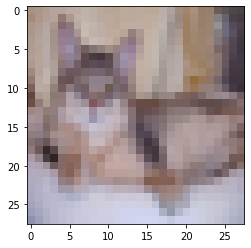

31


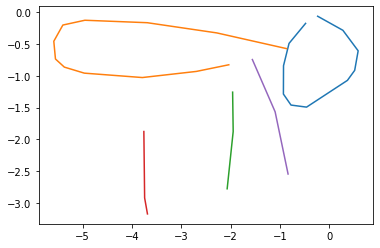

In [123]:
# test the model
model = NewModel()
model.load('../p2s_models/img_encoder_0.814442_31700.pt', '../Models_Complete/sketchRNN_decoder_0.575094_10900.pt')
img_test = '../Datasets/sketchy_cat/cat_p_test_resized/n02121620_30507.png'
img = mpimg.imread(img_test)
imgplot = plt.imshow(img)
plt.show()
z = model.p2s_encoder([img_test])
model.conditional_generation(z)